## Initialization

In [1]:
import re
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import argparse
import os
import warnings
import pandas as pd
from fpdf import FPDF
import cairosvg
from IPython.display import SVG, display
import math

/home1/zhuyixin/.conda/envs/assembly/lib/python3.10/site-packages/fpdf/__init__.py:39: UserWarning: You have both PyFPDF & fpdf2 installed. Both packages cannot be installed at the same time as they share the same module namespace. To only keep fpdf2, run: pip uninstall --yes pypdf && pip install --upgrade fpdf2
  warnings.warn(


In [2]:
species = "mUrsAme1"
haploid = False
gene = "IGL"
dirOut = f"/home1/zhuyixin/zhuyixin_proj/AssmQuality/errorPlots/{species}"
dirStat = f"/home1/zhuyixin/zhuyixin_proj/AssmQuality/errorStats/{species}"

In [3]:
class PDF(FPDF):
    def header(self):
        self.set_font('Arial', 'B', 12)

    def rotate(self, angle, x=None, y=None):
        if x is None:
            x = self.x
        if y is None:
            y = self.y
        self._out('Q')  # Restore previous graphics state
        self._out('q')  # Save graphics state
        if angle != 0:
            angle *= -1  # Invert angle to match expected rotation direction
            c = math.cos(math.radians(angle))
            s = math.sin(math.radians(angle))
            cx = x * self.k
            cy = (self.h - y) * self.k
            self._out(f'1 0 0 1 {cx:.2f} {cy:.2f} cm')  # Translate
            self._out(f'{c:.5f} {s:.5f} {-s:.5f} {c:.5f} 0 0 cm')  # Rotate
            self._out(f'1 0 0 1 {-cx:.2f} {-cy:.2f} cm')  # Translate back

    def stop_rotation(self):
        self._out('Q')


In [4]:
#!rm -rf /home1/zhuyixin/zhuyixin_proj/AssmQuality/errorPlots/{species}/
#!mkdir /home1/zhuyixin/zhuyixin_proj/AssmQuality/errorPlots/{species}

## Coverage Break Analysis

In [5]:
def parse_read_bases(read_bases):
    """
    Parse read bases to count correct matches (., and ,) while correctly handling indels,
    read starts (^), read ends ($), and skipping over sequences indicating indels (+nXXX or -nXXX).
    """
    # Remove read start markers (^) along with the following character indicating mapping quality
    cleaned_bases = re.sub(r'\^.', '', read_bases)

    # Remove read end markers ($)
    cleaned_bases = cleaned_bases.replace('$', '')

    # Correctly handle indels: remove sequences following + or - indicating the length and actual indel
    cleaned_bases = re.sub(r'[\+\-](\d+)([ACGTNacgtn]+)', '', cleaned_bases)

    # Correctly handle * symbols representing deletions of the reference base (not counted as correct)
    cleaned_bases = cleaned_bases.replace('*', '')

    # After removing all special cases, count '.' and ',' as correct matches
    correct = cleaned_bases.count('.') + cleaned_bases.count(',')

    return correct

In [6]:
import re

def count_indels(read_bases):
    """
    Count the number of indels in the read bases, handling both insertions and deletions.
    Indels are indicated by + or - followed by the length of the indel and the sequence.
    """

    # Find all occurrences of indels, both insertions and deletions
    indels = re.findall(r'[\+\-](\d+)([ACGTNacgtn]+)', read_bases)

    # The total count of indels is the sum of the occurrences
    indel_count = sum(int(length) for length, _ in indels)

    return indel_count

In [7]:
pri_pileup_file = f'../errorStats/{species}/{gene}_pri_pileup.txt'

results_pri = {}  # To store results, keyed by (chromosome, position)
with open(pri_pileup_file, 'r') as f:
    for line in f:
        chrom, pos, ref_base, depth, read_bases, _ = line.split()[:6]
        correct = parse_read_bases(read_bases)
        indel = count_indels(read_bases)
        if int(depth) > 0:
            percent_correct = (correct / int(depth)) * 100
        else:
            percent_correct = 0
         # Store or process results
        results_pri[(chrom, pos)] = (correct, percent_correct, depth, indel)

pri_p = [(*key, *value) for key, value in results_pri.items()]
pri_pileup = pd.DataFrame(pri_p, columns=['Chrom', 'Pos', 'Correct', 'PercentCorrect', "Depth", "Indel"])
pri_pileup['Pos'] = pd.to_numeric(pri_pileup['Pos'])
pri_pileup['Correct'] = pd.to_numeric(pri_pileup['Correct'])
pri_pileup['PercentCorrect'] = pd.to_numeric(pri_pileup['PercentCorrect'])
pri_pileup['Depth'] = pd.to_numeric(pri_pileup['Depth'])
pri_pileup['Indel'] = pd.to_numeric(pri_pileup['Indel'])
pri_pileup.sort_values(by=['Chrom', 'Pos'], inplace=True)
alt_pileup_file = f'../errorStats/{species}/{gene}_alt_pileup.txt'
if os.path.exists(alt_pileup_file):
    haploid = False
    results_alt = {}  # To store results, keyed by (chromosome, position)
    with open(alt_pileup_file, 'r') as f:
        for line in f:
            chrom, pos, ref_base, depth, read_bases, _ = line.split()[:6]
            correct = parse_read_bases(read_bases)
            indel = count_indels(read_bases)
            if int(depth) > 0:
                percent_correct = (correct / int(depth)) * 100
            else:
                percent_correct = 0
             # Store or process results
            results_alt[(chrom, pos)] = (correct, percent_correct, depth, indel)
    alt_p = [(*key, *value) for key, value in results_alt.items()]
    alt_pileup = pd.DataFrame(alt_p, columns=['Chrom', 'Pos', 'Correct', 'PercentCorrect', "Depth", "Indel"])
    alt_pileup['Pos'] = pd.to_numeric(alt_pileup['Pos'])
    alt_pileup['Correct'] = pd.to_numeric(alt_pileup['Correct'])
    alt_pileup['PercentCorrect'] = pd.to_numeric(alt_pileup['PercentCorrect'])
    alt_pileup['Depth'] = pd.to_numeric(alt_pileup['Depth'])
    alt_pileup['Indel'] = pd.to_numeric(alt_pileup['Indel'])
    alt_pileup.sort_values(by=['Chrom', 'Pos'], inplace=True)
else:
    haploid = True

In [8]:
if not haploid :
    pileup = pd.concat([pri_pileup, alt_pileup])
else:
    pileup = pri_pileup
pileup.sort_values(by=['Chrom', 'Pos'], inplace=True)
low_coverage = pileup[pileup['Depth'] <= 2]

# Assuming 'Pos' are integers and sorted, if not, you may need to sort and convert
# Detect consecutive positions by checking where the difference is not 1
low_coverage['group'] = low_coverage.groupby('Chrom')['Pos'].transform(lambda x: (x.diff() > 2).cumsum())

# Now, for each group, we can identify the start and end of continuous regions
break_regions = low_coverage.groupby(['Chrom', 'group']).agg({'Pos': ['min', 'max']}).reset_index()

# Renaming for clarity
break_regions.columns = ['Chrom', 'group', 'Start', 'End']
break_regions.drop('group', axis=1, inplace=True)
break_regions_list = [f"{row['Chrom']}:{row['Start']-2000}-{row['End']+2000}" for index, row in break_regions.iterrows()]

break_regions_list

/tmp/SLURM_24229227/ipykernel_21616/1031658753.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_coverage['group'] = low_coverage.groupby('Chrom')['Pos'].transform(lambda x: (x.diff() > 2).cumsum())


['JANIGQ010000033.1:1103871-1114203']

In [9]:
with open(f"{dirOut}/{gene}.break.txt", 'w') as file:
        for row in break_regions_list:
            s = str(row)
            file.write(s+'\n')

In [10]:
# Calculate the change in depth
pileup['DepthChange'] = pileup['Depth'].diff()

# Identify significant drops; here, we define 'significant' as a drop of 10 or more units
# Note: `.diff()` calculates the difference from the previous row, so a drop appears as a negative number
significant_drops = pileup[pileup['DepthChange'] <= -10]
significant_drops

,Chrom,Pos,Correct,PercentCorrect,Depth,Indel,DepthChange


In [11]:
import igv_notebook
igv_notebook.init()
igv_browser = igv_notebook.Browser(
    {
        "reference": { "fastaURL": f"../assemblies/{species}.merged.fasta", "indexURL": f"../assemblies/{species}.merged.fasta.csi"}
    }
)

igv_browser.load_track(
    {
        "name": f"{species}",
        "url": f"../aligned_bam/{species}/{species}_merged_sorted_primary.bam",
        "indexURL": f"../aligned_bam/{species}/{species}_merged_sorted_primary.bam.bai",
        "format": "bam",
        "type": "alignment"
    })

if len(break_regions_list) != 0:
    igv_browser.search(break_regions_list[0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
#igv_browser.search(break_regions_list[0])

## Mismatch Analysis

In [13]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import warnings
from matplotlib.colors import LinearSegmentedColormap

warnings.filterwarnings('ignore')
colors = ["#87CEEB", "#FDA50F", "#228B22", "#708090"]

In [14]:
igh = pd.read_csv(f"../errorStats/{species}/{gene}.txt", sep="\t", names=['read_name','chromosome','start','read_length','mapping_quality','mismatches','mismatch_rate','longindels','total_indel_length','indel_rate','soft_clipping','hard_clipping'])
igh["start"] = pd.to_numeric(igh["start"])
igh["read_length"] = pd.to_numeric(igh["read_length"])
igh["mapping_quality"] = pd.to_numeric(igh["mapping_quality"])
igh['mismatches'] = igh['mismatches'].astype('int')
igh['mismatch_rate'] = igh['mismatch_rate'].astype('float')
igh['longindels'] = igh['longindels'].astype('int')
igh['total_indel_length'] = igh['total_indel_length'].astype('int')
igh['indel_rate'] = igh['indel_rate'].astype('float')
igh['soft_clipping'] = igh['soft_clipping'].astype('int')
igh['hard_clipping'] = igh['hard_clipping'].astype('int')
igh['chromosome'].unique()

array(['JANIGQ010000033.1'], dtype=object)

In [15]:
alt_pileup['Chrom'].value_counts()

NameError: name 'alt_pileup' is not defined

In [16]:
haploid = False

In [17]:
igh

,read_name,chromosome,start,read_length,mapping_quality,mismatches,mismatch_rate,longindels,total_indel_length,indel_rate,soft_clipping,hard_clipping
0,SRR21383219.3892164,JANIGQ010000033.1,447556,19157,34,0,0.000000,1,4,0.000209,0,0
1,SRR21383219.2184656,JANIGQ010000033.1,452765,17358,24,1,0.000058,1,3,0.000173,6,0
2,SRR21383219.4685043,JANIGQ010000033.1,453136,15225,28,1,0.000066,0,0,0.000000,0,0
3,SRR21383219.2900056,JANIGQ010000033.1,453444,12867,17,3,0.000233,1,3,0.000233,0,0
4,SRR21383219.544936,JANIGQ010000033.1,453865,14510,28,0,0.000000,0,0,0.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2090,SRR21383219.4949329,JANIGQ010000033.1,33022635,15879,3,7,0.000441,4,15,0.000945,8,0
2091,SRR21383219.4866919,JANIGQ010000033.1,33022644,12193,3,0,0.000000,0,0,0.000000,0,0
2092,SRR21383219.5848259,JANIGQ010000033.1,33023513,19014,60,0,0.000000,1,3,0.000158,0,0
2093,SRR21383219.1809486,JANIGQ010000033.1,33023759,17179,60,0,0.000000,0,0,0.000000,0,0


In [19]:
threshold = 0.01
chr1_color = "#6AABD7"
chr2_color = "#F0DDB8"
chr5_color = "#206391"

chr3_color = "#3c7eab"

chr4_color = "#f5c569"
chr6_color = "#eda51c"

chr1 = pri_pileup['Chrom'].value_counts().index[0]
#chr3 = pri_pileup['Chrom'].value_counts().index[1]
#chr5 = pri_pileup['Chrom'].value_counts().index[2]

igh_pri_1 = igh[(igh['start'] < 20000000)]
pri_pileup_1 = pri_pileup[pri_pileup['Pos'] < 1219900]

#igh_pri_1 = igh[(igh['chromosome'] == chr1)]
#igh_pri_3 = igh[(igh['chromosome'] == chr3)]
#igh_pri_5 = igh[(igh['chromosome'] == chr5)]

#pri_pileup_1 = pri_pileup[pri_pileup['Chrom']==chr1]
#pri_pileup_3 = pri_pileup[pri_pileup['Chrom']==chr3]
#pri_pileup_5 = pri_pileup[pri_pileup['Chrom']==chr5]

high_mismatch_pri_1 = igh_pri_1[igh_pri_1['mismatch_rate'] > threshold]  
#high_mismatch_pri_3 = igh_pri_3[igh_pri_3['mismatch_rate'] > threshold]  
#high_mismatch_pri_5 = igh_pri_5[igh_pri_5['mismatch_rate'] > threshold]  

if not haploid:
    if len(alt_pileup['Chrom'].value_counts()) > 4:
        haploid = True
    else:
        haploid = False
        alt_pileup = pileup[pileup['Pos'] > 1219900]
        chr2 = alt_pileup['Chrom'].value_counts().index[0]
        # chr4 = alt_pileup['Chrom'].value_counts().index[1]
        # chr6 = alt_pileup['Chrom'].value_counts().index[2]
        # igh_alt = igh[(igh['chromosome'] == chr2)]
        igh_alt = igh[(igh['start'] > 20000000)]
        # igh_alt_4 = igh[(igh['chromosome'] == chr4)]
        # igh_alt_6 = igh[(igh['chromosome'] == chr6)]
        #alt_pileup = pileup[pileup['Chrom']==chr2]
        # alt_pileup_4 = pileup[pileup['Chrom']==chr4]
        # alt_pileup_6 = pileup[pileup['Chrom']==chr6]
        high_mismatch_alt = igh_alt[igh_alt['mismatch_rate'] > threshold]
        # high_mismatch_alt_4 = igh_alt_4[igh_alt_4['mismatch_rate'] > threshold]
        # high_mismatch_alt_6 = igh_alt_6[igh_alt_6['mismatch_rate'] > threshold]

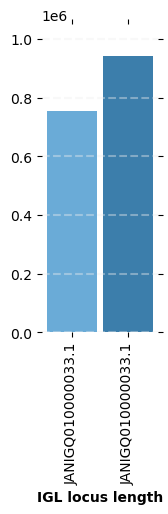

In [35]:
if not haploid:
    lengthPlt, ax = plt.subplots(figsize=(1.5, 4))
    chrom = (chr1, chr2)
    y_pos = np.arange(len(chrom))
    length = (pri_pileup_1['Pos'].max()-pri_pileup_1['Pos'].min(), alt_pileup['Pos'].max()-alt_pileup['Pos'].min())
    ax.bar(y_pos, length, align='center', color=(chr1_color, chr3_color), width=0.9)
    ax.set_xticks(y_pos, labels=chrom)
    ax.set_xlabel(f"{gene} locus length", weight='bold', size=10)
else:
    lengthPlt, ax = plt.subplots(figsize=(1.5, 4))
    chrom = (chr1, chr3)
    y_pos = np.arange(len(chrom))
    length = (pri_pileup_1['Pos'].max()-pri_pileup_1['Pos'].min(), pri_pileup_3['Pos'].max()-pri_pileup_3['Pos'].min())
    ax.bar(y_pos, length, align='center', color=(chr1_color, chr3_color), width=0.9)
    ax.set_xticks(y_pos, labels=chrom)
    ax.set_xlabel(f"{gene} locus\nlength", weight='bold', size=10)


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Switch off ticks
ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="off")
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
# Draw vertical axis lines
vals = ax.get_yticks()
for tick in vals:
  ax.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

# Set x-axis label
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
plt.savefig(f'{dirOut}/{gene}.length.png', format="png", dpi=300, bbox_inches='tight')
plt.show()

NameError: name 'chr4' is not defined

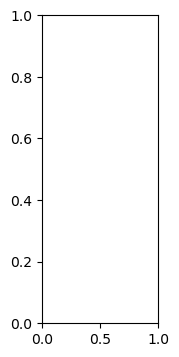

In [30]:
if not haploid:
    lengthPlt, ax = plt.subplots(figsize=(1.5, 4))
    chrom = (chr1, chr2, chr4)
    y_pos = np.arange(len(chrom))
    length = (pri_pileup_1['Pos'].max()-pri_pileup_1['Pos'].min(), alt_pileup['Pos'].max()-alt_pileup['Pos'].min(), alt_pileup_4['Pos'].max()-alt_pileup_4['Pos'].min())
    ax.bar(y_pos, length, align='center', color=(chr1_color, chr2_color, chr4_color), width=0.9)
    ax.set_xticks(y_pos, labels=chrom)
    ax.set_xlabel(f"{gene} locus length", weight='bold', size=10)
else:
    lengthPlt, ax = plt.subplots(figsize=(1.5, 4))
    chrom = (chr1, chr3)
    y_pos = np.arange(len(chrom))
    length = (pri_pileup_1['Pos'].max()-pri_pileup_1['Pos'].min(), pri_pileup_3['Pos'].max()-pri_pileup_3['Pos'].min())
    ax.bar(y_pos, length, align='center', color=(chr1_color, chr3_color), width=0.9)
    ax.set_xticks(y_pos, labels=chrom)
    ax.set_xlabel(f"{gene} locus\nlength", weight='bold', size=10)


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Switch off ticks
ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="off")
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
# Draw vertical axis lines
vals = ax.get_yticks()
for tick in vals:
  ax.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

# Set x-axis label
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
plt.savefig(f'{dirOut}/{gene}.length.png', format="png", dpi=300, bbox_inches='tight')
plt.show()

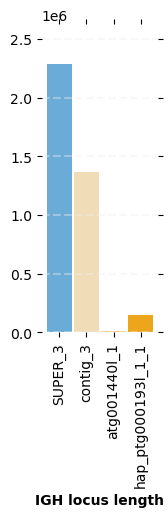

In [17]:
if not haploid:
    lengthPlt, ax = plt.subplots(figsize=(1.5, 4))
    chrom = (chr1, chr2, chr4, chr6)
    y_pos = np.arange(len(chrom))
    length = (pri_pileup_1['Pos'].max()-pri_pileup_1['Pos'].min(), alt_pileup['Pos'].max()-alt_pileup['Pos'].min(), alt_pileup_4['Pos'].max()-alt_pileup_4['Pos'].min(), alt_pileup_6['Pos'].max()-alt_pileup_6['Pos'].min())
    ax.bar(y_pos, length, align='center', color=(chr1_color, chr2_color, chr4_color, chr6_color), width=0.9)
    ax.set_xticks(y_pos, labels=chrom)
    ax.set_xlabel(f"{gene} locus length", weight='bold', size=10)
else:
    lengthPlt, ax = plt.subplots(figsize=(1.5, 4))
    chrom = (chr1, chr3)
    y_pos = np.arange(len(chrom))
    length = (pri_pileup_1['Pos'].max()-pri_pileup_1['Pos'].min(), pri_pileup_3['Pos'].max()-pri_pileup_3['Pos'].min())
    ax.bar(y_pos, length, align='center', color=(chr1_color, chr3_color), width=0.9)
    ax.set_xticks(y_pos, labels=chrom)
    ax.set_xlabel(f"{gene} locus\nlength", weight='bold', size=10)


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Switch off ticks
ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="off")
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
# Draw vertical axis lines
vals = ax.get_yticks()
for tick in vals:
  ax.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

# Set x-axis label
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
plt.savefig(f'{dirOut}/{gene}.length.png', format="png", dpi=300, bbox_inches='tight')
plt.show()

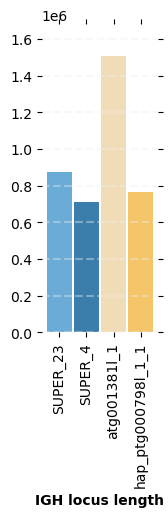

In [35]:
if not haploid:
    lengthPlt, ax = plt.subplots(figsize=(1.5, 4))
    chrom = (chr1, chr3, chr2, chr4)
    y_pos = np.arange(len(chrom))
    length = (pri_pileup_1['Pos'].max()-pri_pileup_1['Pos'].min(), pri_pileup_3['Pos'].max()-pri_pileup_3['Pos'].min(), alt_pileup['Pos'].max()-alt_pileup['Pos'].min(), alt_pileup_4['Pos'].max()-alt_pileup_4['Pos'].min())
    ax.bar(y_pos, length, align='center', color=(chr1_color, chr3_color, chr2_color, chr4_color), width=0.9)
    ax.set_xticks(y_pos, labels=chrom)
    ax.set_xlabel(f"{gene} locus length", weight='bold', size=10)
else:
    lengthPlt, ax = plt.subplots(figsize=(1.5, 4))
    chrom = (chr1, chr3)
    y_pos = np.arange(len(chrom))
    length = (pri_pileup_1['Pos'].max()-pri_pileup_1['Pos'].min(), pri_pileup_3['Pos'].max()-pri_pileup_3['Pos'].min())
    ax.bar(y_pos, length, align='center', color=(chr1_color, chr3_color), width=0.9)
    ax.set_xticks(y_pos, labels=chrom)
    ax.set_xlabel(f"{gene} locus\nlength", weight='bold', size=10)


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Switch off ticks
ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="off")
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
# Draw vertical axis lines
vals = ax.get_yticks()
for tick in vals:
  ax.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

# Set x-axis label
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
plt.savefig(f'{dirOut}/{gene}.length.png', format="png", dpi=300, bbox_inches='tight')
plt.show()

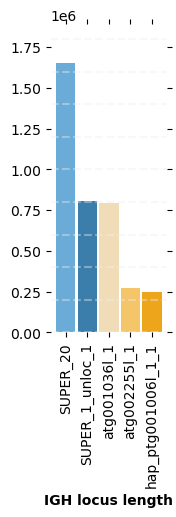

In [35]:
if not haploid:
    lengthPlt, ax = plt.subplots(figsize=(1.5, 4))
    chrom = (chr1, chr3, chr2, chr4, chr6)
    y_pos = np.arange(len(chrom))
    length = (pri_pileup_1['Pos'].max()-pri_pileup_1['Pos'].min(), pri_pileup_3['Pos'].max()-pri_pileup_3['Pos'].min(), alt_pileup['Pos'].max()-alt_pileup['Pos'].min(), alt_pileup_4['Pos'].max()-alt_pileup_4['Pos'].min(), alt_pileup_6['Pos'].max()-alt_pileup_6['Pos'].min())
    ax.bar(y_pos, length, align='center', color=(chr1_color, chr3_color, chr2_color, chr4_color, chr6_color), width=0.9)
    ax.set_xticks(y_pos, labels=chrom)
    ax.set_xlabel(f"{gene} locus length", weight='bold', size=10)
else:
    lengthPlt, ax = plt.subplots(figsize=(1.5, 4))
    chrom = (chr1, chr3)
    y_pos = np.arange(len(chrom))
    length = (pri_pileup_1['Pos'].max()-pri_pileup_1['Pos'].min(), pri_pileup_3['Pos'].max()-pri_pileup_3['Pos'].min())
    ax.bar(y_pos, length, align='center', color=(chr1_color, chr3_color), width=0.9)
    ax.set_xticks(y_pos, labels=chrom)
    ax.set_xlabel(f"{gene} locus\nlength", weight='bold', size=10)


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Switch off ticks
ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="off")
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
# Draw vertical axis lines
vals = ax.get_yticks()
for tick in vals:
  ax.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

# Set x-axis label
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
plt.savefig(f'{dirOut}/{gene}.length.png', format="png", dpi=300, bbox_inches='tight')
plt.show()

### For all reads

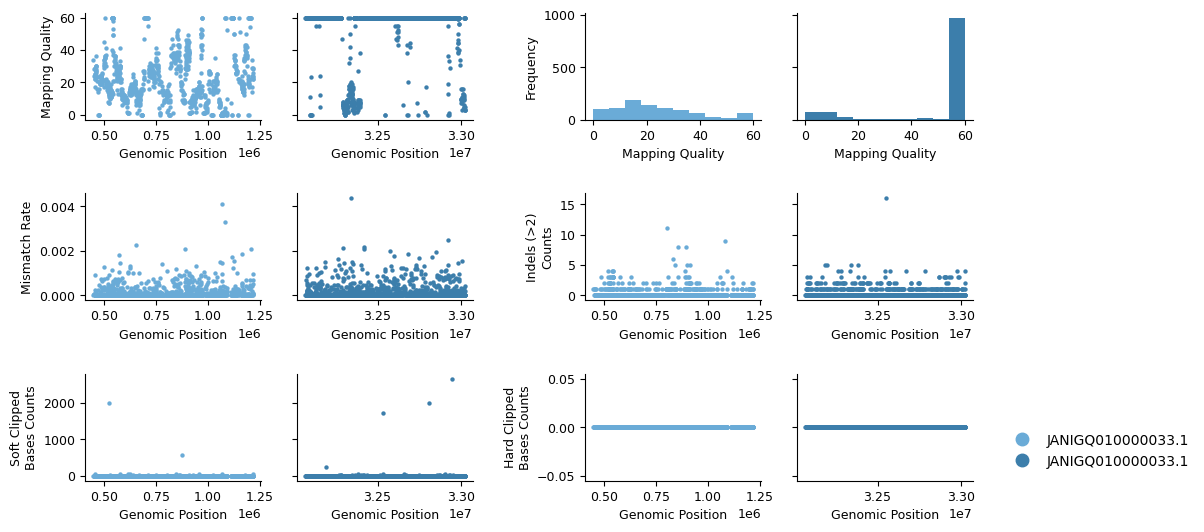

In [21]:
from matplotlib.lines import Line2D

SMALL_SIZE = 9
MEDIUM_SIZE = 9
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams["font.weight"] = "normal"
plt.rcParams["axes.labelweight"] = "normal"

if not haploid:
    SummPlt = plt.figure(figsize=(10, 5))
    subfigs = SummPlt.subfigures(3, 2, wspace=0, hspace = 0.3)
    subfigsnest1 = subfigs[0][0].subplots(1, 2, sharey=True)
    subfigsnest2 = subfigs[0][1].subplots(1, 2, sharey=True)
    subfigsnest3 = subfigs[1][0].subplots(1, 2, sharey=True)
    subfigsnest4 = subfigs[1][1].subplots(1, 2, sharey=True)
    subfigsnest5 = subfigs[2][0].subplots(1, 2, sharey=True)
    subfigsnest6 = subfigs[2][1].subplots(1, 2, sharey=True)

    sns.scatterplot(x='start', y='mapping_quality', data=igh_pri_1, color=chr1_color, s=10, ax=subfigsnest1[0], linewidth=0)
    sns.scatterplot(x='start', y='mismatch_rate', data=igh_pri_1, color=chr1_color, s=10, ax=subfigsnest3[0], linewidth=0)
    sns.scatterplot(x='start', y='longindels', data=igh_pri_1, color=chr1_color, s=10, ax=subfigsnest4[0], linewidth=0)
    sns.scatterplot(x='start', y='soft_clipping', data=igh_pri_1, color=chr1_color, s=10, ax=subfigsnest5[0], linewidth=0)
    sns.scatterplot(x='start', y='hard_clipping', data=igh_pri_1, color=chr1_color, s=10, ax=subfigsnest6[0], linewidth=0)
    
    sns.scatterplot(x='start', y='mapping_quality', data=igh_alt, color=chr3_color, s=10, ax=subfigsnest1[1], linewidth=0)
    sns.scatterplot(x='start', y='mismatch_rate', data=igh_alt, color=chr3_color, s=10, ax=subfigsnest3[1], linewidth=0)
    sns.scatterplot(x='start', y='longindels', data=igh_alt, color=chr3_color, s=10, ax=subfigsnest4[1], linewidth=0)
    sns.scatterplot(x='start', y='soft_clipping', data=igh_alt, color=chr3_color, s=10, ax=subfigsnest5[1], linewidth=0)
    sns.scatterplot(x='start', y='hard_clipping', data=igh_alt, color=chr3_color, s=10, ax=subfigsnest6[1], linewidth=0)
    
    for f in (subfigsnest1, subfigsnest2, subfigsnest3, subfigsnest4, subfigsnest5, subfigsnest6):
        f[0].spines['right'].set_visible(False)
        f[0].spines['top'].set_visible(False)
        f[1].spines['right'].set_visible(False)
        f[1].spines['top'].set_visible(False)
        f[0].set_xlabel('Genomic Position')   
        f[1].set_xlabel('Genomic Position') 

    subfigsnest2[0].hist(igh_pri_1['mapping_quality'], color=chr1_color)
    subfigsnest2[0].set_xlabel('Mapping Quality')
    subfigsnest2[0].set_ylabel('Frequency')
    subfigsnest2[1].hist(igh_alt['mapping_quality'], color=chr3_color)
    subfigsnest2[1].set_xlabel('Mapping Quality')    

    subfigsnest1[0].set_ylabel('Mapping Quality') 
    subfigsnest3[0].set_ylabel('Mismatch Rate') 
    subfigsnest4[0].set_ylabel('Indels (>2)\nCounts') 
    subfigsnest5[0].set_ylabel('Soft Clipped\nBases Counts') 
    subfigsnest6[0].set_ylabel('Hard Clipped\nBases Counts') 

    # Bold font for tick labels
    plt.xticks(fontweight='normal')
    plt.yticks(fontweight='normal')
    custom = [Line2D([], [], marker='.', color=chr1_color, linestyle='None'),
          Line2D([], [], marker='.', color=chr3_color, linestyle='None')]
    plt.legend(custom, [f'{chr1}', f'{chr2}'], bbox_to_anchor=[2.3, 0], loc='lower right', frameon=False, markerscale=3)

else:
    SummPlt = plt.figure(figsize=(5, 5))
    subfigs = SummPlt.subfigures(3, 2, wspace=0.2, hspace = 0.3)
    subfigsnest1 = subfigs[0][0].subplots(1, 1, sharey=True)
    subfigsnest2 = subfigs[0][1].subplots(1, 1, sharey=True)
    subfigsnest3 = subfigs[1][0].subplots(1, 1, sharey=True)
    subfigsnest4 = subfigs[1][1].subplots(1, 1, sharey=True)
    subfigsnest5 = subfigs[2][0].subplots(1, 1, sharey=True)
    subfigsnest6 = subfigs[2][1].subplots(1, 1, sharey=True)

    sns.scatterplot(x='start', y='mapping_quality', data=igh_pri_1, color=chr1_color, s=10, ax=subfigsnest1, linewidth=0)
    sns.scatterplot(x='start', y='mismatch_rate', data=igh_pri_1, color=chr1_color, s=10, ax=subfigsnest3, linewidth=0)
    sns.scatterplot(x='start', y='longindels', data=igh_pri_1, color=chr1_color, s=10, ax=subfigsnest4, linewidth=0)
    sns.scatterplot(x='start', y='soft_clipping', data=igh_pri_1, color=chr1_color, s=10, ax=subfigsnest5, linewidth=0)
    sns.scatterplot(x='start', y='hard_clipping', data=igh_pri_1, color=chr1_color, s=10, ax=subfigsnest6, linewidth=0)
    
    for f in (subfigsnest1, subfigsnest2, subfigsnest3, subfigsnest4, subfigsnest5, subfigsnest6):
        f.spines['right'].set_visible(False)
        f.spines['top'].set_visible(False)
        f.set_xlabel('Genomic Position')   

    subfigsnest2.hist(igh_pri['mapping_quality'], color=chr1_color)
    subfigsnest2.set_xlabel('Mapping Quality')
    subfigsnest2.set_ylabel('Frequency')    
    subfigsnest1.set_ylabel('Mapping Quality') 
    subfigsnest3.set_ylabel('Mismatch Rate') 
    subfigsnest4.set_ylabel('Indels (>2)\nCounts') 
    subfigsnest5.set_ylabel('Soft Clipped\nBases Counts') 
    subfigsnest6.set_ylabel('Hard Clipped\nBases Counts') 

    # Bold font for tick labels
    plt.xticks(fontweight='normal')
    plt.yticks(fontweight='normal')
    custom = [Line2D([], [], marker='.', color=chr1_color, linestyle='None'),
          Line2D([], [], marker='.', color=chr2_color, linestyle='None')]
    plt.legend(custom, [f'{chr1}'], bbox_to_anchor=[2.5, 0], loc='lower right', frameon=False, markerscale=3)
    
#plt.tight_layout()
plt.savefig(f'{dirOut}/{gene}.summary.allreads.png', format="png", dpi=300, bbox_inches='tight')
plt.show()

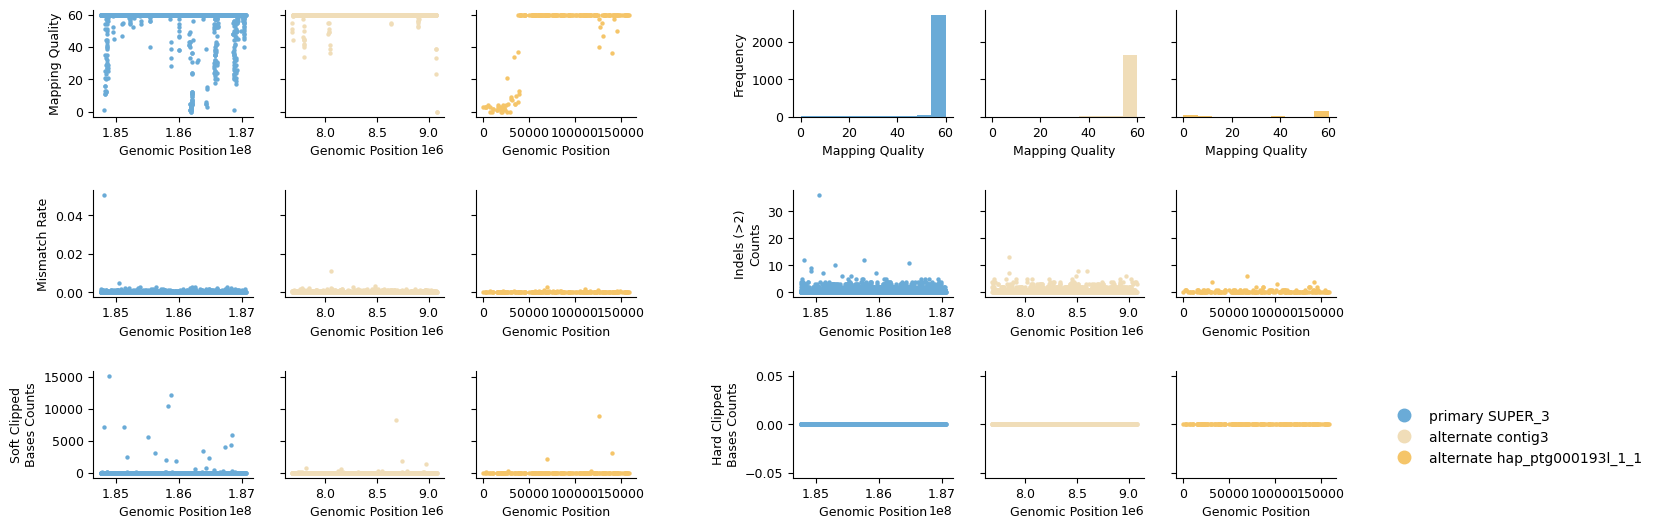

In [21]:
from matplotlib.lines import Line2D

SMALL_SIZE = 9
MEDIUM_SIZE = 9
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams["font.weight"] = "normal"
plt.rcParams["axes.labelweight"] = "normal"

if not haploid:
    SummPlt = plt.figure(figsize=(14, 5))
    subfigs = SummPlt.subfigures(3, 2, wspace=0, hspace = 0.3)
    subfigsnest1 = subfigs[0][0].subplots(1, 3, sharey=True)
    subfigsnest2 = subfigs[0][1].subplots(1, 3, sharey=True)
    subfigsnest3 = subfigs[1][0].subplots(1, 3, sharey=True)
    subfigsnest4 = subfigs[1][1].subplots(1, 3, sharey=True)
    subfigsnest5 = subfigs[2][0].subplots(1, 3, sharey=True)
    subfigsnest6 = subfigs[2][1].subplots(1, 3, sharey=True)

    sns.scatterplot(x='start', y='mapping_quality', data=igh_pri_1, color=chr1_color, s=10, ax=subfigsnest1[0], linewidth=0)
    sns.scatterplot(x='start', y='mismatch_rate', data=igh_pri_1, color=chr1_color, s=10, ax=subfigsnest3[0], linewidth=0)
    sns.scatterplot(x='start', y='longindels', data=igh_pri_1, color=chr1_color, s=10, ax=subfigsnest4[0], linewidth=0)
    sns.scatterplot(x='start', y='soft_clipping', data=igh_pri_1, color=chr1_color, s=10, ax=subfigsnest5[0], linewidth=0)
    sns.scatterplot(x='start', y='hard_clipping', data=igh_pri_1, color=chr1_color, s=10, ax=subfigsnest6[0], linewidth=0)

    sns.scatterplot(x='start', y='mapping_quality', data=igh_alt, color=chr2_color, s=10, ax=subfigsnest1[1], linewidth=0)
    sns.scatterplot(x='start', y='mismatch_rate', data=igh_alt, color=chr2_color, s=10, ax=subfigsnest3[1], linewidth=0)
    sns.scatterplot(x='start', y='longindels', data=igh_alt, color=chr2_color, s=10, ax=subfigsnest4[1], linewidth=0)
    sns.scatterplot(x='start', y='soft_clipping', data=igh_alt, color=chr2_color, s=10, ax=subfigsnest5[1], linewidth=0)
    sns.scatterplot(x='start', y='hard_clipping', data=igh_alt, color=chr2_color, s=10, ax=subfigsnest6[1], linewidth=0)
    
    sns.scatterplot(x='start', y='mapping_quality', data=igh_alt_4, color=chr4_color, s=10, ax=subfigsnest1[2], linewidth=0)
    sns.scatterplot(x='start', y='mismatch_rate', data=igh_alt_4, color=chr4_color, s=10, ax=subfigsnest3[2], linewidth=0)
    sns.scatterplot(x='start', y='longindels', data=igh_alt_4, color=chr4_color, s=10, ax=subfigsnest4[2], linewidth=0)
    sns.scatterplot(x='start', y='soft_clipping', data=igh_alt_4, color=chr4_color, s=10, ax=subfigsnest5[2], linewidth=0)
    sns.scatterplot(x='start', y='hard_clipping', data=igh_alt_4, color=chr4_color, s=10, ax=subfigsnest6[2], linewidth=0)
    
    for f in (subfigsnest1, subfigsnest2, subfigsnest3, subfigsnest4, subfigsnest5, subfigsnest6):
        f[0].spines['right'].set_visible(False)
        f[0].spines['top'].set_visible(False)
        f[1].spines['right'].set_visible(False)
        f[1].spines['top'].set_visible(False)
        f[2].spines['right'].set_visible(False)
        f[2].spines['top'].set_visible(False)
        f[0].set_xlabel('Genomic Position')   
        f[1].set_xlabel('Genomic Position')
        f[2].set_xlabel('Genomic Position') 

    subfigsnest2[0].hist(igh_pri_1['mapping_quality'], color=chr1_color)
    subfigsnest2[0].set_xlabel('Mapping Quality')
    subfigsnest2[0].set_ylabel('Frequency')
    subfigsnest2[1].hist(igh_alt['mapping_quality'], color=chr2_color)
    subfigsnest2[1].set_xlabel('Mapping Quality') 
    subfigsnest2[2].hist(igh_alt_4['mapping_quality'], color=chr4_color)
    subfigsnest2[2].set_xlabel('Mapping Quality')    

    subfigsnest1[0].set_ylabel('Mapping Quality') 
    subfigsnest3[0].set_ylabel('Mismatch Rate') 
    subfigsnest4[0].set_ylabel('Indels (>2)\nCounts') 
    subfigsnest5[0].set_ylabel('Soft Clipped\nBases Counts') 
    subfigsnest6[0].set_ylabel('Hard Clipped\nBases Counts') 

    # Bold font for tick labels
    plt.xticks(fontweight='normal')
    plt.yticks(fontweight='normal')
    custom = [Line2D([], [], marker='.', color=chr1_color, linestyle='None'), Line2D([], [], marker='.', color=chr2_color, linestyle='None'),
          Line2D([], [], marker='.', color=chr4_color, linestyle='None')]
    plt.legend(custom, [f'primary {chr1}', f'alternate {chr2}', f'alternate {chr4}'], bbox_to_anchor=[3, 0], loc='lower right', frameon=False, markerscale=3)

else:
    SummPlt = plt.figure(figsize=(10, 5))
    subfigs = SummPlt.subfigures(3, 2, wspace=0, hspace = 0.3)
    subfigsnest1 = subfigs[0][0].subplots(1, 2, sharey=True)
    subfigsnest2 = subfigs[0][1].subplots(1, 2, sharey=True)
    subfigsnest3 = subfigs[1][0].subplots(1, 2, sharey=True)
    subfigsnest4 = subfigs[1][1].subplots(1, 2, sharey=True)
    subfigsnest5 = subfigs[2][0].subplots(1, 2, sharey=True)
    subfigsnest6 = subfigs[2][1].subplots(1, 2, sharey=True)

    sns.scatterplot(x='start', y='mapping_quality', data=igh_pri_1, color=chr1_color, s=10, ax=subfigsnest1[0], linewidth=0)
    sns.scatterplot(x='start', y='mismatch_rate', data=igh_pri_1, color=chr1_color, s=10, ax=subfigsnest3[0], linewidth=0)
    sns.scatterplot(x='start', y='longindels', data=igh_pri_1, color=chr1_color, s=10, ax=subfigsnest4[0], linewidth=0)
    sns.scatterplot(x='start', y='soft_clipping', data=igh_pri_1, color=chr1_color, s=10, ax=subfigsnest5[0], linewidth=0)
    sns.scatterplot(x='start', y='hard_clipping', data=igh_pri_1, color=chr1_color, s=10, ax=subfigsnest6[0], linewidth=0)

    sns.scatterplot(x='start', y='mapping_quality', data=igh_pri_3, color=chr3_color, s=10, ax=subfigsnest1[1], linewidth=0)
    sns.scatterplot(x='start', y='mismatch_rate', data=igh_pri_3, color=chr3_color, s=10, ax=subfigsnest3[1], linewidth=0)
    sns.scatterplot(x='start', y='longindels', data=igh_pri_3, color=chr3_color, s=10, ax=subfigsnest4[1], linewidth=0)
    sns.scatterplot(x='start', y='soft_clipping', data=igh_pri_3, color=chr3_color, s=10, ax=subfigsnest5[1], linewidth=0)
    sns.scatterplot(x='start', y='hard_clipping', data=igh_pri_3, color=chr3_color, s=10, ax=subfigsnest6[1], linewidth=0)
    
    for f in (subfigsnest1, subfigsnest2, subfigsnest3, subfigsnest4, subfigsnest5, subfigsnest6):
        f[0].spines['right'].set_visible(False)
        f[0].spines['top'].set_visible(False)
        f[1].spines['right'].set_visible(False)
        f[1].spines['top'].set_visible(False)
        f[0].set_xlabel('Genomic Position')   
        f[1].set_xlabel('Genomic Position')

    subfigsnest2[0].hist(igh_pri_1['mapping_quality'], color=chr1_color)
    subfigsnest2[0].set_xlabel('Mapping Quality')
    subfigsnest2[0].set_ylabel('Frequency')
    subfigsnest2[1].hist(igh_pri_3['mapping_quality'], color=chr3_color)
    subfigsnest2[1].set_xlabel('Mapping Quality')   

    subfigsnest1[0].set_ylabel('Mapping Quality') 
    subfigsnest3[0].set_ylabel('Mismatch Rate') 
    subfigsnest4[0].set_ylabel('Indels (>2)\nCounts') 
    subfigsnest5[0].set_ylabel('Soft Clipped\nBases Counts') 
    subfigsnest6[0].set_ylabel('Hard Clipped\nBases Counts') 

    # Bold font for tick labels
    plt.xticks(fontweight='normal')
    plt.yticks(fontweight='normal')
    custom = [Line2D([], [], marker='.', color=chr1_color, linestyle='None'), Line2D([], [], marker='.', color=chr3_color, linestyle='None')]
    plt.legend(custom, [f'primary {chr1}', f'primary {chr3}'], bbox_to_anchor=[2.4, 0], loc='lower right', frameon=False, markerscale=3)
    
#plt.tight_layout()
plt.savefig(f'{dirOut}/{gene}.summary.allreads.png', format="png", dpi=300, bbox_inches='tight')
plt.show()

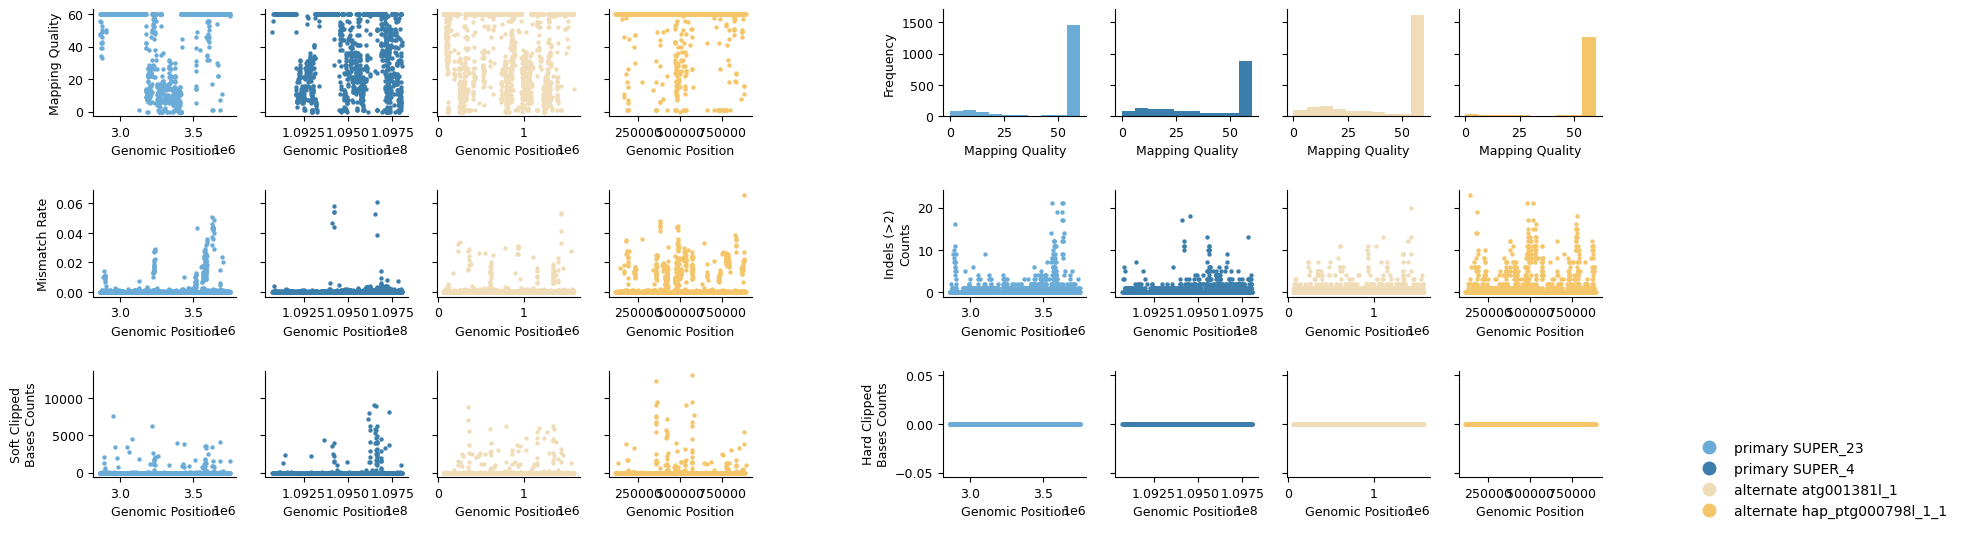

In [36]:
from matplotlib.lines import Line2D

SMALL_SIZE = 9
MEDIUM_SIZE = 9
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams["font.weight"] = "normal"
plt.rcParams["axes.labelweight"] = "normal"

if not haploid:
    SummPlt = plt.figure(figsize=(17, 5))
    subfigs = SummPlt.subfigures(3, 2, wspace=0, hspace = 0.3)
    subfigsnest1 = subfigs[0][0].subplots(1, 4, sharey=True)
    subfigsnest2 = subfigs[0][1].subplots(1, 4, sharey=True)
    subfigsnest3 = subfigs[1][0].subplots(1, 4, sharey=True)
    subfigsnest4 = subfigs[1][1].subplots(1, 4, sharey=True)
    subfigsnest5 = subfigs[2][0].subplots(1, 4, sharey=True)
    subfigsnest6 = subfigs[2][1].subplots(1, 4, sharey=True)

    sns.scatterplot(x='start', y='mapping_quality', data=igh_pri_1, color=chr1_color, s=10, ax=subfigsnest1[0], linewidth=0)
    sns.scatterplot(x='start', y='mismatch_rate', data=igh_pri_1, color=chr1_color, s=10, ax=subfigsnest3[0], linewidth=0)
    sns.scatterplot(x='start', y='longindels', data=igh_pri_1, color=chr1_color, s=10, ax=subfigsnest4[0], linewidth=0)
    sns.scatterplot(x='start', y='soft_clipping', data=igh_pri_1, color=chr1_color, s=10, ax=subfigsnest5[0], linewidth=0)
    sns.scatterplot(x='start', y='hard_clipping', data=igh_pri_1, color=chr1_color, s=10, ax=subfigsnest6[0], linewidth=0)

    sns.scatterplot(x='start', y='mapping_quality', data=igh_pri_3, color=chr3_color, s=10, ax=subfigsnest1[1], linewidth=0)
    sns.scatterplot(x='start', y='mismatch_rate', data=igh_pri_3, color=chr3_color, s=10, ax=subfigsnest3[1], linewidth=0)
    sns.scatterplot(x='start', y='longindels', data=igh_pri_3, color=chr3_color, s=10, ax=subfigsnest4[1], linewidth=0)
    sns.scatterplot(x='start', y='soft_clipping', data=igh_pri_3, color=chr3_color, s=10, ax=subfigsnest5[1], linewidth=0)
    sns.scatterplot(x='start', y='hard_clipping', data=igh_pri_3, color=chr3_color, s=10, ax=subfigsnest6[1], linewidth=0)
    
    sns.scatterplot(x='start', y='mapping_quality', data=igh_alt, color=chr2_color, s=10, ax=subfigsnest1[2], linewidth=0)
    sns.scatterplot(x='start', y='mismatch_rate', data=igh_alt, color=chr2_color, s=10, ax=subfigsnest3[2], linewidth=0)
    sns.scatterplot(x='start', y='longindels', data=igh_alt, color=chr2_color, s=10, ax=subfigsnest4[2], linewidth=0)
    sns.scatterplot(x='start', y='soft_clipping', data=igh_alt, color=chr2_color, s=10, ax=subfigsnest5[2], linewidth=0)
    sns.scatterplot(x='start', y='hard_clipping', data=igh_alt, color=chr2_color, s=10, ax=subfigsnest6[2], linewidth=0)

    sns.scatterplot(x='start', y='mapping_quality', data=igh_alt_4, color=chr4_color, s=10, ax=subfigsnest1[3], linewidth=0)
    sns.scatterplot(x='start', y='mismatch_rate', data=igh_alt_4, color=chr4_color, s=10, ax=subfigsnest3[3], linewidth=0)
    sns.scatterplot(x='start', y='longindels', data=igh_alt_4, color=chr4_color, s=10, ax=subfigsnest4[3], linewidth=0)
    sns.scatterplot(x='start', y='soft_clipping', data=igh_alt_4, color=chr4_color, s=10, ax=subfigsnest5[3], linewidth=0)
    sns.scatterplot(x='start', y='hard_clipping', data=igh_alt_4, color=chr4_color, s=10, ax=subfigsnest6[3], linewidth=0)


    for f in (subfigsnest1, subfigsnest2, subfigsnest3, subfigsnest4, subfigsnest5, subfigsnest6):
        f[0].spines['right'].set_visible(False)
        f[0].spines['top'].set_visible(False)
        f[1].spines['right'].set_visible(False)
        f[1].spines['top'].set_visible(False)
        f[2].spines['right'].set_visible(False)
        f[2].spines['top'].set_visible(False)
        f[3].spines['right'].set_visible(False)
        f[3].spines['top'].set_visible(False)
        f[0].set_xlabel('Genomic Position')   
        f[1].set_xlabel('Genomic Position')
        f[2].set_xlabel('Genomic Position') 
        f[3].set_xlabel('Genomic Position') 

    subfigsnest2[0].hist(igh_pri_1['mapping_quality'], color=chr1_color)
    subfigsnest2[0].set_xlabel('Mapping Quality')
    subfigsnest2[0].set_ylabel('Frequency')
    subfigsnest2[1].hist(igh_pri_3['mapping_quality'], color=chr3_color)
    subfigsnest2[1].set_xlabel('Mapping Quality') 
    subfigsnest2[2].hist(igh_alt['mapping_quality'], color=chr2_color)
    subfigsnest2[2].set_xlabel('Mapping Quality')    
    subfigsnest2[3].hist(igh_alt_4['mapping_quality'], color=chr4_color)
    subfigsnest2[3].set_xlabel('Mapping Quality')
    
    subfigsnest1[0].set_ylabel('Mapping Quality') 
    subfigsnest3[0].set_ylabel('Mismatch Rate') 
    subfigsnest4[0].set_ylabel('Indels (>2)\nCounts') 
    subfigsnest5[0].set_ylabel('Soft Clipped\nBases Counts') 
    subfigsnest6[0].set_ylabel('Hard Clipped\nBases Counts') 

    # Bold font for tick labels
    plt.xticks(fontweight='normal')
    plt.yticks(fontweight='normal')
    custom = [Line2D([], [], marker='.', color=chr1_color, linestyle='None'), Line2D([], [], marker='.', color=chr3_color, linestyle='None'),
          Line2D([], [], marker='.', color=chr2_color, linestyle='None'), Line2D([], [], marker='.', color=chr4_color, linestyle='None')]
    plt.legend(custom, [f'primary {chr1}', f'primary {chr3}', f'alternate {chr2}', f'alternate {chr4}'], bbox_to_anchor=[3.5, -0.5], loc='lower right', frameon=False, markerscale=3)

plt.savefig(f'{dirOut}/{gene}.summary.allreads.png', format="png", dpi=300, bbox_inches='tight')
plt.show()

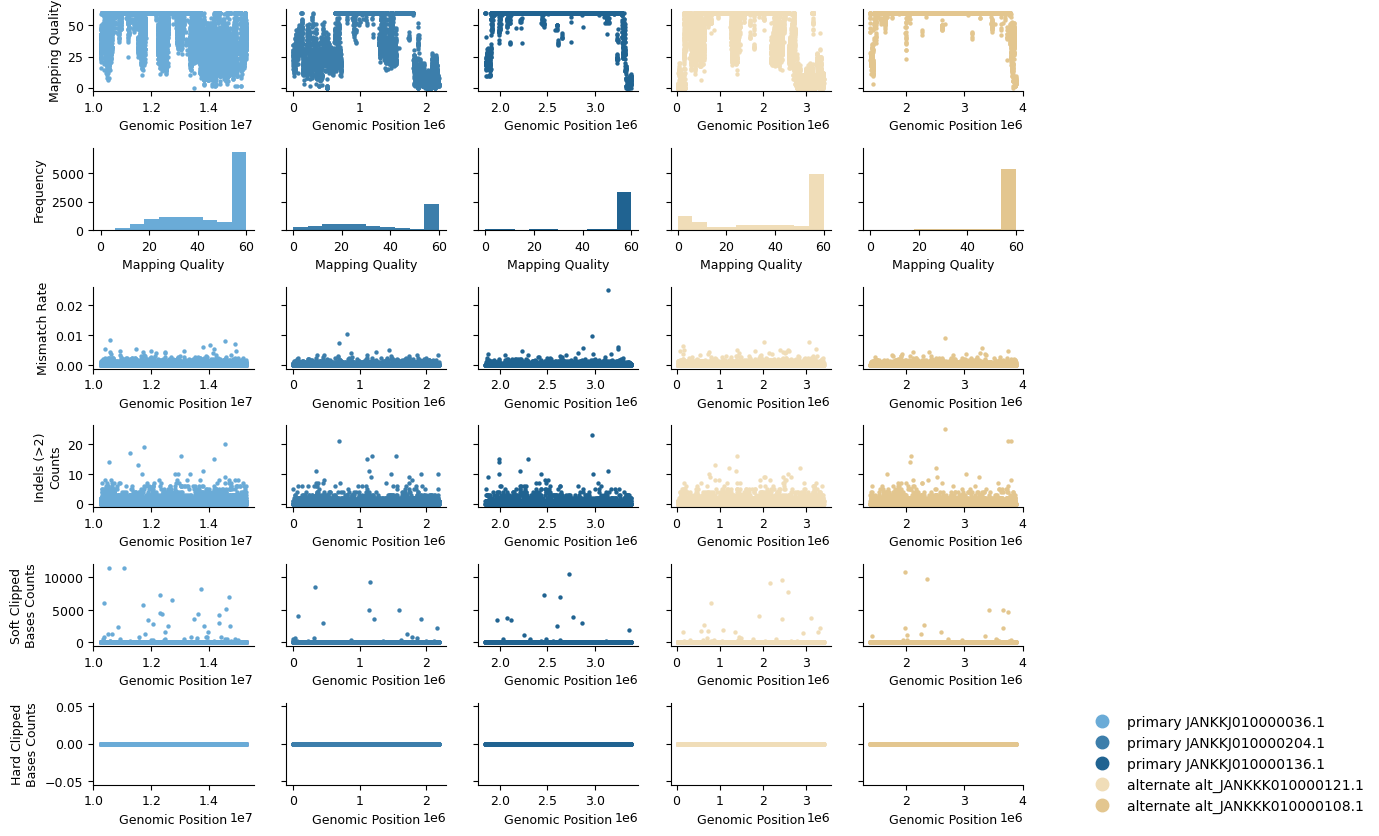

In [47]:
from matplotlib.lines import Line2D

SMALL_SIZE = 9
MEDIUM_SIZE = 9
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams["font.weight"] = "normal"
plt.rcParams["axes.labelweight"] = "normal"

if not haploid:
    SummPlt = plt.figure(figsize=(12, 8))
    subfigs = SummPlt.subfigures(6, 1, wspace=0, hspace = 0.3)
    subfigsnest1 = subfigs[0].subplots(1, 5, sharey=True)
    subfigsnest2 = subfigs[1].subplots(1, 5, sharey=True)
    subfigsnest3 = subfigs[2].subplots(1, 5, sharey=True)
    subfigsnest4 = subfigs[3].subplots(1, 5, sharey=True)
    subfigsnest5 = subfigs[4].subplots(1, 5, sharey=True)
    subfigsnest6 = subfigs[5].subplots(1, 5, sharey=True)

    sns.scatterplot(x='start', y='mapping_quality', data=igh_pri_1, color=chr1_color, s=10, ax=subfigsnest1[0], linewidth=0)
    sns.scatterplot(x='start', y='mismatch_rate', data=igh_pri_1, color=chr1_color, s=10, ax=subfigsnest3[0], linewidth=0)
    sns.scatterplot(x='start', y='longindels', data=igh_pri_1, color=chr1_color, s=10, ax=subfigsnest4[0], linewidth=0)
    sns.scatterplot(x='start', y='soft_clipping', data=igh_pri_1, color=chr1_color, s=10, ax=subfigsnest5[0], linewidth=0)
    sns.scatterplot(x='start', y='hard_clipping', data=igh_pri_1, color=chr1_color, s=10, ax=subfigsnest6[0], linewidth=0)

    sns.scatterplot(x='start', y='mapping_quality', data=igh_pri_3, color=chr3_color, s=10, ax=subfigsnest1[1], linewidth=0)
    sns.scatterplot(x='start', y='mismatch_rate', data=igh_pri_3, color=chr3_color, s=10, ax=subfigsnest3[1], linewidth=0)
    sns.scatterplot(x='start', y='longindels', data=igh_pri_3, color=chr3_color, s=10, ax=subfigsnest4[1], linewidth=0)
    sns.scatterplot(x='start', y='soft_clipping', data=igh_pri_3, color=chr3_color, s=10, ax=subfigsnest5[1], linewidth=0)
    sns.scatterplot(x='start', y='hard_clipping', data=igh_pri_3, color=chr3_color, s=10, ax=subfigsnest6[1], linewidth=0)

    sns.scatterplot(x='start', y='mapping_quality', data=igh_pri_5, color=chr5_color, s=10, ax=subfigsnest1[2], linewidth=0)
    sns.scatterplot(x='start', y='mismatch_rate', data=igh_pri_5, color=chr5_color, s=10, ax=subfigsnest3[2], linewidth=0)
    sns.scatterplot(x='start', y='longindels', data=igh_pri_5, color=chr5_color, s=10, ax=subfigsnest4[2], linewidth=0)
    sns.scatterplot(x='start', y='soft_clipping', data=igh_pri_5, color=chr5_color, s=10, ax=subfigsnest5[2], linewidth=0)
    sns.scatterplot(x='start', y='hard_clipping', data=igh_pri_5, color=chr5_color, s=10, ax=subfigsnest6[2], linewidth=0)
    
    sns.scatterplot(x='start', y='mapping_quality', data=igh_alt, color=chr2_color, s=10, ax=subfigsnest1[3], linewidth=0)
    sns.scatterplot(x='start', y='mismatch_rate', data=igh_alt, color=chr2_color, s=10, ax=subfigsnest3[3], linewidth=0)
    sns.scatterplot(x='start', y='longindels', data=igh_alt, color=chr2_color, s=10, ax=subfigsnest4[3], linewidth=0)
    sns.scatterplot(x='start', y='soft_clipping', data=igh_alt, color=chr2_color, s=10, ax=subfigsnest5[3], linewidth=0)
    sns.scatterplot(x='start', y='hard_clipping', data=igh_alt, color=chr2_color, s=10, ax=subfigsnest6[3], linewidth=0)

    sns.scatterplot(x='start', y='mapping_quality', data=igh_alt_4, color=chr4_color, s=10, ax=subfigsnest1[4], linewidth=0)
    sns.scatterplot(x='start', y='mismatch_rate', data=igh_alt_4, color=chr4_color, s=10, ax=subfigsnest3[4], linewidth=0)
    sns.scatterplot(x='start', y='longindels', data=igh_alt_4, color=chr4_color, s=10, ax=subfigsnest4[4], linewidth=0)
    sns.scatterplot(x='start', y='soft_clipping', data=igh_alt_4, color=chr4_color, s=10, ax=subfigsnest5[4], linewidth=0)
    sns.scatterplot(x='start', y='hard_clipping', data=igh_alt_4, color=chr4_color, s=10, ax=subfigsnest6[4], linewidth=0)


    for f in (subfigsnest1, subfigsnest2, subfigsnest3, subfigsnest4, subfigsnest5, subfigsnest6):
        f[0].spines['right'].set_visible(False)
        f[0].spines['top'].set_visible(False)
        f[1].spines['right'].set_visible(False)
        f[1].spines['top'].set_visible(False)
        f[2].spines['right'].set_visible(False)
        f[2].spines['top'].set_visible(False)
        f[3].spines['right'].set_visible(False)
        f[3].spines['top'].set_visible(False)
        f[4].spines['right'].set_visible(False)
        f[4].spines['top'].set_visible(False)
        f[0].set_xlabel('Genomic Position')   
        f[1].set_xlabel('Genomic Position')
        f[2].set_xlabel('Genomic Position') 
        f[3].set_xlabel('Genomic Position')
        f[4].set_xlabel('Genomic Position') 

    subfigsnest2[0].hist(igh_pri_1['mapping_quality'], color=chr1_color)
    subfigsnest2[0].set_xlabel('Mapping Quality')
    subfigsnest2[0].set_ylabel('Frequency')
    subfigsnest2[1].hist(igh_pri_3['mapping_quality'], color=chr3_color)
    subfigsnest2[1].set_xlabel('Mapping Quality') 
    subfigsnest2[2].hist(igh_pri_5['mapping_quality'], color=chr5_color)
    subfigsnest2[2].set_xlabel('Mapping Quality')
    subfigsnest2[3].hist(igh_alt['mapping_quality'], color=chr2_color)
    subfigsnest2[3].set_xlabel('Mapping Quality')    
    subfigsnest2[4].hist(igh_alt_4['mapping_quality'], color=chr4_color)
    subfigsnest2[4].set_xlabel('Mapping Quality')
    
    subfigsnest1[0].set_ylabel('Mapping Quality') 
    subfigsnest3[0].set_ylabel('Mismatch Rate') 
    subfigsnest4[0].set_ylabel('Indels (>2)\nCounts') 
    subfigsnest5[0].set_ylabel('Soft Clipped\nBases Counts') 
    subfigsnest6[0].set_ylabel('Hard Clipped\nBases Counts') 

    # Bold font for tick labels
    plt.xticks(fontweight='normal')
    plt.yticks(fontweight='normal')
    custom = [Line2D([], [], marker='.', color=chr1_color, linestyle='None'), Line2D([], [], marker='.', color=chr3_color, linestyle='None'), Line2D([], [], marker='.', color=chr5_color, linestyle='None'),
          Line2D([], [], marker='.', color=chr2_color, linestyle='None'), Line2D([], [], marker='.', color=chr4_color, linestyle='None')]
    plt.legend(custom, [f'primary {chr1}', f'primary {chr3}', f'primary {chr5}', f'alternate {chr2}', f'alternate {chr4}'], bbox_to_anchor=[3.2, -0.5], loc='lower right', frameon=False, markerscale=3)

plt.savefig(f'{dirOut}/{gene}.summary.allreads.png', format="png", dpi=300, bbox_inches='tight')
plt.show()

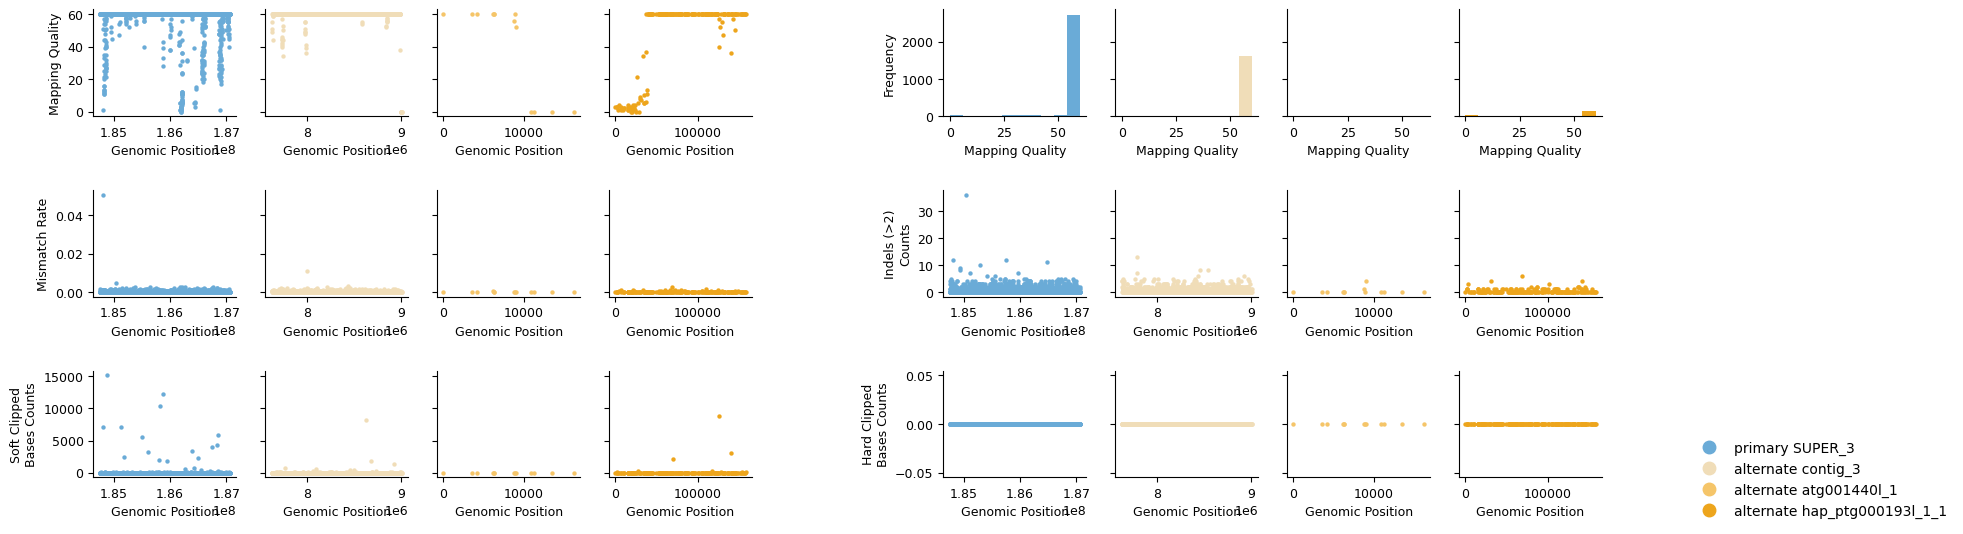

In [18]:
from matplotlib.lines import Line2D

SMALL_SIZE = 9
MEDIUM_SIZE = 9
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams["font.weight"] = "normal"
plt.rcParams["axes.labelweight"] = "normal"

if not haploid:
    SummPlt = plt.figure(figsize=(17, 5))
    subfigs = SummPlt.subfigures(3, 2, wspace=0, hspace = 0.3)
    subfigsnest1 = subfigs[0][0].subplots(1, 4, sharey=True)
    subfigsnest2 = subfigs[0][1].subplots(1, 4, sharey=True)
    subfigsnest3 = subfigs[1][0].subplots(1, 4, sharey=True)
    subfigsnest4 = subfigs[1][1].subplots(1, 4, sharey=True)
    subfigsnest5 = subfigs[2][0].subplots(1, 4, sharey=True)
    subfigsnest6 = subfigs[2][1].subplots(1, 4, sharey=True)

    sns.scatterplot(x='start', y='mapping_quality', data=igh_pri_1, color=chr1_color, s=10, ax=subfigsnest1[0], linewidth=0)
    sns.scatterplot(x='start', y='mismatch_rate', data=igh_pri_1, color=chr1_color, s=10, ax=subfigsnest3[0], linewidth=0)
    sns.scatterplot(x='start', y='longindels', data=igh_pri_1, color=chr1_color, s=10, ax=subfigsnest4[0], linewidth=0)
    sns.scatterplot(x='start', y='soft_clipping', data=igh_pri_1, color=chr1_color, s=10, ax=subfigsnest5[0], linewidth=0)
    sns.scatterplot(x='start', y='hard_clipping', data=igh_pri_1, color=chr1_color, s=10, ax=subfigsnest6[0], linewidth=0)

    sns.scatterplot(x='start', y='mapping_quality', data=igh_alt, color=chr2_color, s=10, ax=subfigsnest1[1], linewidth=0)
    sns.scatterplot(x='start', y='mismatch_rate', data=igh_alt, color=chr2_color, s=10, ax=subfigsnest3[1], linewidth=0)
    sns.scatterplot(x='start', y='longindels', data=igh_alt, color=chr2_color, s=10, ax=subfigsnest4[1], linewidth=0)
    sns.scatterplot(x='start', y='soft_clipping', data=igh_alt, color=chr2_color, s=10, ax=subfigsnest5[1], linewidth=0)
    sns.scatterplot(x='start', y='hard_clipping', data=igh_alt, color=chr2_color, s=10, ax=subfigsnest6[1], linewidth=0)
    
    sns.scatterplot(x='start', y='mapping_quality', data=igh_alt_4, color=chr4_color, s=10, ax=subfigsnest1[2], linewidth=0)
    sns.scatterplot(x='start', y='mismatch_rate', data=igh_alt_4, color=chr4_color, s=10, ax=subfigsnest3[2], linewidth=0)
    sns.scatterplot(x='start', y='longindels', data=igh_alt_4, color=chr4_color, s=10, ax=subfigsnest4[2], linewidth=0)
    sns.scatterplot(x='start', y='soft_clipping', data=igh_alt_4, color=chr4_color, s=10, ax=subfigsnest5[2], linewidth=0)
    sns.scatterplot(x='start', y='hard_clipping', data=igh_alt_4, color=chr4_color, s=10, ax=subfigsnest6[2], linewidth=0)

    sns.scatterplot(x='start', y='mapping_quality', data=igh_alt_6, color=chr6_color, s=10, ax=subfigsnest1[3], linewidth=0)
    sns.scatterplot(x='start', y='mismatch_rate', data=igh_alt_6, color=chr6_color, s=10, ax=subfigsnest3[3], linewidth=0)
    sns.scatterplot(x='start', y='longindels', data=igh_alt_6, color=chr6_color, s=10, ax=subfigsnest4[3], linewidth=0)
    sns.scatterplot(x='start', y='soft_clipping', data=igh_alt_6, color=chr6_color, s=10, ax=subfigsnest5[3], linewidth=0)
    sns.scatterplot(x='start', y='hard_clipping', data=igh_alt_6, color=chr6_color, s=10, ax=subfigsnest6[3], linewidth=0)


    for f in (subfigsnest1, subfigsnest2, subfigsnest3, subfigsnest4, subfigsnest5, subfigsnest6):
        f[0].spines['right'].set_visible(False)
        f[0].spines['top'].set_visible(False)
        f[1].spines['right'].set_visible(False)
        f[1].spines['top'].set_visible(False)
        f[2].spines['right'].set_visible(False)
        f[2].spines['top'].set_visible(False)
        f[3].spines['right'].set_visible(False)
        f[3].spines['top'].set_visible(False)
        f[0].set_xlabel('Genomic Position')   
        f[1].set_xlabel('Genomic Position')
        f[2].set_xlabel('Genomic Position') 
        f[3].set_xlabel('Genomic Position') 

    subfigsnest2[0].hist(igh_pri_1['mapping_quality'], color=chr1_color)
    subfigsnest2[0].set_xlabel('Mapping Quality')
    subfigsnest2[0].set_ylabel('Frequency')
    subfigsnest2[1].hist(igh_alt['mapping_quality'], color=chr2_color)
    subfigsnest2[1].set_xlabel('Mapping Quality') 
    subfigsnest2[2].hist(igh_alt_4['mapping_quality'], color=chr4_color)
    subfigsnest2[2].set_xlabel('Mapping Quality')    
    subfigsnest2[3].hist(igh_alt_6['mapping_quality'], color=chr6_color)
    subfigsnest2[3].set_xlabel('Mapping Quality')
    
    subfigsnest1[0].set_ylabel('Mapping Quality') 
    subfigsnest3[0].set_ylabel('Mismatch Rate') 
    subfigsnest4[0].set_ylabel('Indels (>2)\nCounts') 
    subfigsnest5[0].set_ylabel('Soft Clipped\nBases Counts') 
    subfigsnest6[0].set_ylabel('Hard Clipped\nBases Counts') 

    # Bold font for tick labels
    plt.xticks(fontweight='normal')
    plt.yticks(fontweight='normal')
    custom = [Line2D([], [], marker='.', color=chr1_color, linestyle='None'), Line2D([], [], marker='.', color=chr2_color, linestyle='None'),
          Line2D([], [], marker='.', color=chr4_color, linestyle='None'), Line2D([], [], marker='.', color=chr6_color, linestyle='None')]
    plt.legend(custom, [f'primary {chr1}', f'alternate {chr2}', f'alternate {chr4}', f'alternate {chr6}'], bbox_to_anchor=[3.5, -0.5], loc='lower right', frameon=False, markerscale=3)

plt.savefig(f'{dirOut}/{gene}.summary.allreads.png', format="png", dpi=300, bbox_inches='tight')
plt.show()

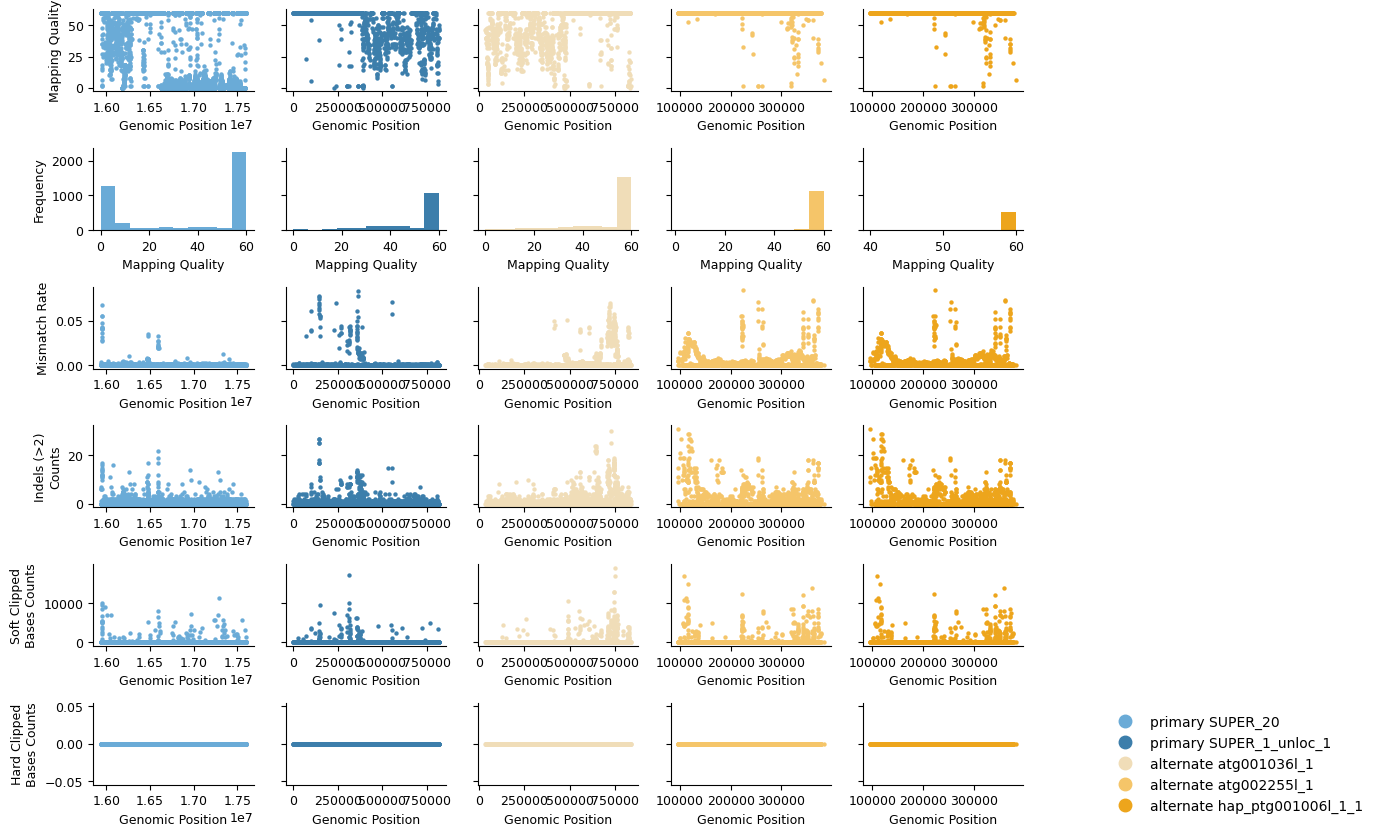

In [36]:
from matplotlib.lines import Line2D

SMALL_SIZE = 9
MEDIUM_SIZE = 9
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams["font.weight"] = "normal"
plt.rcParams["axes.labelweight"] = "normal"

if not haploid:
    SummPlt = plt.figure(figsize=(12, 8))
    subfigs = SummPlt.subfigures(6, 1, wspace=0, hspace = 0.3)
    subfigsnest1 = subfigs[0].subplots(1, 5, sharey=True)
    subfigsnest2 = subfigs[1].subplots(1, 5, sharey=True)
    subfigsnest3 = subfigs[2].subplots(1, 5, sharey=True)
    subfigsnest4 = subfigs[3].subplots(1, 5, sharey=True)
    subfigsnest5 = subfigs[4].subplots(1, 5, sharey=True)
    subfigsnest6 = subfigs[5].subplots(1, 5, sharey=True)

    sns.scatterplot(x='start', y='mapping_quality', data=igh_pri_1, color=chr1_color, s=10, ax=subfigsnest1[0], linewidth=0)
    sns.scatterplot(x='start', y='mismatch_rate', data=igh_pri_1, color=chr1_color, s=10, ax=subfigsnest3[0], linewidth=0)
    sns.scatterplot(x='start', y='longindels', data=igh_pri_1, color=chr1_color, s=10, ax=subfigsnest4[0], linewidth=0)
    sns.scatterplot(x='start', y='soft_clipping', data=igh_pri_1, color=chr1_color, s=10, ax=subfigsnest5[0], linewidth=0)
    sns.scatterplot(x='start', y='hard_clipping', data=igh_pri_1, color=chr1_color, s=10, ax=subfigsnest6[0], linewidth=0)

    sns.scatterplot(x='start', y='mapping_quality', data=igh_pri_3, color=chr3_color, s=10, ax=subfigsnest1[1], linewidth=0)
    sns.scatterplot(x='start', y='mismatch_rate', data=igh_pri_3, color=chr3_color, s=10, ax=subfigsnest3[1], linewidth=0)
    sns.scatterplot(x='start', y='longindels', data=igh_pri_3, color=chr3_color, s=10, ax=subfigsnest4[1], linewidth=0)
    sns.scatterplot(x='start', y='soft_clipping', data=igh_pri_3, color=chr3_color, s=10, ax=subfigsnest5[1], linewidth=0)
    sns.scatterplot(x='start', y='hard_clipping', data=igh_pri_3, color=chr3_color, s=10, ax=subfigsnest6[1], linewidth=0)

    sns.scatterplot(x='start', y='mapping_quality', data=igh_alt, color=chr2_color, s=10, ax=subfigsnest1[2], linewidth=0)
    sns.scatterplot(x='start', y='mismatch_rate', data=igh_alt, color=chr2_color, s=10, ax=subfigsnest3[2], linewidth=0)
    sns.scatterplot(x='start', y='longindels', data=igh_alt, color=chr2_color, s=10, ax=subfigsnest4[2], linewidth=0)
    sns.scatterplot(x='start', y='soft_clipping', data=igh_alt, color=chr2_color, s=10, ax=subfigsnest5[2], linewidth=0)
    sns.scatterplot(x='start', y='hard_clipping', data=igh_alt, color=chr2_color, s=10, ax=subfigsnest6[2], linewidth=0)
    
    sns.scatterplot(x='start', y='mapping_quality', data=igh_alt_4, color=chr4_color, s=10, ax=subfigsnest1[3], linewidth=0)
    sns.scatterplot(x='start', y='mismatch_rate', data=igh_alt_4, color=chr4_color, s=10, ax=subfigsnest3[3], linewidth=0)
    sns.scatterplot(x='start', y='longindels', data=igh_alt_4, color=chr4_color, s=10, ax=subfigsnest4[3], linewidth=0)
    sns.scatterplot(x='start', y='soft_clipping', data=igh_alt_4, color=chr4_color, s=10, ax=subfigsnest5[3], linewidth=0)
    sns.scatterplot(x='start', y='hard_clipping', data=igh_alt_4, color=chr4_color, s=10, ax=subfigsnest6[3], linewidth=0)

    sns.scatterplot(x='start', y='mapping_quality', data=igh_alt_4, color=chr6_color, s=10, ax=subfigsnest1[4], linewidth=0)
    sns.scatterplot(x='start', y='mismatch_rate', data=igh_alt_4, color=chr6_color, s=10, ax=subfigsnest3[4], linewidth=0)
    sns.scatterplot(x='start', y='longindels', data=igh_alt_4, color=chr6_color, s=10, ax=subfigsnest4[4], linewidth=0)
    sns.scatterplot(x='start', y='soft_clipping', data=igh_alt_4, color=chr6_color, s=10, ax=subfigsnest5[4], linewidth=0)
    sns.scatterplot(x='start', y='hard_clipping', data=igh_alt_4, color=chr6_color, s=10, ax=subfigsnest6[4], linewidth=0)


    for f in (subfigsnest1, subfigsnest2, subfigsnest3, subfigsnest4, subfigsnest5, subfigsnest6):
        f[0].spines['right'].set_visible(False)
        f[0].spines['top'].set_visible(False)
        f[1].spines['right'].set_visible(False)
        f[1].spines['top'].set_visible(False)
        f[2].spines['right'].set_visible(False)
        f[2].spines['top'].set_visible(False)
        f[3].spines['right'].set_visible(False)
        f[3].spines['top'].set_visible(False)
        f[4].spines['right'].set_visible(False)
        f[4].spines['top'].set_visible(False)
        f[0].set_xlabel('Genomic Position')   
        f[1].set_xlabel('Genomic Position')
        f[2].set_xlabel('Genomic Position') 
        f[3].set_xlabel('Genomic Position')
        f[4].set_xlabel('Genomic Position') 

    subfigsnest2[0].hist(igh_pri_1['mapping_quality'], color=chr1_color)
    subfigsnest2[0].set_xlabel('Mapping Quality')
    subfigsnest2[0].set_ylabel('Frequency')
    subfigsnest2[1].hist(igh_pri_3['mapping_quality'], color=chr3_color)
    subfigsnest2[1].set_xlabel('Mapping Quality') 
    subfigsnest2[2].hist(igh_alt['mapping_quality'], color=chr2_color)
    subfigsnest2[2].set_xlabel('Mapping Quality')
    subfigsnest2[3].hist(igh_alt_4['mapping_quality'], color=chr4_color)
    subfigsnest2[3].set_xlabel('Mapping Quality')    
    subfigsnest2[4].hist(igh_alt_6['mapping_quality'], color=chr6_color)
    subfigsnest2[4].set_xlabel('Mapping Quality')
    
    subfigsnest1[0].set_ylabel('Mapping Quality') 
    subfigsnest3[0].set_ylabel('Mismatch Rate') 
    subfigsnest4[0].set_ylabel('Indels (>2)\nCounts') 
    subfigsnest5[0].set_ylabel('Soft Clipped\nBases Counts') 
    subfigsnest6[0].set_ylabel('Hard Clipped\nBases Counts') 

    # Bold font for tick labels
    plt.xticks(fontweight='normal')
    plt.yticks(fontweight='normal')
    custom = [Line2D([], [], marker='.', color=chr1_color, linestyle='None'), Line2D([], [], marker='.', color=chr3_color, linestyle='None'), Line2D([], [], marker='.', color=chr2_color, linestyle='None'),
          Line2D([], [], marker='.', color=chr4_color, linestyle='None'), Line2D([], [], marker='.', color=chr6_color, linestyle='None')]
    plt.legend(custom, [f'primary {chr1}', f'primary {chr3}', f'alternate {chr2}', f'alternate {chr4}', f'alternate {chr6}'], bbox_to_anchor=[3.2, -0.5], loc='lower right', frameon=False, markerscale=3)

plt.savefig(f'{dirOut}/{gene}.summary.allreads.png', format="png", dpi=300, bbox_inches='tight')
plt.show()

## Reads Level

In [22]:
def coverage3(igh_pri, igh_alt, igh_alt_4):
    mismatchThreshold = 5
    min_position_pri = igh_pri['start'].min()
    max_position_pri = (igh_pri['start'] + igh_pri['read_length']).max()
    coverage_counts_pri = np.zeros(max_position_pri - min_position_pri + 1, dtype=int)
    high_mismatch_coverage_pri = np.zeros(max_position_pri - min_position_pri + 1, dtype=int)
    for _, row in igh_pri[igh_pri['mapping_quality'] == 60].iterrows():
        start_index = row['start'] - min_position_pri
        end_index = start_index + row['read_length']
        coverage_counts_pri[start_index:end_index] += 1
        if row['mismatch_rate'] > 0.01:  # Adjust this threshold as needed
            high_mismatch_coverage_pri[start_index:end_index] += 1
    zero_counts_pri = np.zeros(max_position_pri - min_position_pri + 1, dtype=int)
    for _, row in igh_pri[igh_pri['mapping_quality'] == 0].iterrows():
        start_index = row['start'] - min_position_pri
        end_index = start_index + row['read_length']
        zero_counts_pri[start_index:end_index] += 1
        if row['mismatch_rate'] > 0.01:  # Adjust this threshold as needed
            high_mismatch_coverage_pri[start_index:end_index] += 1
    mid_counts_pri = np.zeros(max_position_pri - min_position_pri + 1, dtype=int)
    for _, row in igh_pri[(igh_pri['mapping_quality'] > 0) & (igh_pri['mapping_quality'] < 60)].iterrows():
        start_index = row['start'] - min_position_pri
        end_index = start_index + row['read_length']
        mid_counts_pri[start_index:end_index] += 1
        if row['mismatch_rate'] > 0.01:  # Adjust this threshold as needed
            high_mismatch_coverage_pri[start_index:end_index] += 1
    positions_pri = np.arange(min_position_pri, max_position_pri + 1)
    high_mismatch_positions_pri = positions_pri[high_mismatch_coverage_pri > mismatchThreshold]
    
    min_position_alt = igh_alt['start'].min()
    max_position_alt = (igh_alt['start'] + igh_alt['read_length']).max()
    coverage_counts_alt = np.zeros(max_position_alt - min_position_alt + 1, dtype=int)
    high_mismatch_coverage_alt = np.zeros(max_position_alt - min_position_alt + 1, dtype=int)
    for _, row in igh_alt[igh_alt['mapping_quality'] == 60].iterrows():
        start_index = row['start'] - min_position_alt
        end_index = start_index + row['read_length']
        coverage_counts_alt[start_index:end_index] += 1
        if row['mismatch_rate'] > 0.01:  # Adjust this threshold as needed
            high_mismatch_coverage_alt[start_index:end_index] += 1
    zero_counts_alt = np.zeros(max_position_alt - min_position_alt + 1, dtype=int)
    for _, row in igh_alt[igh_alt['mapping_quality'] == 0].iterrows():
        start_index = row['start'] - min_position_alt
        end_index = start_index + row['read_length']
        zero_counts_alt[start_index:end_index] += 1
        if row['mismatch_rate'] > 0.01:  # Adjust this threshold as needed
            high_mismatch_coverage_alt[start_index:end_index] += 1
    mid_counts_alt = np.zeros(max_position_alt - min_position_alt + 1, dtype=int)
    for _, row in igh_alt[(igh_alt['mapping_quality'] > 0) & (igh_alt['mapping_quality'] < 60)].iterrows():
        start_index = row['start'] - min_position_alt
        end_index = start_index + row['read_length']
        mid_counts_alt[start_index:end_index] += 1
        if row['mismatch_rate'] > 0.01:  # Adjust this threshold as needed
            high_mismatch_coverage_alt[start_index:end_index] += 1
    positions_alt = np.arange(min_position_alt, max_position_alt + 1)
    high_mismatch_positions_alt = positions_alt[high_mismatch_coverage_alt > mismatchThreshold]

    min_position_alt_4 = igh_alt_4['start'].min()
    max_position_alt_4 = (igh_alt_4['start'] + igh_alt_4['read_length']).max()
    coverage_counts_alt_4 = np.zeros(max_position_alt_4 - min_position_alt_4 + 1, dtype=int)
    high_mismatch_coverage_alt_4 = np.zeros(max_position_alt_4 - min_position_alt_4 + 1, dtype=int)
    for _, row in igh_alt_4[igh_alt_4['mapping_quality'] == 60].iterrows():
        start_index = row['start'] - min_position_alt_4
        end_index = start_index + row['read_length']
        coverage_counts_alt_4[start_index:end_index] += 1
        if row['mismatch_rate'] > 0.01:  # Adjust this threshold as needed
            high_mismatch_coverage_alt_4[start_index:end_index] += 1
    zero_counts_alt_4 = np.zeros(max_position_alt_4 - min_position_alt_4 + 1, dtype=int)
    for _, row in igh_alt_4[igh_alt_4['mapping_quality'] == 0].iterrows():
        start_index = row['start'] - min_position_alt_4
        end_index = start_index + row['read_length']
        zero_counts_alt_4[start_index:end_index] += 1
        if row['mismatch_rate'] > 0.01:  # Adjust this threshold as needed
            high_mismatch_coverage_alt_4[start_index:end_index] += 1
    mid_counts_alt_4 = np.zeros(max_position_alt_4 - min_position_alt_4 + 1, dtype=int)
    for _, row in igh_alt_4[(igh_alt_4['mapping_quality'] > 0) & (igh_alt_4['mapping_quality'] < 60)].iterrows():
        start_index = row['start'] - min_position_alt_4
        end_index = start_index + row['read_length']
        mid_counts_alt_4[start_index:end_index] += 1
        if row['mismatch_rate'] > 0.01:  # Adjust this threshold as needed
            high_mismatch_coverage_alt_4[start_index:end_index] += 1
    positions_alt_4 = np.arange(min_position_alt_4, max_position_alt_4 + 1)
    high_mismatch_positions_alt_4 = positions_alt_4[high_mismatch_coverage_alt_4 > mismatchThreshold]

    high_mismatch_bool_pri = high_mismatch_coverage_pri > mismatchThreshold
    diff = np.diff(high_mismatch_bool_pri.astype(int))
    start_indices_pri = np.where(diff == 1)[0] + 1 + min_position_pri
    end_indices_pri = np.where(diff == -1)[0] + 1 + min_position_pri
    # If the first position is a high mismatch, add 0 at the beginning
    if high_mismatch_bool_pri[0]:
        start_indices_pri = np.insert(start_indices_pri, 0, 0)
    # If the last position is a high mismatch, add the last index at the end
    if high_mismatch_bool_pri[-1]:
        end_indices_pri = np.append(end_indices_pri, high_mismatch_bool_pri.size)
    
    high_mismatch_bool_alt = high_mismatch_coverage_alt > mismatchThreshold
    diff = np.diff(high_mismatch_bool_alt.astype(int))
    start_indices_alt = np.where(diff == 1)[0] + 1 + min_position_alt
    end_indices_alt = np.where(diff == -1)[0] + 1 + min_position_alt
    # If the first position is a high mismatch, add 0 at the beginning
    if high_mismatch_bool_alt[0]:
        start_indices_alt = np.insert(start_indices_alt, 0, 0)
    # If the last position is a high mismatch, add the last index at the end
    if high_mismatch_bool_alt[-1]:
        end_indices_alt = np.append(end_indices_alt, high_mismatch_bool_alt.size)

    high_mismatch_bool_alt_4 = high_mismatch_coverage_alt_4 > mismatchThreshold
    diff = np.diff(high_mismatch_bool_alt_4.astype(int))
    start_indices_alt_4 = np.where(diff == 1)[0] + 1 + min_position_alt_4
    end_indices_alt_4 = np.where(diff == -1)[0] + 1 + min_position_alt_4
    # If the first position is a high mismatch, add 0 at the beginning
    if high_mismatch_bool_alt_4[0]:
        start_indices_alt_4 = np.insert(start_indices_alt_4, 0, 0)
    # If the last position is a high mismatch, add the last index at the end
    if high_mismatch_bool_alt_4[-1]:
        end_indices_alt_4 = np.append(end_indices_alt_4, high_mismatch_bool_alt_4.size)

    start_break_pri = break_regions[break_regions['Chrom'] == chr1]['Start'].tolist()
    end_break_pri = break_regions[break_regions['Chrom'] == chr1]['End'].tolist()
    start_break_alt = break_regions[break_regions['Chrom'] == chr2]['Start'].tolist()
    end_break_alt = break_regions[break_regions['Chrom'] == chr2]['End'].tolist()
    start_break_alt_4 = break_regions[break_regions['Chrom'] == chr4]['Start'].tolist()
    end_break_alt_4 = break_regions[break_regions['Chrom'] == chr4]['End'].tolist()
    return start_indices_pri, end_indices_pri, start_break_pri, end_break_pri, high_mismatch_bool_pri, positions_pri, coverage_counts_pri, zero_counts_pri, min_position_pri, max_position_pri, start_indices_alt, end_indices_alt, start_break_alt, end_break_alt, high_mismatch_bool_alt, positions_alt, coverage_counts_alt, zero_counts_alt, min_position_alt, max_position_alt, mid_counts_pri, mid_counts_alt, high_mismatch_coverage_pri, high_mismatch_coverage_alt, start_indices_alt_4, end_indices_alt_4, start_break_alt_4, end_break_alt_4, high_mismatch_bool_alt_4, positions_alt_4, coverage_counts_alt_4, zero_counts_alt_4, min_position_alt_4, max_position_alt_4, mid_counts_alt_4, high_mismatch_coverage_alt_4
    

In [23]:
def coverage_hap(igh_pri):
    mismatchThreshold = 5
    min_position_pri = igh_pri['start'].min()
    max_position_pri = (igh_pri['start'] + igh_pri['read_length']).max()
    coverage_counts_pri = np.zeros(max_position_pri - min_position_pri + 1, dtype=int)
    high_mismatch_coverage_pri = np.zeros(max_position_pri - min_position_pri + 1, dtype=int)
    for _, row in igh_pri[igh_pri['mapping_quality'] == 60].iterrows():
        start_index = row['start'] - min_position_pri
        end_index = start_index + row['read_length']
        coverage_counts_pri[start_index:end_index] += 1
        if row['mismatch_rate'] > 0.01:  # Adjust this threshold as needed
            high_mismatch_coverage_pri[start_index:end_index] += 1
    zero_counts_pri = np.zeros(max_position_pri - min_position_pri + 1, dtype=int)
    for _, row in igh_pri[igh_pri['mapping_quality'] == 0].iterrows():
        start_index = row['start'] - min_position_pri
        end_index = start_index + row['read_length']
        zero_counts_pri[start_index:end_index] += 1
        if row['mismatch_rate'] > 0.01:  # Adjust this threshold as needed
            high_mismatch_coverage_pri[start_index:end_index] += 1
    mid_counts_pri = np.zeros(max_position_pri - min_position_pri + 1, dtype=int)
    for _, row in igh_pri[(igh_pri['mapping_quality'] > 0) & (igh_pri['mapping_quality'] < 60)].iterrows():
        start_index = row['start'] - min_position_pri
        end_index = start_index + row['read_length']
        mid_counts_pri[start_index:end_index] += 1
        if row['mismatch_rate'] > 0.01:  # Adjust this threshold as needed
            high_mismatch_coverage_pri[start_index:end_index] += 1
    positions_pri = np.arange(min_position_pri, max_position_pri + 1)
    high_mismatch_positions_pri = positions_pri[high_mismatch_coverage_pri > mismatchThreshold]
    
    high_mismatch_bool_pri = high_mismatch_coverage_pri > mismatchThreshold
    diff = np.diff(high_mismatch_bool_pri.astype(int))
    start_indices_pri = np.where(diff == 1)[0] + 1 + min_position_pri
    end_indices_pri = np.where(diff == -1)[0] + 1 + min_position_pri
    # If the first position is a high mismatch, add 0 at the beginning
    if high_mismatch_bool_pri[0]:
        start_indices_pri = np.insert(start_indices_pri, 0, 0)
    # If the last position is a high mismatch, add the last index at the end
    if high_mismatch_bool_pri[-1]:
        end_indices_pri = np.append(end_indices_pri, high_mismatch_bool_pri.size)
        
    start_break_pri = break_regions[break_regions['Chrom'] == chr3]['Start'].tolist()
    end_break_pri = break_regions[break_regions['Chrom'] == chr3]['End'].tolist()
    return start_indices_pri, end_indices_pri, start_break_pri, end_break_pri, high_mismatch_bool_pri, positions_pri, coverage_counts_pri, zero_counts_pri, min_position_pri, max_position_pri, mid_counts_pri, high_mismatch_coverage_pri
    

In [24]:
def coverage4(igh_pri, igh_alt, igh_alt_4, igh_alt_6):
    mismatchThreshold = 5
    min_position_pri = igh_pri['start'].min()
    max_position_pri = (igh_pri['start'] + igh_pri['read_length']).max()
    coverage_counts_pri = np.zeros(max_position_pri - min_position_pri + 1, dtype=int)
    high_mismatch_coverage_pri = np.zeros(max_position_pri - min_position_pri + 1, dtype=int)
    for _, row in igh_pri[igh_pri['mapping_quality'] == 60].iterrows():
        start_index = row['start'] - min_position_pri
        end_index = start_index + row['read_length']
        coverage_counts_pri[start_index:end_index] += 1
        if row['mismatch_rate'] > 0.01:  # Adjust this threshold as needed
            high_mismatch_coverage_pri[start_index:end_index] += 1
    zero_counts_pri = np.zeros(max_position_pri - min_position_pri + 1, dtype=int)
    for _, row in igh_pri[igh_pri['mapping_quality'] == 0].iterrows():
        start_index = row['start'] - min_position_pri
        end_index = start_index + row['read_length']
        zero_counts_pri[start_index:end_index] += 1
        if row['mismatch_rate'] > 0.01:  # Adjust this threshold as needed
            high_mismatch_coverage_pri[start_index:end_index] += 1
    mid_counts_pri = np.zeros(max_position_pri - min_position_pri + 1, dtype=int)
    for _, row in igh_pri[(igh_pri['mapping_quality'] > 0) & (igh_pri['mapping_quality'] < 60)].iterrows():
        start_index = row['start'] - min_position_pri
        end_index = start_index + row['read_length']
        mid_counts_pri[start_index:end_index] += 1
        if row['mismatch_rate'] > 0.01:  # Adjust this threshold as needed
            high_mismatch_coverage_pri[start_index:end_index] += 1
    positions_pri = np.arange(min_position_pri, max_position_pri + 1)
    high_mismatch_positions_pri = positions_pri[high_mismatch_coverage_pri > mismatchThreshold]
    
    min_position_alt = igh_alt['start'].min()
    max_position_alt = (igh_alt['start'] + igh_alt['read_length']).max()
    coverage_counts_alt = np.zeros(max_position_alt - min_position_alt + 1, dtype=int)
    high_mismatch_coverage_alt = np.zeros(max_position_alt - min_position_alt + 1, dtype=int)
    for _, row in igh_alt[igh_alt['mapping_quality'] == 60].iterrows():
        start_index = row['start'] - min_position_alt
        end_index = start_index + row['read_length']
        coverage_counts_alt[start_index:end_index] += 1
        if row['mismatch_rate'] > 0.01:  # Adjust this threshold as needed
            high_mismatch_coverage_alt[start_index:end_index] += 1
    zero_counts_alt = np.zeros(max_position_alt - min_position_alt + 1, dtype=int)
    for _, row in igh_alt[igh_alt['mapping_quality'] == 0].iterrows():
        start_index = row['start'] - min_position_alt
        end_index = start_index + row['read_length']
        zero_counts_alt[start_index:end_index] += 1
        if row['mismatch_rate'] > 0.01:  # Adjust this threshold as needed
            high_mismatch_coverage_alt[start_index:end_index] += 1
    mid_counts_alt = np.zeros(max_position_alt - min_position_alt + 1, dtype=int)
    for _, row in igh_alt[(igh_alt['mapping_quality'] > 0) & (igh_alt['mapping_quality'] < 60)].iterrows():
        start_index = row['start'] - min_position_alt
        end_index = start_index + row['read_length']
        mid_counts_alt[start_index:end_index] += 1
        if row['mismatch_rate'] > 0.01:  # Adjust this threshold as needed
            high_mismatch_coverage_alt[start_index:end_index] += 1
    positions_alt = np.arange(min_position_alt, max_position_alt + 1)
    high_mismatch_positions_alt = positions_alt[high_mismatch_coverage_alt > mismatchThreshold]

    min_position_alt_4 = igh_alt_4['start'].min()
    max_position_alt_4 = (igh_alt_4['start'] + igh_alt_4['read_length']).max()
    coverage_counts_alt_4 = np.zeros(max_position_alt_4 - min_position_alt_4 + 1, dtype=int)
    high_mismatch_coverage_alt_4 = np.zeros(max_position_alt_4 - min_position_alt_4 + 1, dtype=int)
    for _, row in igh_alt_4[igh_alt_4['mapping_quality'] == 60].iterrows():
        start_index = row['start'] - min_position_alt_4
        end_index = start_index + row['read_length']
        coverage_counts_alt_4[start_index:end_index] += 1
        if row['mismatch_rate'] > 0.01:  # Adjust this threshold as needed
            high_mismatch_coverage_alt_4[start_index:end_index] += 1
    zero_counts_alt_4 = np.zeros(max_position_alt_4 - min_position_alt_4 + 1, dtype=int)
    for _, row in igh_alt_4[igh_alt_4['mapping_quality'] == 0].iterrows():
        start_index = row['start'] - min_position_alt_4
        end_index = start_index + row['read_length']
        zero_counts_alt_4[start_index:end_index] += 1
        if row['mismatch_rate'] > 0.01:  # Adjust this threshold as needed
            high_mismatch_coverage_alt_4[start_index:end_index] += 1
    mid_counts_alt_4 = np.zeros(max_position_alt_4 - min_position_alt_4 + 1, dtype=int)
    for _, row in igh_alt_4[(igh_alt_4['mapping_quality'] > 0) & (igh_alt_4['mapping_quality'] < 60)].iterrows():
        start_index = row['start'] - min_position_alt_4
        end_index = start_index + row['read_length']
        mid_counts_alt_4[start_index:end_index] += 1
        if row['mismatch_rate'] > 0.01:  # Adjust this threshold as needed
            high_mismatch_coverage_alt_4[start_index:end_index] += 1
    positions_alt_4 = np.arange(min_position_alt_4, max_position_alt_4 + 1)
    high_mismatch_positions_alt_4 = positions_alt_4[high_mismatch_coverage_alt_4 > mismatchThreshold]

    min_position_alt_6 = igh_alt_6['start'].min()
    max_position_alt_6 = (igh_alt_6['start'] + igh_alt_6['read_length']).max()
    coverage_counts_alt_6 = np.zeros(max_position_alt_6 - min_position_alt_6 + 1, dtype=int)
    high_mismatch_coverage_alt_6 = np.zeros(max_position_alt_6 - min_position_alt_6 + 1, dtype=int)
    for _, row in igh_alt_6[igh_alt_6['mapping_quality'] == 60].iterrows():
        start_index = row['start'] - min_position_alt_6
        end_index = start_index + row['read_length']
        coverage_counts_alt_6[start_index:end_index] += 1
        if row['mismatch_rate'] > 0.01:  # Adjust this threshold as needed
            high_mismatch_coverage_alt_6[start_index:end_index] += 1
    zero_counts_alt_6 = np.zeros(max_position_alt_6 - min_position_alt_6 + 1, dtype=int)
    for _, row in igh_alt_6[igh_alt_6['mapping_quality'] == 0].iterrows():
        start_index = row['start'] - min_position_alt_6
        end_index = start_index + row['read_length']
        zero_counts_alt_6[start_index:end_index] += 1
        if row['mismatch_rate'] > 0.01:  # Adjust this threshold as needed
            high_mismatch_coverage_alt_6[start_index:end_index] += 1
    mid_counts_alt_6 = np.zeros(max_position_alt_6 - min_position_alt_6 + 1, dtype=int)
    for _, row in igh_alt_6[(igh_alt_6['mapping_quality'] > 0) & (igh_alt_6['mapping_quality'] < 60)].iterrows():
        start_index = row['start'] - min_position_alt_6
        end_index = start_index + row['read_length']
        mid_counts_alt_6[start_index:end_index] += 1
        if row['mismatch_rate'] > 0.01:  # Adjust this threshold as needed
            high_mismatch_coverage_alt_6[start_index:end_index] += 1
    positions_alt_6 = np.arange(min_position_alt_6, max_position_alt_6 + 1)
    high_mismatch_positions_alt_6 = positions_alt_6[high_mismatch_coverage_alt_6 > mismatchThreshold]

    high_mismatch_bool_pri = high_mismatch_coverage_pri > mismatchThreshold
    diff = np.diff(high_mismatch_bool_pri.astype(int))
    start_indices_pri = np.where(diff == 1)[0] + 1 + min_position_pri
    end_indices_pri = np.where(diff == -1)[0] + 1 + min_position_pri
    # If the first position is a high mismatch, add 0 at the beginning
    if high_mismatch_bool_pri[0]:
        start_indices_pri = np.insert(start_indices_pri, 0, 0)
    # If the last position is a high mismatch, add the last index at the end
    if high_mismatch_bool_pri[-1]:
        end_indices_pri = np.append(end_indices_pri, high_mismatch_bool_pri.size)
    
    high_mismatch_bool_alt = high_mismatch_coverage_alt > mismatchThreshold
    diff = np.diff(high_mismatch_bool_alt.astype(int))
    start_indices_alt = np.where(diff == 1)[0] + 1 + min_position_alt
    end_indices_alt = np.where(diff == -1)[0] + 1 + min_position_alt
    # If the first position is a high mismatch, add 0 at the beginning
    if high_mismatch_bool_alt[0]:
        start_indices_alt = np.insert(start_indices_alt, 0, 0)
    # If the last position is a high mismatch, add the last index at the end
    if high_mismatch_bool_alt[-1]:
        end_indices_alt = np.append(end_indices_alt, high_mismatch_bool_alt.size)

    high_mismatch_bool_alt_4 = high_mismatch_coverage_alt_4 > mismatchThreshold
    diff = np.diff(high_mismatch_bool_alt_4.astype(int))
    start_indices_alt_4 = np.where(diff == 1)[0] + 1 + min_position_alt_4
    end_indices_alt_4 = np.where(diff == -1)[0] + 1 + min_position_alt_4
    # If the first position is a high mismatch, add 0 at the beginning
    if high_mismatch_bool_alt_4[0]:
        start_indices_alt_4 = np.insert(start_indices_alt_4, 0, 0)
    # If the last position is a high mismatch, add the last index at the end
    if high_mismatch_bool_alt_4[-1]:
        end_indices_alt_4 = np.append(end_indices_alt_4, high_mismatch_bool_alt_4.size)

    high_mismatch_bool_alt_6 = high_mismatch_coverage_alt_6 > mismatchThreshold
    diff = np.diff(high_mismatch_bool_alt_6.astype(int))
    start_indices_alt_6 = np.where(diff == 1)[0] + 1 + min_position_alt_6
    end_indices_alt_6 = np.where(diff == -1)[0] + 1 + min_position_alt_6
    # If the first position is a high mismatch, add 0 at the beginning
    if high_mismatch_bool_alt_6[0]:
        start_indices_alt_6 = np.insert(start_indices_alt_6, 0, 0)
    # If the last position is a high mismatch, add the last index at the end
    if high_mismatch_bool_alt_6[-1]:
        end_indices_alt_6 = np.append(end_indices_alt_6, high_mismatch_bool_alt_6.size)
        
    start_break_pri = break_regions[break_regions['Chrom'] == chr1]['Start'].tolist()
    end_break_pri = break_regions[break_regions['Chrom'] == chr1]['End'].tolist()
    start_break_alt = break_regions[break_regions['Chrom'] == chr2]['Start'].tolist()
    end_break_alt = break_regions[break_regions['Chrom'] == chr2]['End'].tolist()
    start_break_alt_4 = break_regions[break_regions['Chrom'] == chr4]['Start'].tolist()
    end_break_alt_4 = break_regions[break_regions['Chrom'] == chr4]['End'].tolist()
    start_break_alt_6 = break_regions[break_regions['Chrom'] == chr6]['Start'].tolist()
    end_break_alt_6 = break_regions[break_regions['Chrom'] == chr6]['End'].tolist()
    return start_indices_pri, end_indices_pri, start_break_pri, end_break_pri, high_mismatch_bool_pri, positions_pri, coverage_counts_pri, zero_counts_pri, min_position_pri, max_position_pri, start_indices_alt, end_indices_alt, start_break_alt, end_break_alt, high_mismatch_bool_alt, positions_alt, coverage_counts_alt, zero_counts_alt, min_position_alt, max_position_alt, mid_counts_pri, mid_counts_alt, high_mismatch_coverage_pri, high_mismatch_coverage_alt, start_indices_alt_4, end_indices_alt_4, start_break_alt_4, end_break_alt_4, high_mismatch_bool_alt_4, positions_alt_4, coverage_counts_alt_4, zero_counts_alt_4, min_position_alt_4, max_position_alt_4, mid_counts_alt_4, high_mismatch_coverage_alt_4, start_indices_alt_6, end_indices_alt_6, start_break_alt_6, end_break_alt_6, high_mismatch_bool_alt_6, positions_alt_6, coverage_counts_alt_6, zero_counts_alt_6, min_position_alt_6, max_position_alt_6, mid_counts_alt_6, high_mismatch_coverage_alt_6
    

In [26]:
def coverage(igh_pri, igh_alt):
    mismatchThreshold = 5
    min_position_pri = igh_pri['start'].min()
    max_position_pri = (igh_pri['start'] + igh_pri['read_length']).max()
    coverage_counts_pri = np.zeros(max_position_pri - min_position_pri + 1, dtype=int)
    high_mismatch_coverage_pri = np.zeros(max_position_pri - min_position_pri + 1, dtype=int)
    for _, row in igh_pri[igh_pri['mapping_quality'] == 60].iterrows():
        start_index = row['start'] - min_position_pri
        end_index = start_index + row['read_length']
        coverage_counts_pri[start_index:end_index] += 1
        if row['mismatch_rate'] > 0.01:  # Adjust this threshold as needed
            high_mismatch_coverage_pri[start_index:end_index] += 1
    zero_counts_pri = np.zeros(max_position_pri - min_position_pri + 1, dtype=int)
    for _, row in igh_pri[igh_pri['mapping_quality'] == 0].iterrows():
        start_index = row['start'] - min_position_pri
        end_index = start_index + row['read_length']
        zero_counts_pri[start_index:end_index] += 1
        if row['mismatch_rate'] > 0.01:  # Adjust this threshold as needed
            high_mismatch_coverage_pri[start_index:end_index] += 1
    mid_counts_pri = np.zeros(max_position_pri - min_position_pri + 1, dtype=int)
    for _, row in igh_pri[(igh_pri['mapping_quality'] > 0) & (igh_pri['mapping_quality'] < 60)].iterrows():
        start_index = row['start'] - min_position_pri
        end_index = start_index + row['read_length']
        mid_counts_pri[start_index:end_index] += 1
        if row['mismatch_rate'] > 0.01:  # Adjust this threshold as needed
            high_mismatch_coverage_pri[start_index:end_index] += 1
    positions_pri = np.arange(min_position_pri, max_position_pri + 1)
    high_mismatch_positions_pri = positions_pri[high_mismatch_coverage_pri > mismatchThreshold]
    
    min_position_alt = igh_alt['start'].min()
    max_position_alt = (igh_alt['start'] + igh_alt['read_length']).max()
    coverage_counts_alt = np.zeros(max_position_alt - min_position_alt + 1, dtype=int)
    high_mismatch_coverage_alt = np.zeros(max_position_alt - min_position_alt + 1, dtype=int)
    for _, row in igh_alt[igh_alt['mapping_quality'] == 60].iterrows():
        start_index = row['start'] - min_position_alt
        end_index = start_index + row['read_length']
        coverage_counts_alt[start_index:end_index] += 1
        if row['mismatch_rate'] > 0.01:  # Adjust this threshold as needed
            high_mismatch_coverage_alt[start_index:end_index] += 1
    zero_counts_alt = np.zeros(max_position_alt - min_position_alt + 1, dtype=int)
    for _, row in igh_alt[igh_alt['mapping_quality'] == 0].iterrows():
        start_index = row['start'] - min_position_alt
        end_index = start_index + row['read_length']
        zero_counts_alt[start_index:end_index] += 1
        if row['mismatch_rate'] > 0.01:  # Adjust this threshold as needed
            high_mismatch_coverage_alt[start_index:end_index] += 1
    mid_counts_alt = np.zeros(max_position_alt - min_position_alt + 1, dtype=int)
    for _, row in igh_alt[(igh_alt['mapping_quality'] > 0) & (igh_alt['mapping_quality'] < 60)].iterrows():
        start_index = row['start'] - min_position_alt
        end_index = start_index + row['read_length']
        mid_counts_alt[start_index:end_index] += 1
        if row['mismatch_rate'] > 0.01:  # Adjust this threshold as needed
            high_mismatch_coverage_alt[start_index:end_index] += 1
    positions_alt = np.arange(min_position_alt, max_position_alt + 1)
    high_mismatch_positions_alt = positions_alt[high_mismatch_coverage_alt > mismatchThreshold]
    
    high_mismatch_bool_pri = high_mismatch_coverage_pri > mismatchThreshold
    diff = np.diff(high_mismatch_bool_pri.astype(int))
    start_indices_pri = np.where(diff == 1)[0] + 1 + min_position_pri
    end_indices_pri = np.where(diff == -1)[0] + 1 + min_position_pri
    # If the first position is a high mismatch, add 0 at the beginning
    if high_mismatch_bool_pri[0]:
        start_indices_pri = np.insert(start_indices_pri, 0, 0)
    # If the last position is a high mismatch, add the last index at the end
    if high_mismatch_bool_pri[-1]:
        end_indices_pri = np.append(end_indices_pri, high_mismatch_bool_pri.size)
    
    high_mismatch_bool_alt = high_mismatch_coverage_alt > mismatchThreshold
    diff = np.diff(high_mismatch_bool_alt.astype(int))
    start_indices_alt = np.where(diff == 1)[0] + 1 + min_position_alt
    end_indices_alt = np.where(diff == -1)[0] + 1 + min_position_alt
    # If the first position is a high mismatch, add 0 at the beginning
    if high_mismatch_bool_alt[0]:
        start_indices_alt = np.insert(start_indices_alt, 0, 0)
    # If the last position is a high mismatch, add the last index at the end
    if high_mismatch_bool_alt[-1]:
        end_indices_alt = np.append(end_indices_alt, high_mismatch_bool_alt.size)
        
    start_break_pri = break_regions[break_regions['Chrom'] == chr1]['Start'].tolist()
    end_break_pri = break_regions[break_regions['Chrom'] == chr1]['End'].tolist()
    start_break_alt = break_regions[break_regions['Chrom'] == chr2]['Start'].tolist()
    end_break_alt = break_regions[break_regions['Chrom'] == chr2]['End'].tolist()
    return start_indices_pri, end_indices_pri, start_break_pri, end_break_pri, high_mismatch_bool_pri, positions_pri, coverage_counts_pri, zero_counts_pri, min_position_pri, max_position_pri, start_indices_alt, end_indices_alt, start_break_alt, end_break_alt, high_mismatch_bool_alt, positions_alt, coverage_counts_alt, zero_counts_alt, min_position_alt, max_position_alt, mid_counts_pri, mid_counts_alt, high_mismatch_coverage_pri, high_mismatch_coverage_alt
    

In [27]:
igh_pri60_1 = igh_pri_1[igh_pri_1['mapping_quality'] == 60]
#igh_pri60_3 = igh_pri_3[igh_pri_3['mapping_quality'] == 60]

if not haploid:
    igh_alt60 = igh_alt[igh_alt['mapping_quality'] == 60]
if not haploid:
    start_indices_pri, end_indices_pri, start_break_pri, end_break_pri, high_mismatch_bool_pri, positions_pri, coverage_counts_pri, zero_counts_pri, min_position_pri, max_position_pri, start_indices_alt, end_indices_alt, start_break_alt, end_break_alt, high_mismatch_bool_alt, positions_alt, coverage_counts_alt, zero_counts_alt, min_position_alt, max_position_alt, mid_counts_pri, mid_counts_alt,  high_mismatch_coverage_pri, high_mismatch_coverage_alt = coverage(igh_pri_1, igh_alt)
    min_position_pri = min(pri_pileup[pri_pileup['Chrom'] == chr1 ]['Pos'])
    max_position_pri = max(pri_pileup[pri_pileup['Chrom'] == chr1 ]['Pos'])
    min_position_alt = min(pileup[pileup['Chrom'] == chr2 ]['Pos'])
    max_position_alt = max(pileup[pileup['Chrom'] == chr2 ]['Pos'])
else:
    start_indices_pri, end_indices_pri, start_break_pri, end_break_pri, high_mismatch_bool_pri, positions_pri, coverage_counts_pri, zero_counts_pri, min_position_pri, max_position_pri, mid_counts_pri, high_mismatch_coverage_pri = coverage_hap(igh_pri_3)
    min_position_pri = min(pri_pileup[pri_pileup['Chrom'] == chr3 ]['Pos'])
    max_position_pri = max(pri_pileup[pri_pileup['Chrom'] == chr3 ]['Pos'])


In [23]:
start_indices_pri, end_indices_pri, start_break_pri, end_break_pri, high_mismatch_bool_pri, positions_pri, coverage_counts_pri, zero_counts_pri, min_position_pri, max_position_pri, start_indices_alt, end_indices_alt, start_break_alt, end_break_alt, high_mismatch_bool_alt, positions_alt, coverage_counts_alt, zero_counts_alt, min_position_alt, max_position_alt, mid_counts_pri, mid_counts_alt,  high_mismatch_coverage_pri, high_mismatch_coverage_alt, start_indices_alt_4, end_indices_alt_4, start_break_alt_4, end_break_alt_4, high_mismatch_bool_alt_4, positions_alt_4, coverage_counts_alt_4, zero_counts_alt_4, min_position_alt_4, max_position_alt_4, mid_counts_alt_4, high_mismatch_coverage_alt_4 = coverage3(igh_pri_1, igh_alt, igh_alt_4)
min_position_pri = min(pri_pileup[pri_pileup['Chrom'] == chr1 ]['Pos'])
max_position_pri = max(pri_pileup[pri_pileup['Chrom'] == chr1 ]['Pos'])
min_position_alt = min(pileup[pileup['Chrom'] == chr2 ]['Pos'])
max_position_alt = max(pileup[pileup['Chrom'] == chr2 ]['Pos'])
min_position_alt_4 = min(pileup[pileup['Chrom'] == chr4 ]['Pos'])
max_position_alt_4 = max(pileup[pileup['Chrom'] == chr4 ]['Pos'])

In [20]:
start_indices_pri, end_indices_pri, start_break_pri, end_break_pri, high_mismatch_bool_pri, positions_pri, coverage_counts_pri, zero_counts_pri, min_position_pri, max_position_pri, start_indices_alt, end_indices_alt, start_break_alt, end_break_alt, high_mismatch_bool_alt, positions_alt, coverage_counts_alt, zero_counts_alt, min_position_alt, max_position_alt, mid_counts_pri, mid_counts_alt,  high_mismatch_coverage_pri, high_mismatch_coverage_alt, start_indices_alt_4, end_indices_alt_4, start_break_alt_4, end_break_alt_4, high_mismatch_bool_alt_4, positions_alt_4, coverage_counts_alt_4, zero_counts_alt_4, min_position_alt_4, max_position_alt_4, mid_counts_alt_4, high_mismatch_coverage_alt_4, start_indices_alt_6, end_indices_alt_6, start_break_alt_6, end_break_alt_6, high_mismatch_bool_alt_6, positions_alt_6, coverage_counts_alt_6, zero_counts_alt_6, min_position_alt_6, max_position_alt_6, mid_counts_alt_6, high_mismatch_coverage_alt_6 = coverage4(igh_pri_1, igh_alt, igh_alt_4, igh_alt_6)
min_position_pri = min(pri_pileup[pri_pileup['Chrom'] == chr1 ]['Pos'])
max_position_pri = max(pri_pileup[pri_pileup['Chrom'] == chr1 ]['Pos'])
min_position_alt = min(pileup[pileup['Chrom'] == chr2 ]['Pos'])
max_position_alt = max(pileup[pileup['Chrom'] == chr2 ]['Pos'])
min_position_alt_4 = min(pileup[pileup['Chrom'] == chr4 ]['Pos'])
max_position_alt_4 = max(pileup[pileup['Chrom'] == chr4 ]['Pos'])
min_position_alt_6 = min(pileup[pileup['Chrom'] == chr6 ]['Pos'])
max_position_alt_6 = max(pileup[pileup['Chrom'] == chr6 ]['Pos'])

In [32]:
min_position_pri = min(pri_pileup_1[pri_pileup_1['Chrom'] == chr1 ]['Pos'])
max_position_pri = max(pri_pileup_1[pri_pileup_1['Chrom'] == chr1 ]['Pos'])
min_position_alt = min(alt_pileup[alt_pileup['Chrom'] == chr2 ]['Pos'])
max_position_alt = max(alt_pileup[alt_pileup['Chrom'] == chr2 ]['Pos'])

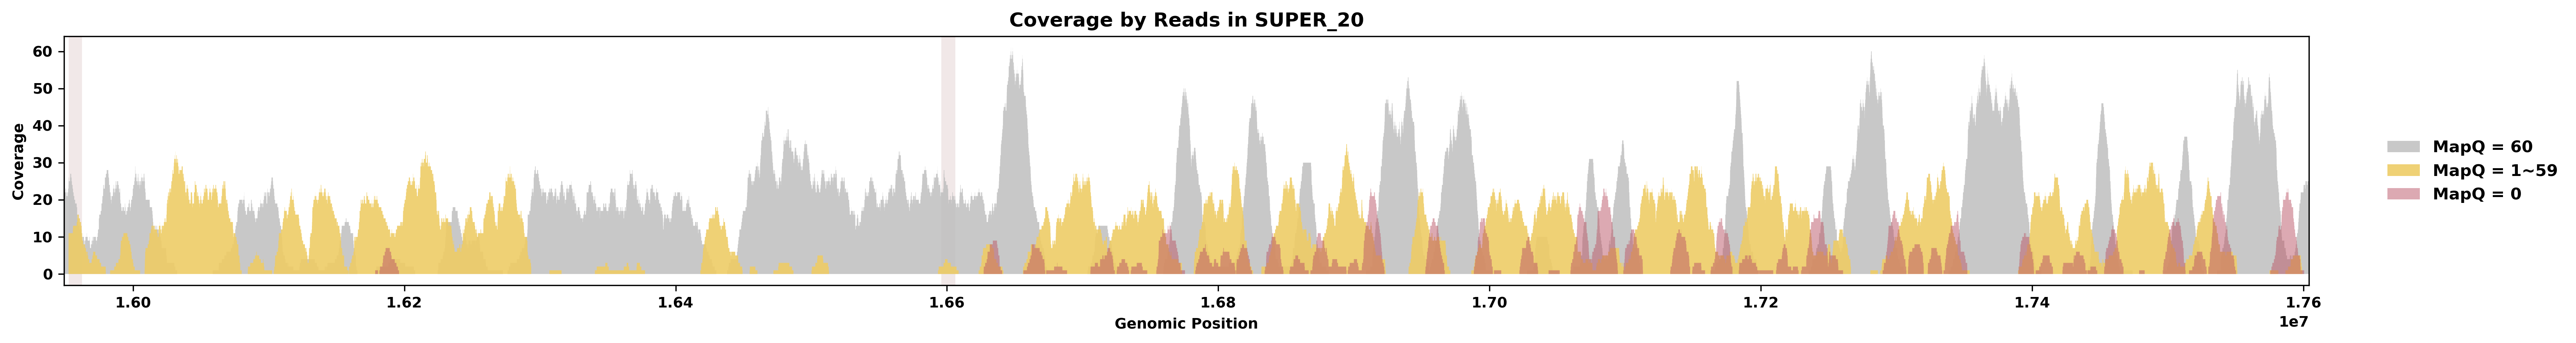

In [52]:
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
color60 = "#BBBBBB"
colormid = "#EECC66"
color0 = "#BB5566"

CovPlt, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 3), dpi=300)
# Plot the results
for start, end in zip(start_indices_pri, end_indices_pri):
    axes.axvspan(start, end if end != high_mismatch_bool_pri.size else positions_pri[-1], facecolor='rosybrown', alpha=0.2, zorder=0)  
for start, end in zip(start_break_pri, end_break_pri):
    if end - start < 5000:
        axes.axvspan(start-3005, end+3005, facecolor='purple', alpha=0.7)
    else: 
        axes.axvspan(start, end, facecolor='purple', alpha=0.7)

axes.fill_between(positions_pri, coverage_counts_pri, step="pre", alpha=0.8, label='MapQ = 60', facecolor=color60, zorder=0.5)
axes.fill_between(positions_pri, mid_counts_pri, step="pre", alpha=0.9, label='MapQ = 1~59', facecolor = colormid, zorder=0.5)
axes.fill_between(positions_pri, zero_counts_pri, step="pre", alpha=0.5, label='MapQ = 0', facecolor = color0, zorder=0.5)
axes.set_title(f'Coverage by Reads in {chr1}', fontweight='bold', size=12)
axes.set_xlabel('Genomic Position')
axes.set_ylabel('Coverage')
axes.set_xlim(min_position_pri, max_position_pri)
#axes.set_xticks([])

CovPlt.legend(loc="center right", bbox_to_anchor=(1.1, 0.5), frameon=False)
plt.tight_layout()
plt.savefig(f'{dirOut}/{gene}.pri1.readcoverage.all.png', format="png", dpi=300, bbox_inches='tight')
plt.show()

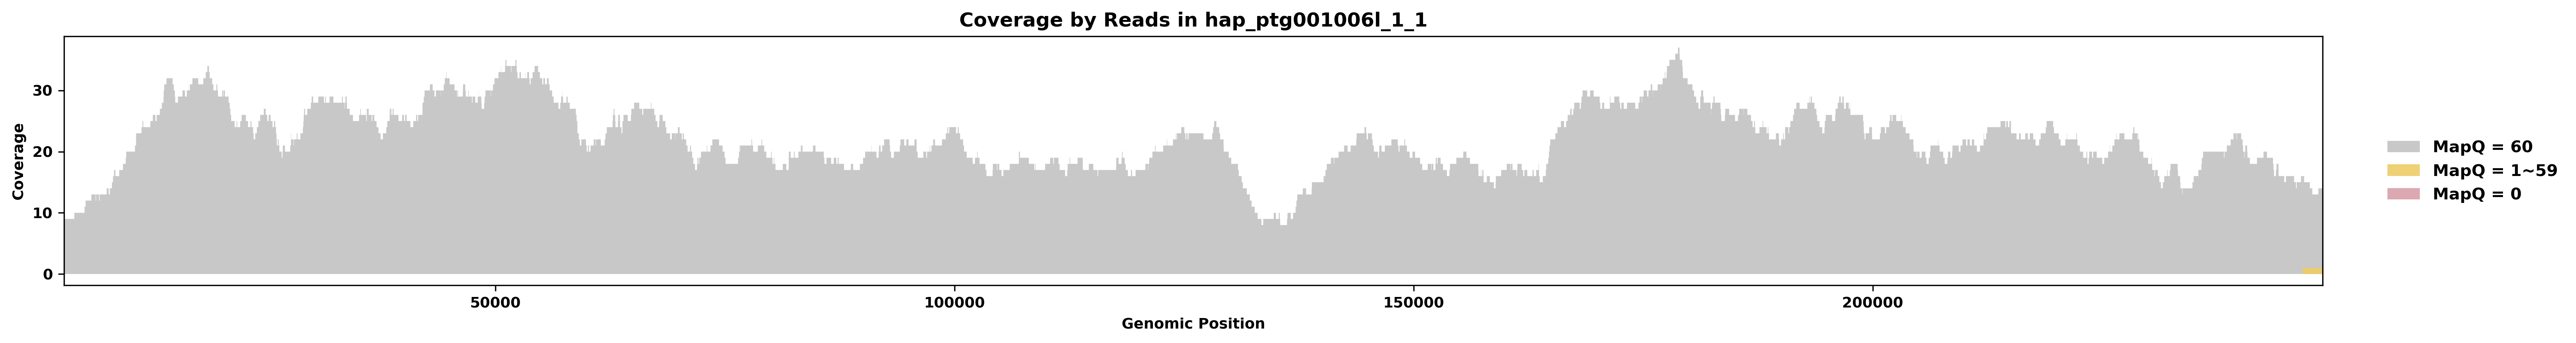

In [61]:
if not haploid:
    CovPlt, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 3), dpi=300)
    # Plot the results
    for start, end in zip(start_indices_alt, end_indices_alt):
        axes.axvspan(start, end if end != high_mismatch_bool_alt.size else positions_alt[-1], facecolor='rosybrown', alpha=0.2, zorder=0)  
    for start, end in zip(start_break_alt, end_break_alt):
        if end - start < 5000:
            axes.axvspan(start-3005, end+3005, facecolor='purple', alpha=0.7)
        else: 
            axes.axvspan(start, end, facecolor='purple', alpha=0.7)
    
    axes.fill_between(positions_alt, coverage_counts_alt, step="pre", alpha=0.8, label='MapQ = 60', facecolor=color60, zorder=0.5)
    axes.fill_between(positions_alt, mid_counts_alt, step="pre", alpha=0.9, label='MapQ = 1~59', facecolor = colormid, zorder=0.5)
    axes.fill_between(positions_alt, zero_counts_alt, step="pre", alpha=0.5, label='MapQ = 0', facecolor = color0, zorder=0.5)
    axes.set_title(f'Coverage by Reads in {chr6}', fontweight='bold', size=12)
    axes.set_xlabel('Genomic Position')
    axes.set_ylabel('Coverage')
    axes.set_xlim(min_position_alt, max_position_alt)
    #axes.set_xticks([])
    
    CovPlt.legend(loc="center right", bbox_to_anchor=(1.1, 0.5), frameon=False)
    plt.tight_layout()
    plt.savefig(f'{dirOut}/{gene}.alt2.readcoverage.all.png', format="png", dpi=300, bbox_inches='tight')
    plt.show()

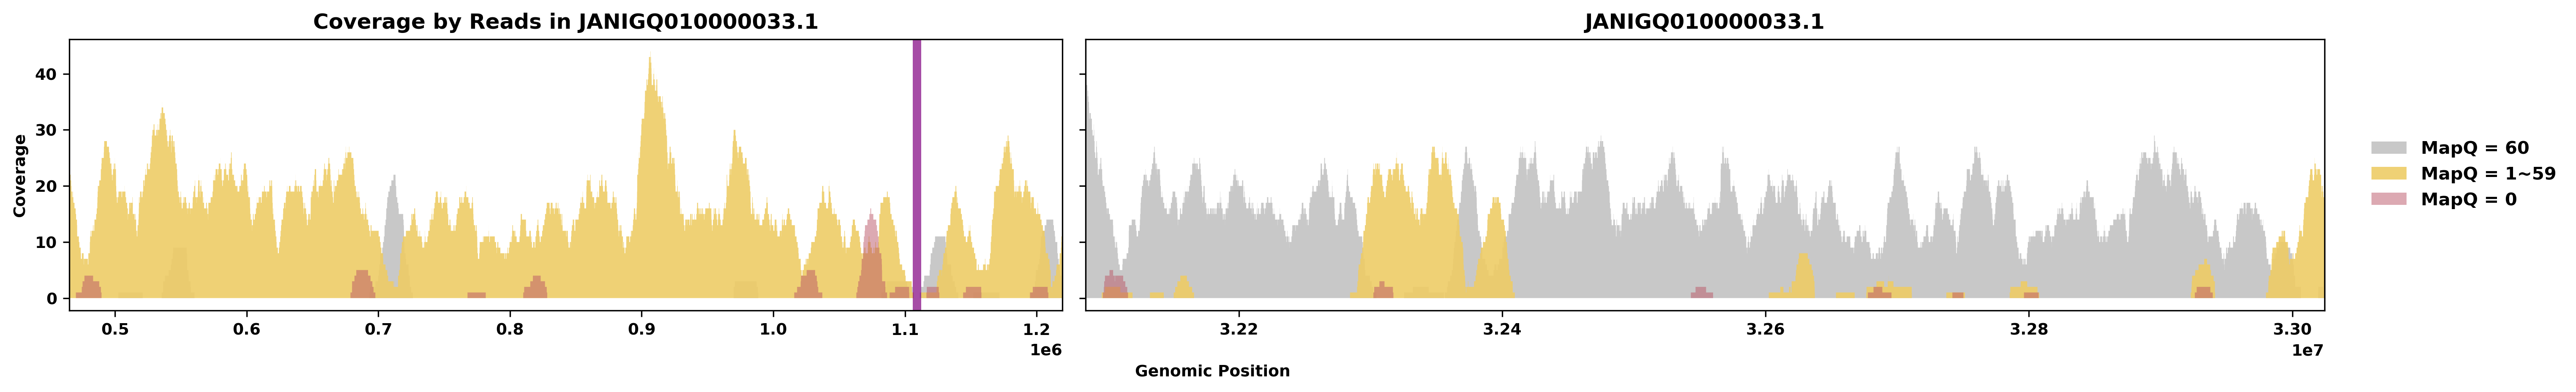

In [34]:
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
color60 = "#BBBBBB"
colormid = "#EECC66"
color0 = "#BB5566"

altLen = max_position_pri - min_position_pri
altLen_4 = max_position_alt - min_position_alt

CovPlt, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 3), dpi=300, gridspec_kw={'width_ratios': [altLen, altLen_4]}, sharey=True)
# Plot the results
for start, end in zip(start_indices_pri, end_indices_pri):
    axes[0].axvspan(start, end if end != high_mismatch_bool_pri.size else positions_pri[-1], facecolor='rosybrown', alpha=0.2, zorder=0)  
for start, end in zip(start_break_pri, end_break_pri):
    if end - start < 5000:
        axes[0].axvspan(start-3005, end+3005, facecolor='purple', alpha=0.7)
    else: 
        axes[0].axvspan(start, end, facecolor='purple', alpha=0.7)

axes[0].fill_between(positions_pri, coverage_counts_pri, step="pre", alpha=0.8, label='MapQ = 60', facecolor=color60, zorder=0.5)
axes[0].fill_between(positions_pri, mid_counts_pri, step="pre", alpha=0.9, label='MapQ = 1~59', facecolor = colormid, zorder=0.5)
axes[0].fill_between(positions_pri, zero_counts_pri, step="pre", alpha=0.5, label='MapQ = 0', facecolor = color0, zorder=0.5)
axes[0].set_title(f'Coverage by Reads in {chr1}', fontweight='bold', size=12)
axes[0].set_xlabel('')
axes[0].set_ylabel('Coverage')
axes[0].set_xlim(min_position_pri, max_position_pri)
#axes.set_xticks([])



for start, end in zip(start_indices_alt, end_indices_alt):
    axes[1].axvspan(start, end if end != high_mismatch_bool_alt.size else positions_alt[-1], facecolor='rosybrown', alpha=0.2, zorder=0)  
for start, end in zip(start_break_alt, end_break_alt):
    if end - start < 5000:
        axes[1].axvspan(start-3005, end+3005, facecolor='purple', alpha=0.7)
    else: 
        axes[1].axvspan(start, end, facecolor='purple', alpha=0.7)

axes[1].fill_between(positions_alt, coverage_counts_alt, step="pre", alpha=0.8, label='MapQ = 60', facecolor=color60, zorder=0.5)
axes[1].fill_between(positions_alt, mid_counts_alt, step="pre", alpha=0.9, label='MapQ = 1~59', facecolor = colormid, zorder=0.5)
axes[1].fill_between(positions_alt, zero_counts_alt, step="pre", alpha=0.5, label='MapQ = 0', facecolor = color0, zorder=0.5)
axes[1].set_title(f'{chr2}', fontweight='bold', size=12)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_xlim(min_position_alt, max_position_alt)


CovPlt.text(0.48, -0.01, 'Genomic Position', ha='center', va='bottom')

axes[1].legend(loc="center right", bbox_to_anchor=(1.2, 0.5), frameon=False)
plt.tight_layout()
plt.savefig(f'{dirOut}/{gene}.pri.comb.readcoverage.all.png', format="png", dpi=300, bbox_inches='tight')
plt.show()

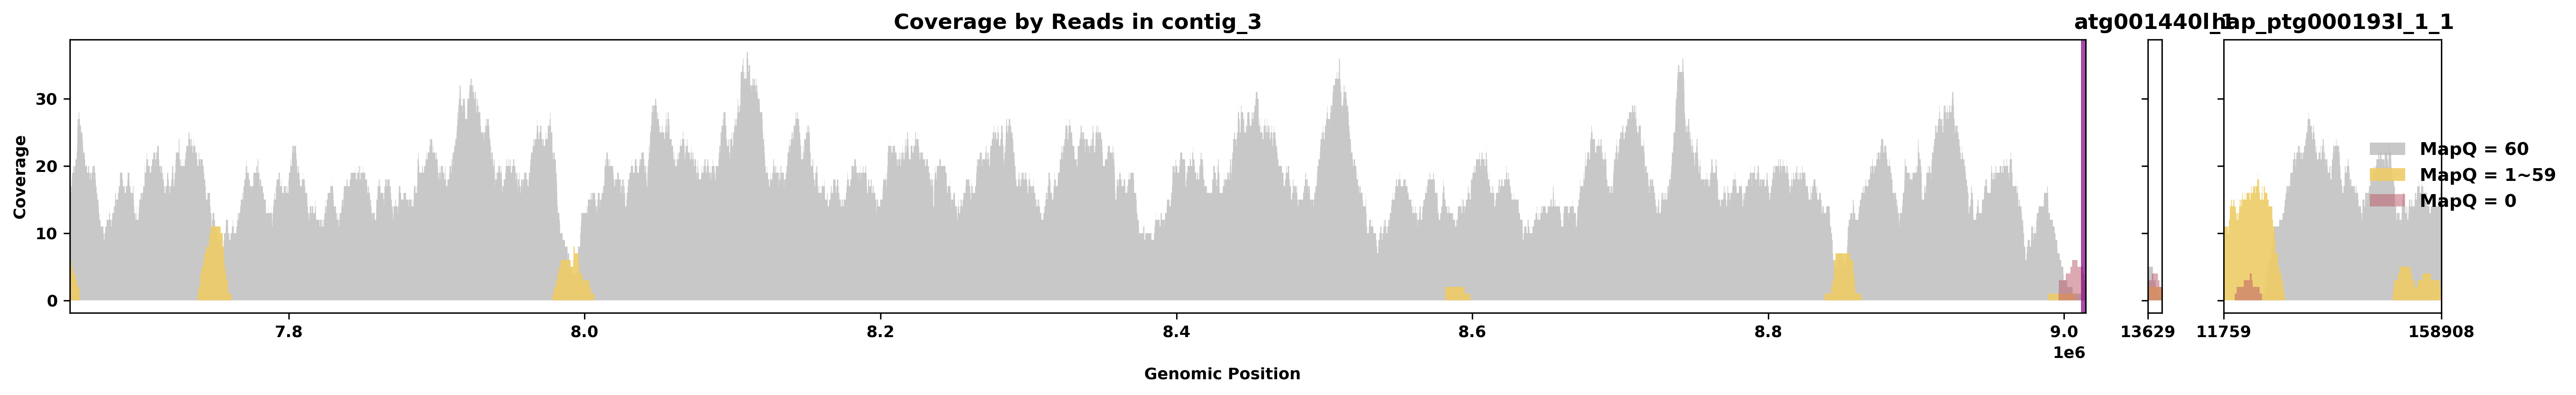

In [21]:
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
color60 = "#BBBBBB"
colormid = "#EECC66"
color0 = "#BB5566"

altLen = max_position_alt - min_position_alt
altLen_4 = max_position_alt_4 - min_position_alt_4
altLen_6 = max_position_alt_6 - min_position_alt_6

CovPlt, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 3), dpi=300, gridspec_kw={'width_ratios': [altLen, altLen_4, altLen_6]}, sharey=True)
# Plot the results
for start, end in zip(start_indices_alt, end_indices_alt):
    axes[0].axvspan(start, end if end != high_mismatch_bool_alt.size else positions_alt[-1], facecolor='rosybrown', alpha=0.2, zorder=0)  
for start, end in zip(start_break_alt, end_break_alt):
    if end - start < 5000:
        axes[0].axvspan(start-3005, end+3005, facecolor='purple', alpha=0.7)
    else: 
        axes[0].axvspan(start, end, facecolor='purple', alpha=0.7)

axes[0].fill_between(positions_alt, coverage_counts_alt, step="pre", alpha=0.8, label='MapQ = 60', facecolor=color60, zorder=0.5)
axes[0].fill_between(positions_alt, mid_counts_alt, step="pre", alpha=0.9, label='MapQ = 1~59', facecolor = colormid, zorder=0.5)
axes[0].fill_between(positions_alt, zero_counts_alt, step="pre", alpha=0.5, label='MapQ = 0', facecolor = color0, zorder=0.5)
axes[0].set_title(f'Coverage by Reads in {chr2}', fontweight='bold', size=12)
axes[0].set_xlabel('')
axes[0].set_ylabel('Coverage')
axes[0].set_xlim(min_position_alt, max_position_alt)
#axes.set_xticks([])



for start, end in zip(start_indices_alt_4, end_indices_alt_4):
    axes[1].axvspan(start, end if end != high_mismatch_bool_alt_4.size else positions_alt_4[-1], facecolor='rosybrown', alpha=0.2, zorder=0)  
for start, end in zip(start_break_alt_4, end_break_alt_4):
    if end - start < 5000:
        axes[1].axvspan(start-3005, end+3005, facecolor='purple', alpha=0.7)
    else: 
        axes[1].axvspan(start, end, facecolor='purple', alpha=0.7)

axes[1].fill_between(positions_alt_4, coverage_counts_alt_4, step="pre", alpha=0.8, label='MapQ = 60', facecolor=color60, zorder=0.5)
axes[1].fill_between(positions_alt_4, mid_counts_alt_4, step="pre", alpha=0.9, label='MapQ = 1~59', facecolor = colormid, zorder=0.5)
axes[1].fill_between(positions_alt_4, zero_counts_alt_4, step="pre", alpha=0.5, label='MapQ = 0', facecolor = color0, zorder=0.5)
axes[1].set_title(f'{chr4}', fontweight='bold', size=12)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_xlim(min_position_alt_4, max_position_alt_4)
axes[1].set_xticks([min_position_alt_4])


for start, end in zip(start_indices_alt_6, end_indices_alt_6):
    axes[2].axvspan(start, end if end != high_mismatch_bool_alt_6.size else positions_alt_6[-1], facecolor='rosybrown', alpha=0.2, zorder=0)  
for start, end in zip(start_break_alt_6, end_break_alt_6):
    if end - start < 5000:
        axes[2].axvspan(start-3005, end+3005, facecolor='purple', alpha=0.7)
    else:
        axes[2].axvspan(start, end, facecolor='purple', alpha=0.7)

axes[2].fill_between(positions_alt_6, coverage_counts_alt_6, step="pre", alpha=0.8, label='MapQ = 60', facecolor=color60, zorder=0.5)
axes[2].fill_between(positions_alt_6, mid_counts_alt_6, step="pre", alpha=0.9, label='MapQ = 1~59', facecolor = colormid, zorder=0.5)
axes[2].fill_between(positions_alt_6, zero_counts_alt_6, step="pre", alpha=0.5, label='MapQ = 0', facecolor = color0, zorder=0.5)
axes[2].set_title(f'{chr6}', fontweight='bold', size=12)
axes[2].set_xlabel('')
axes[2].set_ylabel('')
axes[2].set_xlim(min_position_alt_6, max_position_alt_6)
axes[2].set_xticks([min_position_alt_6, max_position_alt_6])

CovPlt.text(0.48, -0.01, 'Genomic Position', ha='center', va='bottom')

axes[2].legend(loc="center right", bbox_to_anchor=(1.6, 0.5), frameon=False)
plt.tight_layout()
plt.savefig(f'{dirOut}/{gene}.alt.comb.readcoverage.all.png', format="png", dpi=300, bbox_inches='tight')
plt.show()

## Basepair level accuracy

### Coverage

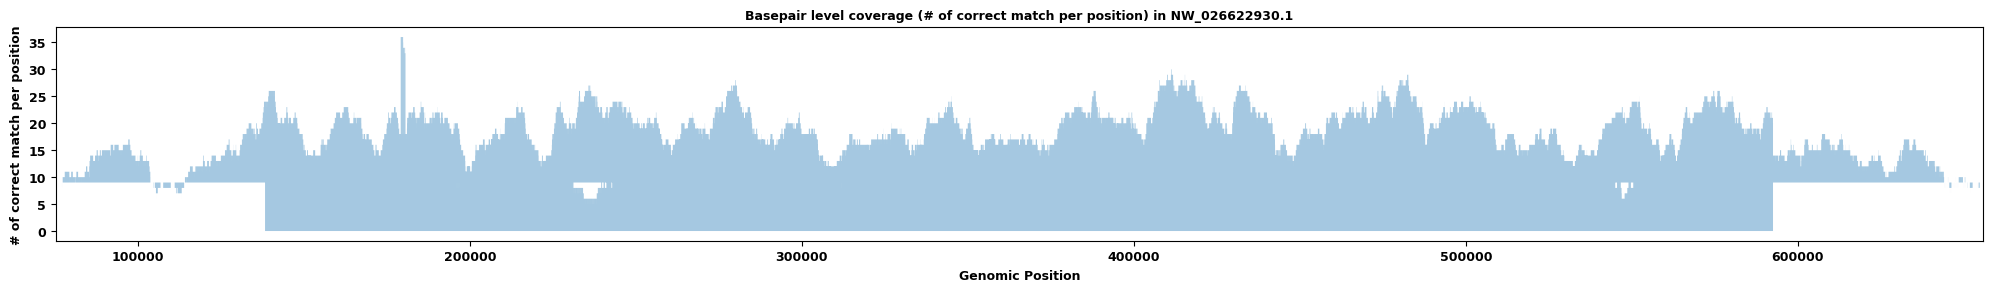

In [38]:
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
if not haploid:
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 6))
    for start, end in zip(start_indices_pri, end_indices_pri):
        axes[0].axvspan(start, end if end != high_mismatch_bool_pri.size else positions_pri[-1], facecolor='rosybrown', alpha=0.2, zorder=0)  
    for start, end in zip(start_break_pri, end_break_pri):
        if end - start < 5000:
            axes[0].axvspan(start-3005, end+3005, facecolor='purple', alpha=0.7)
        else: 
            axes[0].axvspan(start, end, facecolor='purple', alpha=0.7)
    
    for start, end in zip(start_indices_alt, end_indices_alt):
        axes[1].axvspan(start, end if end != high_mismatch_bool_alt.size else positions_alt[-1], facecolor='rosybrown', alpha=0.2, zorder=0)  
    for start, end in zip(start_break_alt, end_break_alt):
        if end - start < 5000:
            axes[1].axvspan(start-3005, end+3005, facecolor='purple', alpha=0.7)
        else: 
            axes[1].axvspan(start, end, facecolor='purple', alpha=0.7)
    axes[0].fill_between(pri_pileup['Pos'], pri_pileup['Correct'], step="pre", alpha=0.4)
    axes[1].fill_between(alt_pileup['Pos'], alt_pileup['Correct'], step="pre", alpha=0.4)
    axes[0].set_title(f'Basepair level coverage (# of correct match per position) in {chr1}', fontweight='bold')
    axes[1].set_title(f'Basepair level coverage (# of correct match per position) in {chr2}', fontweight='bold')
    axes[0].set_xlabel('Genomic Position')
    axes[0].set_ylabel('# of correct match per position')
    axes[1].set_xlabel('Genomic Position')
    axes[1].set_ylabel('# of correct match per position')
    plt.tight_layout()
    axes[0].margins(x=0)
    axes[1].margins(x=0)
    plt.savefig(f'{dirOut}/{gene}.basecoverage.numCorrect.png', format="png", dpi=300, bbox_inches='tight')
    plt.show()
else:
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 3))
    for start, end in zip(start_indices_pri, end_indices_pri):
        axes.axvspan(start, end if end != high_mismatch_bool_pri.size else positions_pri[-1], facecolor='rosybrown', alpha=0.2, zorder=0)  
    for start, end in zip(start_break_pri, end_break_pri):
        if end - start < 5000:
            axes.axvspan(start-3005, end+3005, facecolor='purple', alpha=0.7)
        else: 
            axes.axvspan(start, end, facecolor='purple', alpha=0.7)
    
    axes.fill_between(pri_pileup['Pos'], pri_pileup['Correct'], step="pre", alpha=0.4)
    axes.set_title(f'Basepair level coverage (# of correct match per position) in {chr1}', fontweight='bold')
    axes.set_xlabel('Genomic Position')
    axes.set_ylabel('# of correct match per position')
    plt.tight_layout()
    axes.margins(x=0)
    plt.savefig(f'{dirOut}/{gene}.basecoverage.numCorrect.png', format="png", dpi=300, bbox_inches='tight')
    plt.show()

### Mismatch

In [42]:
#pri_pileup_1 = pri_pileup[pri_pileup['Pos'] < 1219900]
#pri_pileup_3 = pri_pileup[pri_pileup['Chrom'] == chr3 ]
#pri_pileup_5 = pri_pileup[pri_pileup['Chrom'] == chr5 ]

pri_pileup_100 = pri_pileup_1[pri_pileup_1['PercentCorrect'] > 80]
pri_pileup_100['Bin_Start_Pos'] = (pri_pileup_100['Pos'] // 1000) * 1000
bin_count = pri_pileup_100.groupby('Bin_Start_Pos').size()
bin_count = pd.DataFrame(bin_count, columns=["zeroCount"])
bin_count["Zero Error"] = bin_count["zeroCount"]/1000*100
bin_count=bin_count.reset_index()
if not haploid:
    alt_pileup_100 = alt_pileup[alt_pileup['PercentCorrect'] > 80]
    alt_pileup_100['Bin_Start_Pos'] = (alt_pileup_100['Pos'] // 1000) * 1000
    alt_bin_count = alt_pileup_100.groupby('Bin_Start_Pos').size()
    alt_bin_count = pd.DataFrame(alt_bin_count, columns=["zeroCount"])
    alt_bin_count["Zero Error"] = alt_bin_count["zeroCount"]/1000*100
    alt_bin_count=alt_bin_count.reset_index()
    # alt_pileup_100_4 = alt_pileup_4[alt_pileup_4['PercentCorrect'] > 80]
    # alt_pileup_100_4['Bin_Start_Pos'] = (alt_pileup_100_4['Pos'] // 1000) * 1000
    # alt_bin_count_4 = alt_pileup_100_4.groupby('Bin_Start_Pos').size()
    # alt_bin_count_4 = pd.DataFrame(alt_bin_count_4, columns=["zeroCount"])
    # alt_bin_count_4["Zero Error"] = alt_bin_count_4["zeroCount"]/1000*100
    # alt_bin_count_4=alt_bin_count_4.reset_index()

    # alt_pileup_100_6 = alt_pileup_6[alt_pileup_6['PercentCorrect'] > 80]
    # alt_pileup_100_6['Bin_Start_Pos'] = (alt_pileup_100_6['Pos'] // 1000) * 1000
    # alt_bin_count_6 = alt_pileup_100_6.groupby('Bin_Start_Pos').size()
    # alt_bin_count_6 = pd.DataFrame(alt_bin_count_6, columns=["zeroCount"])
    # alt_bin_count_6["Zero Error"] = alt_bin_count_6["zeroCount"]/1000*100
    # alt_bin_count_6 =alt_bin_count_6.reset_index()

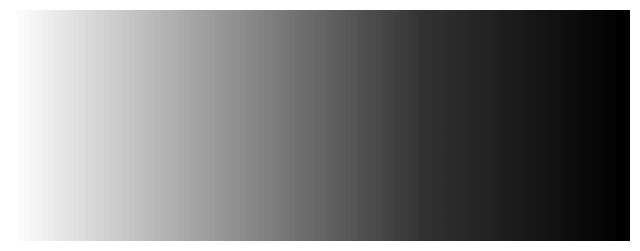

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Define the colors for the colormap
colors = [(1, 1, 1), (0.6, 0.6, 0.6), (0.2, 0.2, 0.2), (0, 0, 0)]  # white to light red to red
n_bins = 100  # Number of bins in the colormap
cmap_name = 'custom_red'

# Create the color map
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Test the colormap
plt.figure(figsize=(8, 3))
plt.imshow(np.linspace(0, 100, 256).reshape(1, -1), cmap=cm, aspect='auto')
plt.axis('off')
plt.show()


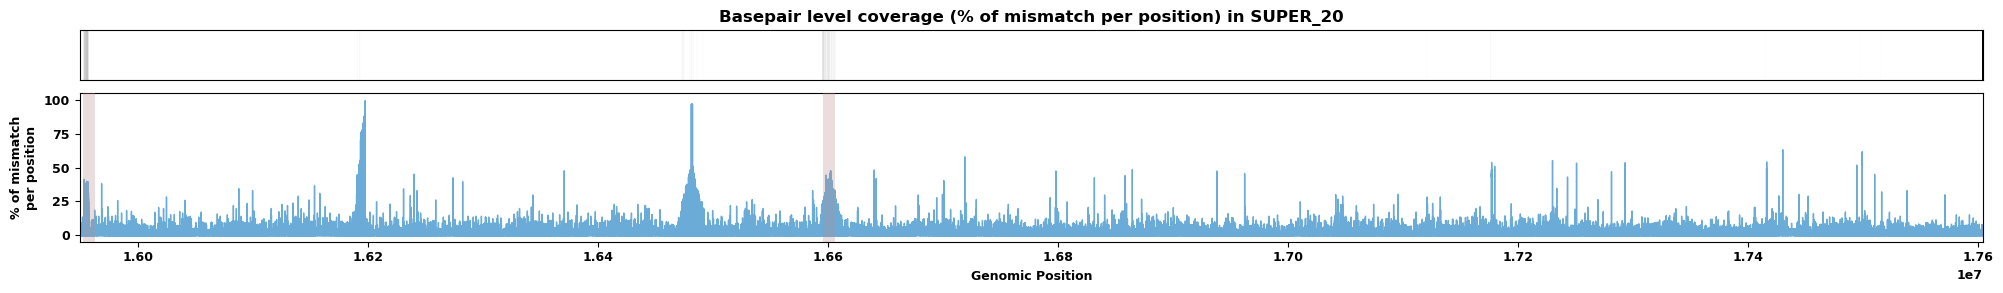

In [56]:
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 1000000000
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
priMis, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 3), gridspec_kw={'height_ratios': [1, 3]})
for start, end in zip(start_indices_pri, end_indices_pri):
    axes[1].axvspan(start, end if end != high_mismatch_bool_pri.size else positions_pri[-1], facecolor='rosybrown', alpha=0.3, zorder=3)  
for start, end in zip(start_break_pri, end_break_pri):
    if end - start < 5000:
        axes[1].axvspan(start-3005, end+3005, facecolor='purple', alpha=0.7, zorder=3)
    else: 
        axes[1].axvspan(start, end, facecolor='purple', alpha=0.7, zorder=3)
axes[1].fill_between(pri_pileup_1['Pos'], 100 - pri_pileup_1['PercentCorrect'], step="mid", alpha=1, color = chr1_color, zorder=2)
data_matrix = np.array(100-bin_count["Zero Error"])[np.newaxis]
sns.heatmap(data_matrix, ax=axes[0], annot=False, cbar=False, yticklabels=False, cmap=cm, vmin=0, vmax=50, xticklabels=False)
for spine in axes[0].spines.values():
    spine.set_visible(True)
axes[0].set_title(f'Basepair level coverage (% of mismatch per position) in {chr1}', fontweight='bold', size=12)
axes[1].set_xlabel('Genomic Position')
axes[1].set_ylabel('% of mismatch\nper position')
plt.tight_layout()
axes[1].margins(x=0)
plt.savefig(f'{dirOut}/{gene}.pri1.basecoverage.PerCorrect.png', format="png", dpi=300,bbox_inches='tight')
plt.show()

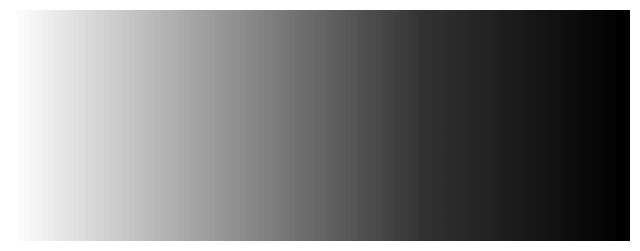

In [38]:
# Define the colors for the colormap
colors = [(1, 1, 1), (0.6, 0.6, 0.6), (0.2, 0.2, 0.2), (0, 0, 0)]  # white to light red to red
n_bins = 100  # Number of bins in the colormap
cmap_name = 'custom_red'

# Create the color map
cm2 = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Test the colormap
plt.figure(figsize=(8, 3))
plt.imshow(np.linspace(0, 100, 256).reshape(1, -1), cmap=cm2, aspect='auto')
plt.axis('off')
plt.show()

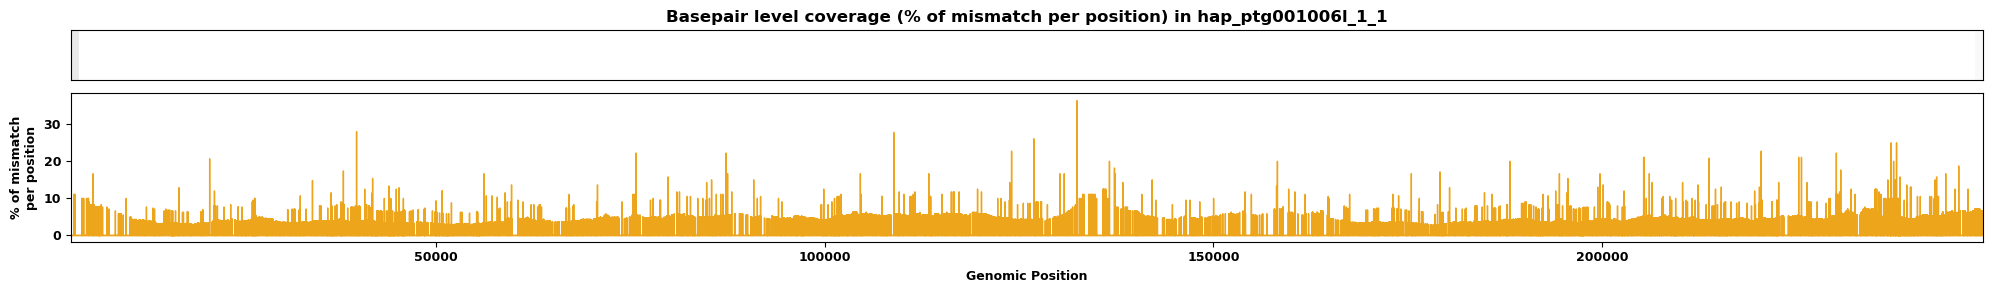

In [63]:
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 100000000000
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
if not haploid:
    altMis, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 3), gridspec_kw={'height_ratios': [1, 3]})
    for start, end in zip(start_indices_alt, end_indices_alt):
        axes[1].axvspan(start, end if end != high_mismatch_bool_alt.size else positions_alt[-1], facecolor='rosybrown', alpha=0.3, zorder=3)  
    for start, end in zip(start_break_alt, end_break_alt):
        if end - start < 5000:
            axes[1].axvspan(start-3005, end+3005, facecolor='purple', alpha=0.7, zorder=3)
        else: 
            axes[1].axvspan(start, end, facecolor='purple', alpha=0.7, zorder=3)
    axes[1].fill_between(alt_pileup_6['Pos'], 100 - alt_pileup_6['PercentCorrect'], step="mid", alpha=1, color = chr6_color, zorder=2)
    data_matrix = np.array(100-alt_bin_count["Zero Error"])[np.newaxis]
    sns.heatmap(data_matrix, ax=axes[0], annot=False, cbar=False, yticklabels=False, cmap=cm2, vmin=0, vmax=50, xticklabels=False)
    for spine in axes[0].spines.values():
        spine.set_visible(True)
    axes[0].set_title(f'Basepair level coverage (% of mismatch per position) in {chr6}', fontweight='bold', size=12)
    axes[1].set_xlabel('Genomic Position')
    axes[1].set_ylabel('% of mismatch\nper position')
    #fig.legend(loc="center right", bbox_to_anchor=(1.1, 0.52), frameon=False)
    plt.tight_layout()
    axes[1].margins(x=0)
    plt.savefig(f'{dirOut}/{gene}.alt2.basecoverage.PerCorrect.png', format="png", dpi=300, bbox_inches='tight')
    plt.show()

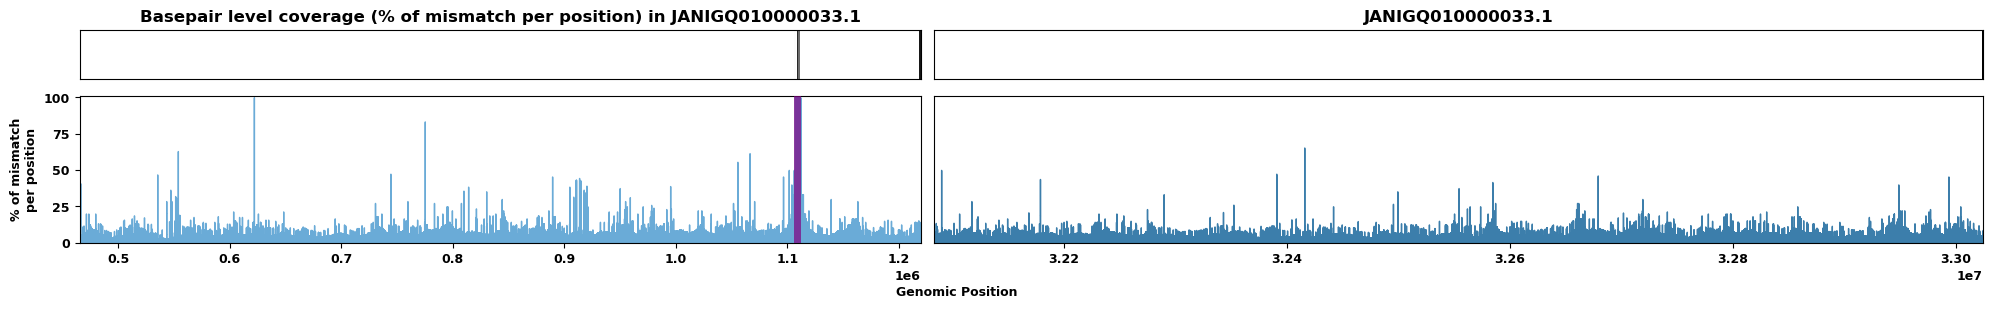

In [57]:

import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 100000000000
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
if not haploid:
    altMis, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 3), gridspec_kw={'height_ratios': [1, 3], 'width_ratios': [altLen, altLen_4]})
    for start, end in zip(start_indices_pri, end_indices_pri):
        axes[1, 0].axvspan(start, end if end != high_mismatch_bool_pri.size else positions_pri[-1], facecolor='rosybrown', alpha=0.3, zorder=3)  
    for start, end in zip(start_break_pri, end_break_pri):
        if end - start < 5000:
            axes[1, 0].axvspan(start-3005, end+3005, facecolor='purple', alpha=0.7, zorder=3)
        else: 
            axes[1, 0].axvspan(start, end, facecolor='purple', alpha=0.7, zorder=3)
    axes[1, 0].fill_between(pri_pileup_1['Pos'], 100 - pri_pileup_1['PercentCorrect'], step="mid", alpha=1, color = chr1_color, zorder=2)
    data_matrix = np.array(100-bin_count["Zero Error"])[np.newaxis]
    sns.heatmap(data_matrix, ax=axes[0, 0], annot=False, cbar=False, yticklabels=False, cmap=cm2, vmin=0, vmax=50, xticklabels=False)
    for spine in axes[0, 0].spines.values():
        spine.set_visible(True)
    axes[0, 0].set_title(f'Basepair level coverage (% of mismatch per position) in {chr1}', fontweight='bold', size=12)
    axes[1, 0].set_xlabel('')
    axes[1, 0].set_ylabel('% of mismatch\nper position')
    #fig.legend(loc="center right", bbox_to_anchor=(1.1, 0.52), frameon=False)
    
    axes[1, 0].margins(x=0)

    for start, end in zip(start_indices_alt, end_indices_alt):
        axes[1, 1].axvspan(start, end if end != high_mismatch_bool_alt.size else positions_alt[-1], facecolor='rosybrown', alpha=0.3, zorder=3)  
    for start, end in zip(start_break_alt, end_break_alt):
        if end - start < 5000:
            axes[1, 1].axvspan(start-3005, end+3005, facecolor='purple', alpha=0.7, zorder=3)
        else: 
            axes[1, 1].axvspan(start, end, facecolor='purple', alpha=0.7, zorder=3)
    axes[1, 1].fill_between(alt_pileup['Pos'], 100 - alt_pileup['PercentCorrect'], step="mid", alpha=1, color = chr3_color, zorder=2)
    data_matrix = np.array(100-alt_bin_count["Zero Error"])[np.newaxis]
    sns.heatmap(data_matrix, ax=axes[0, 1], annot=False, cbar=False, yticklabels=False, cmap=cm2, vmin=0, vmax=50, xticklabels=False)
    for spine in axes[0, 1].spines.values():
        spine.set_visible(True)
    axes[0, 1].set_title(f'{chr2}', fontweight='bold', size=12)
    axes[1, 1].set_xlabel('')
    axes[1, 1].set_ylabel('')
    #fig.legend(loc="center right", bbox_to_anchor=(1.1, 0.52), frameon=False)    
    axes[1, 1].margins(x=0)
    axes[1, 1].set_ylim(0, 101)
    axes[1, 0].set_ylim(0, 101)
    axes[1, 1].set_yticks([])
    altMis.text(0.48, -0.01, 'Genomic Position', ha='center', va='bottom')


    plt.tight_layout()
    plt.savefig(f'{dirOut}/{gene}.pri.comb.basecoverage.PerCorrect.png', format="png", dpi=300, bbox_inches='tight')
    plt.show()
    
    

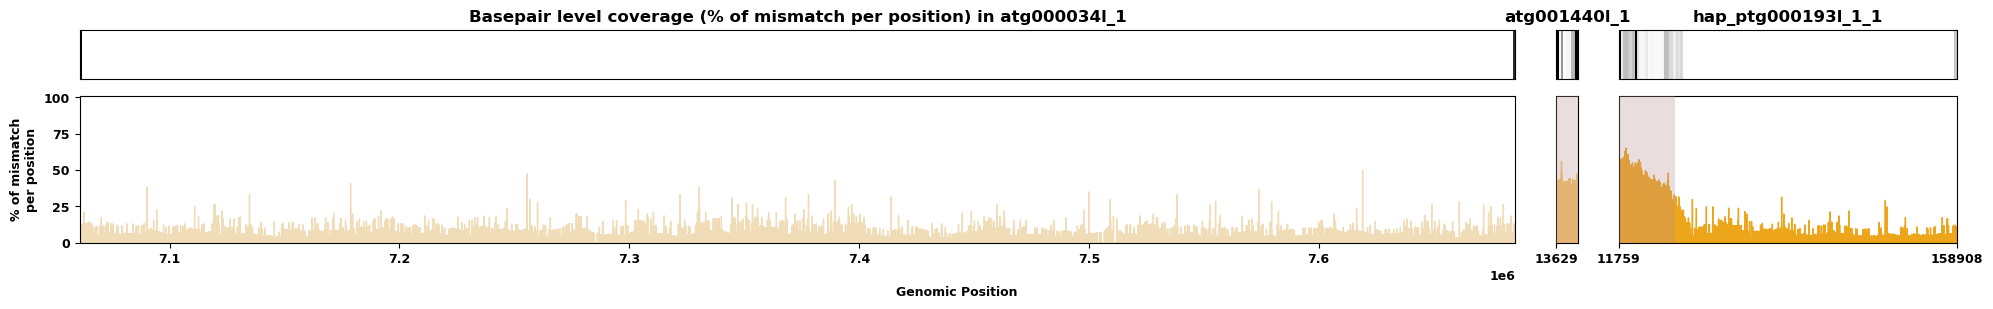

In [55]:
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 100000000000
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
if not haploid:
    altMis, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 3), gridspec_kw={'height_ratios': [1, 3], 'width_ratios': [altLen, altLen_4, altLen_6]})
    for start, end in zip(start_indices_alt, end_indices_alt):
        axes[1, 0].axvspan(start, end if end != high_mismatch_bool_alt.size else positions_alt[-1], facecolor='rosybrown', alpha=0.3, zorder=3)  
    for start, end in zip(start_break_alt, end_break_alt):
        if end - start < 5000:
            axes[1, 0].axvspan(start-3005, end+3005, facecolor='purple', alpha=0.7, zorder=3)
        else: 
            axes[1, 0].axvspan(start, end, facecolor='purple', alpha=0.7, zorder=3)
    axes[1, 0].fill_between(alt_pileup['Pos'], 100 - alt_pileup['PercentCorrect'], step="mid", alpha=1, color = chr2_color, zorder=2)
    data_matrix = np.array(100-alt_bin_count["Zero Error"])[np.newaxis]
    sns.heatmap(data_matrix, ax=axes[0, 0], annot=False, cbar=False, yticklabels=False, cmap=cm2, vmin=0, vmax=50, xticklabels=False)
    for spine in axes[0, 0].spines.values():
        spine.set_visible(True)
    axes[0, 0].set_title(f'Basepair level coverage (% of mismatch per position) in {chr2}', fontweight='bold', size=12)
    axes[1, 0].set_xlabel('')
    axes[1, 0].set_ylabel('% of mismatch\nper position')
    #fig.legend(loc="center right", bbox_to_anchor=(1.1, 0.52), frameon=False)
    
    axes[1, 0].margins(x=0)

    for start, end in zip(start_indices_alt_4, end_indices_alt_4):
        axes[1, 1].axvspan(start, end if end != high_mismatch_bool_alt_4.size else positions_alt_4[-1], facecolor='rosybrown', alpha=0.3, zorder=3)  
    for start, end in zip(start_break_alt_4, end_break_alt_4):
        if end - start < 5000:
            axes[1, 1].axvspan(start-3005, end+3005, facecolor='purple', alpha=0.7, zorder=3)
        else: 
            axes[1, 1].axvspan(start, end, facecolor='purple', alpha=0.7, zorder=3)
    axes[1, 1].fill_between(alt_pileup_4['Pos'], 100 - alt_pileup_4['PercentCorrect'], step="mid", alpha=1, color = chr4_color, zorder=2)
    data_matrix = np.array(100-alt_bin_count_4["Zero Error"])[np.newaxis]
    sns.heatmap(data_matrix, ax=axes[0, 1], annot=False, cbar=False, yticklabels=False, cmap=cm2, vmin=0, vmax=50, xticklabels=False)
    for spine in axes[0, 1].spines.values():
        spine.set_visible(True)
    axes[0, 1].set_title(f'{chr4}', fontweight='bold', size=12)
    axes[1, 1].set_xlabel('')
    axes[1, 1].set_ylabel('')
    #fig.legend(loc="center right", bbox_to_anchor=(1.1, 0.52), frameon=False)    
    axes[1, 1].set_ylim(0, 101)
    axes[1, 0].set_ylim(0, 101)
    axes[1, 2].set_ylim(0, 101)
    axes[1, 1].set_yticks([])
    axes[1, 1].margins(x=0)
    axes[1, 1].set_xticks([min_position_alt_4])
    axes[1, 1].set_xlim(min_position_alt_4, max_position_alt_4)

    for start, end in zip(start_indices_alt_6, end_indices_alt_6):
        axes[1, 2].axvspan(start, end if end != high_mismatch_bool_alt_6.size else positions_alt_6[-1], facecolor='rosybrown', alpha=0.3, zorder=3)  
    for start, end in zip(start_break_alt_6, end_break_alt_6):
        if end - start < 5000:
            axes[1, 2].axvspan(start-3005, end+3005, facecolor='purple', alpha=0.7, zorder=3)
        else: 
            axes[1, 2].axvspan(start, end, facecolor='purple', alpha=0.7, zorder=3)
    axes[1, 2].fill_between(alt_pileup_6['Pos'], 100 - alt_pileup_6['PercentCorrect'], step="mid", alpha=1, color = chr6_color, zorder=2)
    data_matrix = np.array(100-alt_bin_count_6["Zero Error"])[np.newaxis]
    sns.heatmap(data_matrix, ax=axes[0, 2], annot=False, cbar=False, yticklabels=False, cmap=cm2, vmin=0, vmax=50, xticklabels=False)
    for spine in axes[0, 2].spines.values():
        spine.set_visible(True)
    axes[0, 2].set_title(f'{chr6}', fontweight='bold', size=12)
    axes[1, 2].set_xlabel('')
    axes[1, 2].set_ylabel('')
    #fig.legend(loc="center right", bbox_to_anchor=(1.1, 0.52), frameon=False)    
    axes[1, 2].set_xlim(min_position_alt_6, max_position_alt_6)
    axes[1, 2].set_yticks([])
    axes[1, 2].set_xticks([min_position_alt_6, max_position_alt_6])
    axes[1, 2].margins(x=0)

    
    altMis.text(0.48, -0.01, 'Genomic Position', ha='center', va='bottom')


    plt.tight_layout()
    plt.savefig(f'{dirOut}/{gene}.alt.comb.basecoverage.PerCorrect.png', format="png", dpi=300, bbox_inches='tight')
    plt.show()
    
    

In [59]:
meta = pd.read_csv("../species_metainfo.csv", sep=",")
LatinName = meta[meta['IndividualID'] == species]['LatinName'].item()
CommonName = meta[meta['IndividualID'] == species]['CommonName'].item()
Source = meta[meta['IndividualID'] == species]['Source'].item()
SourceLink = meta[meta['IndividualID'] == species]['SourceLink'].item()
Haplotype = meta[meta['IndividualID'] == species]['Haplotype Resolved'].item()
if Haplotype == "No":
    hapkind = "Not Haplotype Resolved"
else:
    hapkind = "Haplotype Resolved"

In [72]:
from fpdf import FPDF
from PIL import Image

def make_pdfdi(image_files, output_filename, overlapx=0.87, overlapy=0.01, scale_top=0.75, scale_bottom=0.3):
    # Ensure all required images are provided
    if len(image_files) < 5:
        raise ValueError("Insufficient image files provided.")

    # Open the first image to get dimensions
    first_image = Image.open(image_files[0])
    width, height = first_image.size
    first_width = width * 0.95
    first_height = height* 0.95
    pagewidth = width*1.15
    # Create instance of FPDF class, adjust the page size based on expected content
    pdf = PDF(unit="pt", format=[pagewidth, height * 3.5])  # Increased page height to fit vertical stacking
    pdf.add_page()
    
    pdf.set_font("Arial", 'B', 32)  # Bold Arial, 24 pt
    pdf.set_text_color(0, 0, 0)  # Black text
    # Add the first image at full scale
    pdf.image(image_files[0], 850, 50, first_width, first_height)

    # Open the second image to get dimensions and calculate new dimensions based on the scale
    second_image = Image.open(image_files[1])
    second_width, second_height = second_image.size
    new_width_top = second_width * scale_top
    new_height_top = second_height * scale_top

    # Add the second image, resized and positioned with overlap
    overlap_x = width * overlapx
    overlap_y = height * overlapy
    pdf.image(image_files[1], x=overlap_x+850, y=overlap_y+50, w=new_width_top, h=new_height_top)

    initial_y_position_below = first_height + 100
    # Add images below x and y, vertically stacked
    current_y = initial_y_position_below
    img = Image.open(image_files[2])
    orig_width, orig_height = img.size
    scaled_width = width*0.933 # Scale each image to fit the page width
    scaled_height = orig_height * (scaled_width / orig_width)  # Maintain aspect ratio
    pdf.image(image_files[2], x=800, y=current_y, w=scaled_width, h=scaled_height)
    current_y += scaled_height  # Update the y position for the next image
    for image_path in image_files[3:8]:
        if image_path == image_files[3]:
            img = Image.open(image_path)
            orig_width, orig_height = img.size
            scaled_width = width * 0.85  # Scale each image to fit the page width
            scaled_height = orig_height * (scaled_width / orig_width)  # Maintain aspect ratio
            pdf.image(image_path, x=780, y=current_y, w=scaled_width, h=scaled_height)
            current_y += scaled_height  # Update the y position for the next image
        elif image_path == image_files[5] or image_path == image_files[7]:
            img = Image.open(image_path)
            orig_width, orig_height = img.size
            scaled_width = width * 0.85  # Scale each image to fit the page width
            scaled_height = orig_height * (scaled_width / orig_width)  # Maintain aspect ratio
            pdf.image(image_path, x=760, y=current_y, w=scaled_width, h=scaled_height)
            current_y += scaled_height  # Update the y position for the next image
        else:
            img = Image.open(image_path)
            orig_width, orig_height = img.size
            scaled_width = width * 0.925  # Scale each image to fit the page width
            scaled_height = orig_height * (scaled_width / orig_width)  # Maintain aspect ratio
            pdf.image(image_path, x=800, y=current_y, w=scaled_width, h=scaled_height)
            current_y += scaled_height  # Update the y position for the next image
            
    textv = [chr1, chr2, chr4, chr2, chr4]
    texth = [chr1, chr2, chr4, chr1, chr1]
    current_y = first_height - 500
    cropamount = 0
    i = 0
    for image_path in image_files[8:13]:
        img = Image.open(image_path)
        if image_path == image_files[8]:
            cropamount = img.size[1]//8.2
        area = (0, cropamount, img.size[0], img.size[1]) 
        cropped_img = img.crop(area)
        dir_name, filename = os.path.split(image_path)
        new_filename = 'cropped_' + filename
        cropped_img_path = os.path.join(dir_name, new_filename)
        cropped_img.save(cropped_img_path)
        orig_width, orig_height = cropped_img.size
        scaled_width = 650  # Scale each image to fit the page height
        scaled_height = orig_height * (scaled_width / orig_width)  # Maintain aspect ratio
        pdf.image(cropped_img_path, x=0, y=current_y, w=scaled_width, h=scaled_height)
        pdf.set_y(current_y+scaled_height+5)
        pdf.cell(350)
        pdf.cell(10, 50, texth[i], 0, 1, 'C')
        pdf.set_y(current_y+150+scaled_height/2)
        pdf.cell(15)
        pdf.rotate(270, x=15, y=current_y+150+scaled_height/2)  
        pdf.cell(10, 50, textv[i], 0, 1, 'L')
        pdf.stop_rotation()  # Stop the rotation for subsequent elements
        current_y += scaled_height + 50  # Update the y position for the next image
        i += 1

    
    pdf.set_font("Arial", '', 36)  
    title = f"Species ID: {species}"
    commonName = f"Common Name: {CommonName}"
    sciName = f"Scientific Name: {LatinName}"
    hap = f"Assembly Type: {hapkind}"
    source = f"Data Source: {Source}"
    title_width = pdf.get_string_width(title) + 6
    pdf.set_y(100)
    pdf.cell(125)
    pdf.cell(title_width, 20, title, 0, 1, 'L')
    pdf.set_y(200)
    pdf.cell(125)
    pdf.cell(title_width, 20, commonName, 0, 1, 'L')
    pdf.set_y(300)
    pdf.cell(125)
    pdf.cell(title_width, 20, sciName, 0, 1, 'L')
    pdf.set_y(400)
    pdf.cell(125)
    pdf.cell(title_width, 20, hap, 0, 1, 'L')
    pdf.set_y(500)
    pdf.cell(125)
    pdf.cell(title_width, 20, source, 0, 1, 'L')
        
    # Save the result to a PDF file
    pdf.output(output_filename)

image_files = [
    f'{dirOut}/{gene}.summary.allreads.png', 
    f'{dirOut}/{gene}.length.png', 
    f'{dirOut}/{gene}.pri1.readcoverage.all.png',
    f'{dirOut}/{gene}.pri1.basecoverage.PerCorrect.png',
    f'{dirOut}/{gene}.alt.readcoverage.all.png',
    f'{dirOut}/{gene}.alt.basecoverage.PerCorrect.png',
    f'{dirOut}/{gene}.alt1.readcoverage.all.png',
    f'{dirOut}/{gene}.alt1.basecoverage.PerCorrect.png',
    f'{dirOut}/{species}.{gene}.primary.primary0.png',
    f'{dirOut}/{species}.{gene}.alternate.alternate0.png',
    f'{dirOut}/{species}.{gene}.alternate.alternate10.png',
    f'{dirOut}/{species}.{gene}.primary.alternate0.png',
    f'{dirOut}/{species}.{gene}.primary.alternate10.png',
]
output_filename = f"../errorPlots/{species}/{species}_{gene}_result.pdf"
#if not haploid:
make_pdfdi(image_files, output_filename, overlapx=0.8, overlapy=0.01, scale_top=0.7, scale_bottom=0.3)


In [38]:
from fpdf import FPDF
from PIL import Image

def make_pdfdi(image_files, output_filename, overlapx=0.87, overlapy=0.01, scale_top=0.75, scale_bottom=0.3):
    # Ensure all required images are provided
    if len(image_files) < 5:
        raise ValueError("Insufficient image files provided.")

    # Open the first image to get dimensions
    first_image = Image.open(image_files[0])
    width, height = first_image.size
    first_width = width * 0.8
    first_height = height* 0.8
    pagewidth = width*1.15
    # Create instance of FPDF class, adjust the page size based on expected content
    pdf = PDF(unit="pt", format=[pagewidth, height * 2.1])  # Increased page height to fit vertical stacking
    pdf.add_page()
    
    pdf.set_font("Arial", 'B', 32)  # Bold Arial, 24 pt
    pdf.set_text_color(0, 0, 0)  # Black text
    # Add the first image at full scale
    pdf.image(image_files[0], 850, 50, first_width, first_height)

    # Open the second image to get dimensions and calculate new dimensions based on the scale
    second_image = Image.open(image_files[1])
    second_width, second_height = second_image.size
    new_width_top = second_width * scale_top
    new_height_top = second_height * scale_top

    # Add the second image, resized and positioned with overlap
    overlap_x = width * overlapx
    overlap_y = height * overlapy
    pdf.image(image_files[1], x=overlap_x+850, y=overlap_y+50, w=new_width_top, h=new_height_top)

    initial_y_position_below = first_height + 100
    # Add images below x and y, vertically stacked
    current_y = initial_y_position_below
    img = Image.open(image_files[2])
    orig_width, orig_height = img.size
    scaled_width = width*0.933 # Scale each image to fit the page width
    scaled_height = orig_height * (scaled_width / orig_width)  # Maintain aspect ratio
    pdf.image(image_files[2], x=800, y=current_y, w=scaled_width, h=scaled_height)
    current_y += scaled_height  # Update the y position for the next image
    for image_path in image_files[3:6]:
        if image_path == image_files[3]:
            img = Image.open(image_path)
            orig_width, orig_height = img.size
            scaled_width = width * 0.85  # Scale each image to fit the page width
            scaled_height = orig_height * (scaled_width / orig_width)  # Maintain aspect ratio
            pdf.image(image_path, x=780, y=current_y, w=scaled_width, h=scaled_height)
            current_y += scaled_height  # Update the y position for the next image
        elif image_path == image_files[5]:
            img = Image.open(image_path)
            orig_width, orig_height = img.size
            scaled_width = width * 0.85  # Scale each image to fit the page width
            scaled_height = orig_height * (scaled_width / orig_width)  # Maintain aspect ratio
            pdf.image(image_path, x=760, y=current_y, w=scaled_width, h=scaled_height)
            current_y += scaled_height  # Update the y position for the next image
        else:
            img = Image.open(image_path)
            orig_width, orig_height = img.size
            scaled_width = width * 0.925  # Scale each image to fit the page width
            scaled_height = orig_height * (scaled_width / orig_width)  # Maintain aspect ratio
            pdf.image(image_path, x=800, y=current_y, w=scaled_width, h=scaled_height)
            current_y += scaled_height  # Update the y position for the next image
            
    textv = [chr1, chr3]
    texth = [chr1, chr3]
    current_y = first_height
    cropamount = 0
    i = 0
    for image_path in image_files[6:8]:
        img = Image.open(image_path)
        if image_path == image_files[6]:
            cropamount = img.size[1]//8.2
        area = (0, cropamount, img.size[0], img.size[1]) 
        cropped_img = img.crop(area)
        dir_name, filename = os.path.split(image_path)
        new_filename = 'cropped_' + filename
        cropped_img_path = os.path.join(dir_name, new_filename)
        cropped_img.save(cropped_img_path)
        orig_width, orig_height = cropped_img.size
        scaled_width = 650  # Scale each image to fit the page height
        scaled_height = orig_height * (scaled_width / orig_width)  # Maintain aspect ratio
        pdf.image(cropped_img_path, x=0, y=current_y, w=scaled_width, h=scaled_height)
        pdf.set_y(current_y+scaled_height+5)
        pdf.cell(350)
        pdf.cell(10, 50, texth[i], 0, 1, 'C')
        pdf.set_y(current_y+150+scaled_height/2)
        pdf.cell(15)
        pdf.rotate(270, x=15, y=current_y+150+scaled_height/2)  
        pdf.cell(10, 50, textv[i], 0, 1, 'L')
        pdf.stop_rotation()  # Stop the rotation for subsequent elements
        current_y += scaled_height + 50  # Update the y position for the next image
        i += 1

    
    pdf.set_font("Arial", '', 36)  
    title = f"Species ID: {species}"
    commonName = f"Common Name: {CommonName}"
    sciName = f"Scientific Name: {LatinName}"
    hap = f"Assembly Type: {hapkind}"
    source = f"Data Source: {Source}"
    title_width = pdf.get_string_width(title) + 6
    pdf.set_y(100)
    pdf.cell(125)
    pdf.cell(title_width, 20, title, 0, 1, 'L')
    pdf.set_y(200)
    pdf.cell(125)
    pdf.cell(title_width, 20, commonName, 0, 1, 'L')
    pdf.set_y(300)
    pdf.cell(125)
    pdf.cell(title_width, 20, sciName, 0, 1, 'L')
    pdf.set_y(400)
    pdf.cell(125)
    pdf.cell(title_width, 20, hap, 0, 1, 'L')
    pdf.set_y(500)
    pdf.cell(125)
    pdf.cell(title_width, 20, source, 0, 1, 'L')
        
    # Save the result to a PDF file
    pdf.output(output_filename)

image_files = [
    f'{dirOut}/{gene}.summary.allreads.png', 
    f'{dirOut}/{gene}.length.png', 
    f'{dirOut}/{gene}.pri1.readcoverage.all.png',
    f'{dirOut}/{gene}.pri1.basecoverage.PerCorrect.png',
    f'{dirOut}/{gene}.pri2.readcoverage.all.png',
    f'{dirOut}/{gene}.pri2.basecoverage.PerCorrect.png',
    f'{dirOut}/{species}.{gene}.primary.primary0.png',
    f'{dirOut}/{species}.{gene}.primary.primary10.png',
]
output_filename = f"../errorPlots/{species}/{species}_{gene}_result.pdf"
#if not haploid:
make_pdfdi(image_files, output_filename, overlapx=0.7, overlapy=0.01, scale_top=0.6, scale_bottom=0.3)


In [65]:
from fpdf import FPDF
from PIL import Image

def make_pdfdi(image_files, output_filename, overlapx=0.87, overlapy=0.01, scale_top=0.75, scale_bottom=0.3):
    # Ensure all required images are provided
    if len(image_files) < 5:
        raise ValueError("Insufficient image files provided.")

    # Open the first image to get dimensions
    first_image = Image.open(image_files[0])
    width, height = first_image.size
    first_width = width * 0.95
    first_height = height* 0.95
    pagewidth = width*1.15
    # Create instance of FPDF class, adjust the page size based on expected content
    pdf = PDF(unit="pt", format=[pagewidth, height * 5])  # Increased page height to fit vertical stacking
    pdf.add_page()
    
    pdf.set_font("Arial", 'B', 32)  # Bold Arial, 24 pt
    pdf.set_text_color(0, 0, 0)  # Black text
    # Add the first image at full scale
    pdf.image(image_files[0], 850, 50, first_width, first_height)

    # Open the second image to get dimensions and calculate new dimensions based on the scale
    second_image = Image.open(image_files[1])
    second_width, second_height = second_image.size
    new_width_top = second_width * scale_top
    new_height_top = second_height * scale_top

    # Add the second image, resized and positioned with overlap
    overlap_x = width * overlapx
    overlap_y = height * overlapy
    pdf.image(image_files[1], x=overlap_x+850, y=overlap_y+50, w=new_width_top, h=new_height_top)

    initial_y_position_below = first_height + 100
    # Add images below x and y, vertically stacked
    current_y = initial_y_position_below
    img = Image.open(image_files[2])
    orig_width, orig_height = img.size
    scaled_width = width*0.933 # Scale each image to fit the page width
    scaled_height = orig_height * (scaled_width / orig_width)  # Maintain aspect ratio
    pdf.image(image_files[2], x=800, y=current_y, w=scaled_width, h=scaled_height)
    current_y += scaled_height  # Update the y position for the next image
    for image_path in image_files[3:10]:
        if image_path == image_files[3]:
            img = Image.open(image_path)
            orig_width, orig_height = img.size
            scaled_width = width * 0.85  # Scale each image to fit the page width
            scaled_height = orig_height * (scaled_width / orig_width)  # Maintain aspect ratio
            pdf.image(image_path, x=780, y=current_y, w=scaled_width, h=scaled_height)
            current_y += scaled_height  # Update the y position for the next image
        elif image_path == image_files[5] or image_path == image_files[7] or image_path == image_files[9]:
            img = Image.open(image_path)
            orig_width, orig_height = img.size
            scaled_width = width * 0.85  # Scale each image to fit the page width
            scaled_height = orig_height * (scaled_width / orig_width)  # Maintain aspect ratio
            pdf.image(image_path, x=760, y=current_y, w=scaled_width, h=scaled_height)
            current_y += scaled_height  # Update the y position for the next image
        else:
            img = Image.open(image_path)
            orig_width, orig_height = img.size
            scaled_width = width * 0.933  # Scale each image to fit the page width
            scaled_height = orig_height * (scaled_width / orig_width)  # Maintain aspect ratio
            pdf.image(image_path, x=800, y=current_y, w=scaled_width, h=scaled_height)
            current_y += scaled_height  # Update the y position for the next image
            
    textv = [chr1, chr3, chr2, chr4]
    texth = [chr1, chr3, chr2, chr4]
    current_y = first_height - 500
    cropamount = 0
    i = 0
    for image_path in image_files[10:14]:
        img = Image.open(image_path)
        if image_path == image_files[8]:
            cropamount = img.size[1]//8.2
        area = (0, cropamount, img.size[0], img.size[1]) 
        cropped_img = img.crop(area)
        dir_name, filename = os.path.split(image_path)
        new_filename = 'cropped_' + filename
        cropped_img_path = os.path.join(dir_name, new_filename)
        cropped_img.save(cropped_img_path)
        orig_width, orig_height = cropped_img.size
        scaled_width = 650  # Scale each image to fit the page height
        scaled_height = orig_height * (scaled_width / orig_width)  # Maintain aspect ratio
        pdf.image(cropped_img_path, x=0, y=current_y, w=scaled_width, h=scaled_height)
        pdf.set_y(current_y+scaled_height+5)
        pdf.cell(350)
        pdf.cell(10, 50, texth[i], 0, 1, 'C')
        pdf.set_y(current_y+150+scaled_height/2)
        pdf.cell(15)
        pdf.rotate(270, x=15, y=current_y+150+scaled_height/2)  
        pdf.cell(10, 50, textv[i], 0, 1, 'L')
        pdf.stop_rotation()  # Stop the rotation for subsequent elements
        current_y += scaled_height + 50  # Update the y position for the next image
        i += 1

    
    pdf.set_font("Arial", '', 36)  
    title = f"Species ID: {species}"
    commonName = f"Common Name: {CommonName}"
    sciName = f"Scientific Name: {LatinName}"
    hap = f"Assembly Type: {hapkind}"
    source = f"Data Source: {Source}"
    title_width = pdf.get_string_width(title) + 6
    pdf.set_y(100)
    pdf.cell(125)
    pdf.cell(title_width, 20, title, 0, 1, 'L')
    pdf.set_y(200)
    pdf.cell(125)
    pdf.cell(title_width, 20, commonName, 0, 1, 'L')
    pdf.set_y(300)
    pdf.cell(125)
    pdf.cell(title_width, 20, sciName, 0, 1, 'L')
    pdf.set_y(400)
    pdf.cell(125)
    pdf.cell(title_width, 20, hap, 0, 1, 'L')
    pdf.set_y(500)
    pdf.cell(125)
    pdf.cell(title_width, 20, source, 0, 1, 'L')
        
    # Save the result to a PDF file
    pdf.output(output_filename)

image_files = [
    f'{dirOut}/{gene}.summary.allreads.png', 
    f'{dirOut}/{gene}.length.png', 
    f'{dirOut}/{gene}.pri1.readcoverage.all.png',
    f'{dirOut}/{gene}.pri1.basecoverage.PerCorrect.png',
    f'{dirOut}/{gene}.pri2.readcoverage.all.png',
    f'{dirOut}/{gene}.pri2.basecoverage.PerCorrect.png',
    f'{dirOut}/{gene}.alt.readcoverage.all.png',
    f'{dirOut}/{gene}.alt.basecoverage.PerCorrect.png',
    f'{dirOut}/{gene}.alt1.readcoverage.all.png',
    f'{dirOut}/{gene}.alt1.basecoverage.PerCorrect.png',
    f'{dirOut}/{species}.{gene}.primary.primary0.png',
    f'{dirOut}/{species}.{gene}.primary.primary10.png',
    f'{dirOut}/{species}.{gene}.alternate.alternate0.png',
    f'{dirOut}/{species}.{gene}.alternate.alternate10.png'
]
output_filename = f"../errorPlots/{species}/{species}_{gene}_result.pdf"
#if not haploid:
make_pdfdi(image_files, output_filename, overlapx=0.8, overlapy=0.01, scale_top=0.7, scale_bottom=0.3)


In [19]:
from fpdf import FPDF
from PIL import Image

def make_pdfdi(image_files, output_filename, overlapx=0.87, overlapy=0.01, scale_top=0.75, scale_bottom=0.3):
    # Ensure all required images are provided
    if len(image_files) < 5:
        raise ValueError("Insufficient image files provided.")

    # Open the first image to get dimensions
    first_image = Image.open(image_files[0])
    width, height = first_image.size
    first_width = width * 0.95
    first_height = height* 0.95
    pagewidth = width*1.15
    # Create instance of FPDF class, adjust the page size based on expected content
    pdf = PDF(unit="pt", format=[pagewidth, height * 3.3])  # Increased page height to fit vertical stacking
    pdf.add_page()
    
    pdf.set_font("Arial", 'B', 32)  # Bold Arial, 24 pt
    pdf.set_text_color(0, 0, 0)  # Black text
    # Add the first image at full scale
    pdf.image(image_files[0], 850, 50, first_width, first_height)

    # Open the second image to get dimensions and calculate new dimensions based on the scale
    second_image = Image.open(image_files[1])
    second_width, second_height = second_image.size
    new_width_top = second_width * scale_top
    new_height_top = second_height * scale_top

    # Add the second image, resized and positioned with overlap
    overlap_x = width * overlapx
    overlap_y = height * overlapy
    pdf.image(image_files[1], x=overlap_x+850, y=overlap_y+500, w=new_width_top, h=new_height_top)

    initial_y_position_below = first_height + 100
    # Add images below x and y, vertically stacked
    current_y = initial_y_position_below
    img = Image.open(image_files[2])
    orig_width, orig_height = img.size
    scaled_width = width*0.933 # Scale each image to fit the page width
    scaled_height = orig_height * (scaled_width / orig_width)  # Maintain aspect ratio
    pdf.image(image_files[2], x=800, y=current_y, w=scaled_width, h=scaled_height)
    current_y += scaled_height  # Update the y position for the next image
    for image_path in image_files[3:12]:
        if image_path == image_files[3]:
            img = Image.open(image_path)
            orig_width, orig_height = img.size
            scaled_width = width * 0.85  # Scale each image to fit the page width
            scaled_height = orig_height * (scaled_width / orig_width)  # Maintain aspect ratio
            pdf.image(image_path, x=780, y=current_y, w=scaled_width, h=scaled_height)
            current_y += scaled_height  # Update the y position for the next image
        elif image_path == image_files[5] or image_path == image_files[7] or image_path == image_files[9] or image_path == image_files[11]:
            img = Image.open(image_path)
            orig_width, orig_height = img.size
            scaled_width = width * 0.85  # Scale each image to fit the page width
            scaled_height = orig_height * (scaled_width / orig_width)  # Maintain aspect ratio
            pdf.image(image_path, x=760, y=current_y, w=scaled_width, h=scaled_height)
            current_y += scaled_height  # Update the y position for the next image
        else:
            img = Image.open(image_path)
            orig_width, orig_height = img.size
            scaled_width = width * 0.933  # Scale each image to fit the page width
            scaled_height = orig_height * (scaled_width / orig_width)  # Maintain aspect ratio
            pdf.image(image_path, x=800, y=current_y, w=scaled_width, h=scaled_height)
            current_y += scaled_height  # Update the y position for the next image
            
    textv = [chr1, chr3, chr2, chr4, chr6]
    texth = [chr1, chr3, chr2, chr4, chr6]
    current_y = first_height - 500
    cropamount = 0
    i = 0
    for image_path in image_files[12:17]:
        img = Image.open(image_path)
        if image_path == image_files[12]:
            cropamount = img.size[1]//8.2
        area = (0, cropamount, img.size[0], img.size[1]) 
        cropped_img = img.crop(area)
        dir_name, filename = os.path.split(image_path)
        new_filename = 'cropped_' + filename
        cropped_img_path = os.path.join(dir_name, new_filename)
        cropped_img.save(cropped_img_path)
        orig_width, orig_height = cropped_img.size
        scaled_width = 650  # Scale each image to fit the page height
        scaled_height = orig_height * (scaled_width / orig_width)  # Maintain aspect ratio
        pdf.image(cropped_img_path, x=0, y=current_y, w=scaled_width, h=scaled_height)
        pdf.set_y(current_y+scaled_height+5)
        pdf.cell(350)
        pdf.cell(10, 50, texth[i], 0, 1, 'C')
        pdf.set_y(current_y+150+scaled_height/2)
        pdf.cell(15)
        pdf.rotate(270, x=15, y=current_y+150+scaled_height/2)  
        pdf.cell(10, 50, textv[i], 0, 1, 'L')
        pdf.stop_rotation()  # Stop the rotation for subsequent elements
        current_y += scaled_height + 50  # Update the y position for the next image
        i += 1

    
    pdf.set_font("Arial", '', 36)  
    title = f"Species ID: {species}"
    commonName = f"Common Name: {CommonName}"
    sciName = f"Scientific Name: {LatinName}"
    hap = f"Assembly Type: {hapkind}"
    source = f"Data Source: {Source}"
    title_width = pdf.get_string_width(title) + 6
    pdf.set_y(100)
    pdf.cell(125)
    pdf.cell(title_width, 20, title, 0, 1, 'L')
    pdf.set_y(200)
    pdf.cell(125)
    pdf.cell(title_width, 20, commonName, 0, 1, 'L')
    pdf.set_y(300)
    pdf.cell(125)
    pdf.cell(title_width, 20, sciName, 0, 1, 'L')
    pdf.set_y(400)
    pdf.cell(125)
    pdf.cell(title_width, 20, hap, 0, 1, 'L')
    pdf.set_y(500)
    pdf.cell(125)
    pdf.cell(title_width, 20, source, 0, 1, 'L')
        
    # Save the result to a PDF file
    pdf.output(output_filename)

image_files = [
    f'{dirOut}/{gene}.summary.allreads.png', 
    f'{dirOut}/{gene}.length.png', 
    f'{dirOut}/{gene}.pri1.readcoverage.all.png',
    f'{dirOut}/{gene}.pri1.basecoverage.PerCorrect.png',
    f'{dirOut}/{gene}.pri2.readcoverage.all.png',
    f'{dirOut}/{gene}.pri2.basecoverage.PerCorrect.png',
    f'{dirOut}/{gene}.alt.readcoverage.all.png',
    f'{dirOut}/{gene}.alt.basecoverage.PerCorrect.png',
    f'{dirOut}/{gene}.alt1.readcoverage.all.png',
    f'{dirOut}/{gene}.alt1.basecoverage.PerCorrect.png',
    f'{dirOut}/{gene}.alt2.readcoverage.all.png',
    f'{dirOut}/{gene}.alt2.basecoverage.PerCorrect.png',
    f'{dirOut}/{species}.{gene}.primary.primary0.png',
    f'{dirOut}/{species}.{gene}.primary.primary10.png',
    f'{dirOut}/{species}.{gene}.alternate.alternate0.png',
    f'{dirOut}/{species}.{gene}.alternate.alternate10.png',
    f'{dirOut}/{species}.{gene}.alternate.alternate20.png'
]
output_filename = f"../errorPlots/{species}/{species}_{gene}_result.pdf"
#if not haploid:
make_pdfdi(image_files, output_filename, overlapx=0.8, overlapy=0.01, scale_top=0.7, scale_bottom=0.3)


In [63]:
from fpdf import FPDF
from PIL import Image

def make_pdf(image_files, output_filename, overlapx=0.87, overlapy=0.01, scale_top=0.75, scale_bottom=0.3):
    # Ensure all required images are provided
    if len(image_files) < 5:
        raise ValueError("Insufficient image files provided.")

    # Open the first image to get dimensions
    first_image = Image.open(image_files[0])
    width, height = first_image.size
    first_width = width * 0.8
    first_height = height* 0.8
    pagewidth = width*1.2
    # Create instance of FPDF class, adjust the page size based on expected content
    pdf = PDF(unit="pt", format=[pagewidth, height * 2])  # Increased page height to fit vertical stacking
    pdf.add_page()
    
    pdf.set_font("Arial", 'B', 32)  # Bold Arial, 24 pt
    pdf.set_text_color(0, 0, 0)  # Black text
    # Add the first image at full scale
    pdf.image(image_files[0], 1050, 50, first_width, first_height)

    # Open the second image to get dimensions and calculate new dimensions based on the scale
    second_image = Image.open(image_files[1])
    second_width, second_height = second_image.size
    new_width_top = second_width * scale_top
    new_height_top = second_height * scale_top

    # Add the second image, resized and positioned with overlap
    overlap_x = width * overlapx
    overlap_y = height * overlapy
    pdf.image(image_files[1], x=overlap_x+1050, y=overlap_y+50, w=new_width_top, h=new_height_top)

    region1 = f"{chr1} region 1"
    region2 = f"{chr1} region 2"
    textv = [region1, region2]
    texth = [region1, region2]
    current_y = first_height + 125
    cropamount = 0
    i = 0
    for image_path in image_files[4:6]:
        img = Image.open(image_path)
        if image_path == image_files[4]:
            cropamount = img.size[1]//8.2
        area = (0, cropamount, img.size[0], img.size[1]) 
        cropped_img = img.crop(area)
        dir_name, filename = os.path.split(image_path)
        new_filename = 'cropped_' + filename
        cropped_img_path = os.path.join(dir_name, new_filename)
        cropped_img.save(cropped_img_path)
        orig_width, orig_height = cropped_img.size
        scaled_width = 650  # Scale each image to fit the page height
        scaled_height = orig_height * (scaled_width / orig_width)  # Maintain aspect ratio
        pdf.image(cropped_img_path, x=0, y=current_y, w=scaled_width, h=scaled_height)
        pdf.set_y(current_y+scaled_height+5)
        pdf.cell(350)
        pdf.cell(10, 50, texth[i], 0, 1, 'C')
        pdf.set_y(current_y+150+scaled_height/2)
        pdf.cell(15)
        pdf.rotate(270, x=15, y=current_y+150+scaled_height/2)  
        pdf.cell(10, 50, textv[i], 0, 1, 'L')
        pdf.stop_rotation()  # Stop the rotation for subsequent elements
        current_y += scaled_height + 50  # Update the y position for the next image
        i += 1

    initial_y_position_below = first_height + 100
    # Add images below x and y, vertically stacked
    current_y = initial_y_position_below
    img = Image.open(image_files[2])
    orig_width, orig_height = img.size
    scaled_width = width*1 # Scale each image to fit the page width
    scaled_height = orig_height * (scaled_width / orig_width)  # Maintain aspect ratio
    pdf.image(image_files[2], x=800, y=current_y, w=scaled_width, h=scaled_height)
    current_y += scaled_height  # Update the y position for the next image
    for image_path in image_files[3:4]:
        img = Image.open(image_path)
        orig_width, orig_height = img.size
        scaled_width = width * 0.9  # Scale each image to fit the page width
        scaled_height = orig_height * (scaled_width / orig_width)  # Maintain aspect ratio
        pdf.image(image_path, x=775, y=current_y+50, w=scaled_width, h=scaled_height)
        current_y += scaled_height  # Update the y position for the next image
    pdf.set_font("Arial", '', 36)  
    title = f"Species ID: {species}"
    commonName = f"Common Name: {CommonName}"
    sciName = f"Scientific Name: {LatinName}"
    hap = f"Assembly Type: {hapkind}"
    source = f"Data Source: {Source}"
    title_width = pdf.get_string_width(title) + 6
    pdf.set_y(100)
    pdf.cell(125)
    pdf.cell(title_width, 20, title, 0, 1, 'L')
    pdf.set_y(200)
    pdf.cell(125)
    pdf.cell(title_width, 20, commonName, 0, 1, 'L')
    pdf.set_y(300)
    pdf.cell(125)
    pdf.cell(title_width, 20, sciName, 0, 1, 'L')
    pdf.set_y(400)
    pdf.cell(125)
    pdf.cell(title_width, 20, hap, 0, 1, 'L')
    pdf.set_y(500)
    pdf.cell(125)
    pdf.cell(title_width, 20, source, 0, 1, 'L')
        
    # Save the result to a PDF file
    pdf.output(output_filename)

image_files = [
    f'{dirOut}/{gene}.summary.allreads.png', 
    f'{dirOut}/{gene}.length.png', 
    f'{dirOut}/{gene}.pri.comb.readcoverage.all.png', 
    f'{dirOut}/{gene}.pri.comb.basecoverage.PerCorrect.png', 
    f'{dirOut}/{species}.{gene}.primary.primary0.png',
    f'{dirOut}/{species}.{gene}.primary.primary10.png'
]
output_filename = f"../errorPlots/{species}/{species}_{gene}_result.pdf"
make_pdf(image_files, output_filename, overlapx=0.7, overlapy=0.01, scale_top=0.6, scale_bottom=0.3)
